In [33]:
import torch
import torchvision
import torch.nn as nn
from model import LeNet
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn.functional as F
import os
import torch.utils.data as data
from PIL import Image
from torch.utils.data import DataLoader as DataLoader
from torch.autograd import Variable
import torch.utils.data
import re

In [13]:
#data_preprocessing

# 默认输入网络的图片大小
IMAGE_H = 200
IMAGE_W = 200

# 定义一个转换关系，用于将图像数据转换成PyTorch的Tensor形式
data_transform = transforms.Compose([
    transforms.ToTensor(),   # 转换成Tensor形式，并且数值归一化到[0.0, 1.0]
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

class DogsVSCatsDataset(data.Dataset):      # 新建一个数据集类，并且需要继承PyTorch中的data.Dataset父类
    def __init__(self, mode, dir):          # 默认构造函数，传入数据集类别（训练或测试），以及数据集路径
        self.mode = mode
        self.list_img = []                  # 新建一个image list，用于存放图片路径，注意是图片路径
        self.list_label = []                # 新建一个label list，用于存放图片对应猫或狗的标签，其中数值0表示猫，1表示狗
        self.data_size = 0                  # 记录数据集大小
        self.transform = data_transform     # 转换关系

        if self.mode == 'train':            # 训练集模式下，需要提取图片的路径和标签
            dir = dir + '/train/'           # 训练集路径在"dir"/train/
            for file in os.listdir(dir):    # 遍历dir文件夹
                self.list_img.append(dir + file)        # 将图片路径和文件名添加至image list
                self.data_size += 1                     # 数据集增1
                name = file.split(sep='.')              # 分割文件名，"cat.0.jpg"将分割成"cat",".","jpg"3个元素
                # label采用one-hot编码，"1,0"表示猫，"0,1"表示狗，任何情况只有一个位置为"1"，在采用CrossEntropyLoss()计算Loss情况下，label只需要输入"1"的索引，即猫应输入0，狗应输入1
                if name[0] == 'cat':
                    self.list_label.append(0)         # 图片为猫，label为0
                else:
                    self.list_label.append(1)         # 图片为狗，label为1，注意：list_img和list_label中的内容是一一配对的
        elif self.mode == 'test':           # 测试集模式下，只需要提取图片路径就行
            dir = dir + '/test/'            # 测试集路径为"dir"/test/
            for file in os.listdir(dir):
                self.list_img.append(dir + file)  # 将图片路径和文件名添加至image list
                self.data_size += 1  # 数据集增1
                name = file.split(sep='.')  # 分割文件名，"cat.0.jpg"将分割成"cat",".","jpg"3个元素
                # label采用one-hot编码，"1,0"表示猫，"0,1"表示狗，任何情况只有一个位置为"1"，在采用CrossEntropyLoss()计算Loss情况下，label只需要输入"1"的索引，即猫应输入0，狗应输入1
                if name[0] == 'cat':
                    self.list_label.append(0)  # 图片为猫，label为0
                else:
                    self.list_label.append(1)
        else:
            return print('Undefined Dataset!')

    def __getitem__(self, item):            # 重载data.Dataset父类方法，获取数据集中数据内容
        if self.mode == 'train':                                        # 训练集模式下需要读取数据集的image和label
            img = Image.open(self.list_img[item])                       # 打开图片
            img = img.resize((IMAGE_H, IMAGE_W))                        # 将图片resize成统一大小
            img = np.array(img)[:, :, :3]                               # 数据转换成numpy数组形式
            label = self.list_label[item]                               # 获取image对应的label
            return self.transform(img), torch.LongTensor([label])       # 将image和label转换成PyTorch形式并返回
        elif self.mode == 'test':                                       # 测试集也需要读取数据集的image和label
            img = Image.open(self.list_img[item])
            img = img.resize((IMAGE_H, IMAGE_W))
            img = np.array(img)[:, :, :3]
            label = self.list_label[item]
            return self.transform(img), torch.LongTensor([label])       # 返回image和对应label
        else:
            print('None')

    def __len__(self):
        return self.data_size               # 返回数据集大小

In [14]:
class LeNet(nn.Module): 					# 继承于nn.Module这个父类
    def __init__(self):						# 初始化网络结构
        super(LeNet, self).__init__()    	# 多继承需用到super函数
        # Conv2d(in_channels, out_channels,kernel_size)
        self.conv1 = nn.Conv2d(3, 16, 5)
        # MaxPool2d(filter_size, stride)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        #Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(32*47*47, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)         #输出两个值，分别为猫和狗的概率

    def forward(self, x):			 # 正向传播过程
        x = F.relu(self.conv1(x))    # input(3, 32, 32) output(16, 28, 28)
        x = self.pool1(x)            # output(16, 14, 14)
        x = F.relu(self.conv2(x))    # output(32, 10, 10)
        x = self.pool2(x)            # output(32, 5, 5)
        x = x.view(-1, 32*47*47)       # output(32*47*47)#将32*47*47的三维tensor(32, 47, 47)展平
        x = F.relu(self.fc1(x))      # output(120)
        x = F.relu(self.fc2(x))      # output(84)
        x = self.fc3(x)              # output(2)
        return F.softmax(x, dim=1)

In [25]:
# net_training
dataset_dir = './data/'             # 数据集路径
model_cp = './model/'               # 网络参数保存位置
workers = 0                        # PyTorch读取数据线程数量
batch_size = 16                     # batch_size大小
lr = 0.0001                         # 学习率
epochs = 20                          # 训练总轮数

# # 预训练模型
# def adjust_learning_rate(optimizer, epoch):
#     """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
#     newlr = lr * (0.1 ** (epoch // 50))
#     print("lr:", newlr)
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = newlr

def train():
    train_set = DogsVSCatsDataset('train', dataset_dir)                                          # 实例化一个数据集
    dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers) # 用PyTorch的DataLoader类封装，
                                                                                                 # 实现数据集顺序打乱，多线程读取，一次取多个数据等效果
    print('Dataset loaded! length of train set is {0}'.format(len(train_set)))

    model = LeNet()                       # 实例化一个网络
#     model = model.cuda()                # 网络送入GPU，即采用GPU计算，如果没有GPU加速，可以去掉".cuda()"
    model.train()                         # 网络设定为训练模式，有两种模式可选，.train()和.eval()，训练模式和评估模式，区别就是训练模式采用了dropout策略，
    #                                     # 可以放置网络过拟合

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)         # 实例化一个优化器，即调整网络参数，优化方式为adam方法

    criterion = torch.nn.CrossEntropyLoss()                         # 定义loss计算方法，cross entropy，交叉熵，可以理解为两者数值越接近其值越小

    train_acc = []
    train_loss = []
    for epoch in range(1, epochs + 1):
#         adjust_learning_rate(optimizer, epoch)
        # 读取数据集中数据进行训练，因为dataloader的batch_size设置为16，所以每次读取的数据量为16，即img包含了16个图像，label有16个
        cnt = 0  # 训练图片数量
        for img, label in dataloader:                                           # 循环读取封装后的数据集，其实就是调用了数据集中的__getitem__()方法，只是返回数据格式进行了一次封装
            img, label = Variable(img), Variable(label)                        # 将数据放置在PyTorch的Variable节点中，并送入GPU中作为网络计算起点
            out = model(img)                                                    # 计算网络输出值，就是输入网络一个图像数据，输出猫和狗的概率，调用了网络中的forward()方法
            loss = criterion(out, label.squeeze())      # 计算损失，也就是网络输出值和实际label的差异，显然差异越小说明网络拟合效果越好，此处需要注意的是第二个参数，必须是一个1维Tensor
            train_loss.append(loss.item()/batch_size)
            loss.backward()                             # 误差反向传播，采用求导的方式，计算网络中每个节点参数的梯度，显然梯度越大说明参数设置不合理，需要调整
            optimizer.step()                            # 优化采用设定的优化方法对网络中的各个参数进行调整
            optimizer.zero_grad()                       # 清除优化器中的梯度以便下一次计算，因为优化器默认会保留，不清除的话，每次计算梯度都回累加
            cnt += 1
            print('epoch{0}, Frame {1}, train_loss {2}'.format(epoch, cnt*batch_size, loss/batch_size)) # 打印一个batch size的

        torch.save(model.state_dict(), '{0}/model.pth'.format(model_cp))  # 训练所有数据后，保存网络的参数

        train_acc.append(test())
        print('epoch{0} finish training! train_acc: {1}'.format(epoch, train_acc[epoch-1]))

#         draw_train_los()
    with open("./train_loss.txt", 'w') as train_los:
        train_los.write(str(train_loss))
    train_los.close()   
    with open("./train_acc.txt", 'w') as train_ac:
        train_ac.write(str(train_acc))
    train_ac.close()
    draw_train_los()
    draw_train_acc()

In [21]:
dataset_dir = './data/'                 # 数据集路径
model_file = './model/model.pth'        # 模型保存路径

def test():
    model = LeNet()                                     # 实例化一个网络
    model.load_state_dict(torch.load(model_file))       # 加载训练好的模型参数
    model.eval()                                        # 设定为评估模式，即计算过程中不要dropout

    datafile = DogsVSCatsDataset('test', dataset_dir)                # 实例化一个数据集
    dataloader = DataLoader(datafile, batch_size=5000, shuffle=False, num_workers=0)
    # print('Dataset loaded! length of train set is {0}'.format(len(datafile)))
    predict_t = 0
    predict_cat = 0
    predict_dog = 0
    cat_t = 0
    dog_t = 0
    for i in range(0,datafile.data_size):
        imag, label = datafile.__getitem__(i)
        imag = imag.unsqueeze(0)  # 因为网络的输入是一个4维Tensor，3维数据，1维样本大小，所以直接获取的图像数据需要增加1个维度
        imag = Variable(imag)
        out = model(imag)
        if out[0, 0] > out[0, 1]:  # 猫的概率大于狗
            predict_cat += 1
            if label==0:
                cat_t += 1
                predict_t+=1
        else:  # 猫的概率小于狗
            predict_dog += 1
            if label == 1:
                dog_t += 1
                predict_t += 1
    accuracy = predict_t / datafile.data_size
    print('finish training! predict_cat: {0};  predict_dog: {1}; cat_t: {2};dog_t: {3};'.format(predict_cat, predict_dog,cat_t,dog_t))
    return accuracy

In [34]:
# 读取存储为txt文件的数据
def data_read(dir_path):
    with open(dir_path, "r") as f:
        raw_data = f.read()
        data = re.split(",|, ",raw_data[1:-1])
#         data = raw_data[1:-1].split(", ")   # [-1:1]是为了去除文件中的前后中括号"[]"

    return np.asfarray(data, float)

def draw_train_los():
    train_loss_path = r"C:\Users\86150\Desktop\junior_1\ML\期末大作业\train_loss.txt"  # 存储文件路径

    y_train_loss = data_read(train_loss_path)  # loss值，即y轴
    x_train_loss = range(len(y_train_loss))  # loss的数量，即x轴

    plt.figure()

    # 去除顶部和右边框框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('frames')  # x轴标签
    plt.ylabel('loss')  # y轴标签

    # 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
    plt.plot(x_train_loss, y_train_loss, linewidth=1, linestyle="solid", label="train loss")
    plt.legend()
    plt.title('Loss curve')
    plt.show()

def draw_train_acc():
    train_acc_path = r"C:\Users\86150\Desktop\junior_1\ML\期末大作业\train_acc.txt"  # 存储文件路径

    y_train_acc = data_read(train_acc_path)  # 训练准确率值，即y轴
    x_train_acc = range(len(y_train_acc))  # 训练阶段准确率的数量，即x轴

    plt.figure()

    # 去除顶部和右边框框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('epochs')  # x轴标签
    plt.ylabel('accuracy')  # y轴标签

    # 以x_train_acc为横坐标，y_train_acc为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 增加参数color='red',这是红色。
    plt.plot(x_train_acc, y_train_acc, color='red', linewidth=1, linestyle="solid", label="train acc")
    plt.legend()
    plt.title('Accuracy curve')
    plt.show()

In [26]:
train()

Dataset loaded! length of train set is 20000
epoch1, Frame 16, train_loss 0.0430828221142292
epoch1, Frame 32, train_loss 0.04288042336702347
epoch1, Frame 48, train_loss 0.04231927543878555
epoch1, Frame 64, train_loss 0.0486423559486866
epoch1, Frame 80, train_loss 0.045504312962293625
epoch1, Frame 96, train_loss 0.04333708807826042
epoch1, Frame 112, train_loss 0.04356473684310913
epoch1, Frame 128, train_loss 0.043217528611421585
epoch1, Frame 144, train_loss 0.042979393154382706
epoch1, Frame 160, train_loss 0.043410710990428925
epoch1, Frame 176, train_loss 0.04293438419699669
epoch1, Frame 192, train_loss 0.043327849358320236
epoch1, Frame 208, train_loss 0.0430946908891201
epoch1, Frame 224, train_loss 0.04362601786851883
epoch1, Frame 240, train_loss 0.041851457208395004
epoch1, Frame 256, train_loss 0.04165485501289368
epoch1, Frame 272, train_loss 0.04215540364384651
epoch1, Frame 288, train_loss 0.04490020126104355
epoch1, Frame 304, train_loss 0.04312684014439583
epoch1, 

epoch1, Frame 2592, train_loss 0.04038301855325699
epoch1, Frame 2608, train_loss 0.04127779230475426
epoch1, Frame 2624, train_loss 0.03960235044360161
epoch1, Frame 2640, train_loss 0.04027766361832619
epoch1, Frame 2656, train_loss 0.03996049240231514
epoch1, Frame 2672, train_loss 0.036991607397794724
epoch1, Frame 2688, train_loss 0.03667754679918289
epoch1, Frame 2704, train_loss 0.04529060423374176
epoch1, Frame 2720, train_loss 0.0445110984146595
epoch1, Frame 2736, train_loss 0.03998938947916031
epoch1, Frame 2752, train_loss 0.04478549212217331
epoch1, Frame 2768, train_loss 0.03601919859647751
epoch1, Frame 2784, train_loss 0.040207140147686005
epoch1, Frame 2800, train_loss 0.035872966051101685
epoch1, Frame 2816, train_loss 0.04114612191915512
epoch1, Frame 2832, train_loss 0.03486452251672745
epoch1, Frame 2848, train_loss 0.036526769399642944
epoch1, Frame 2864, train_loss 0.0440589040517807
epoch1, Frame 2880, train_loss 0.04772549867630005
epoch1, Frame 2896, train_los

epoch1, Frame 5168, train_loss 0.03504735231399536
epoch1, Frame 5184, train_loss 0.038839809596538544
epoch1, Frame 5200, train_loss 0.03513888269662857
epoch1, Frame 5216, train_loss 0.0318424291908741
epoch1, Frame 5232, train_loss 0.03597908094525337
epoch1, Frame 5248, train_loss 0.034185200929641724
epoch1, Frame 5264, train_loss 0.03994762524962425
epoch1, Frame 5280, train_loss 0.037142734974622726
epoch1, Frame 5296, train_loss 0.041384320706129074
epoch1, Frame 5312, train_loss 0.03959175944328308
epoch1, Frame 5328, train_loss 0.03718362748622894
epoch1, Frame 5344, train_loss 0.04216150939464569
epoch1, Frame 5360, train_loss 0.0424458384513855
epoch1, Frame 5376, train_loss 0.041232094168663025
epoch1, Frame 5392, train_loss 0.043610889464616776
epoch1, Frame 5408, train_loss 0.04199477285146713
epoch1, Frame 5424, train_loss 0.03417259827256203
epoch1, Frame 5440, train_loss 0.03994022682309151
epoch1, Frame 5456, train_loss 0.03467145562171936
epoch1, Frame 5472, train_l

epoch1, Frame 7728, train_loss 0.03920913487672806
epoch1, Frame 7744, train_loss 0.034614793956279755
epoch1, Frame 7760, train_loss 0.03696595877408981
epoch1, Frame 7776, train_loss 0.041297439485788345
epoch1, Frame 7792, train_loss 0.03420834615826607
epoch1, Frame 7808, train_loss 0.04059569910168648
epoch1, Frame 7824, train_loss 0.04259142652153969
epoch1, Frame 7840, train_loss 0.04347917437553406
epoch1, Frame 7856, train_loss 0.04671468585729599
epoch1, Frame 7872, train_loss 0.04098667949438095
epoch1, Frame 7888, train_loss 0.03227129951119423
epoch1, Frame 7904, train_loss 0.034985654056072235
epoch1, Frame 7920, train_loss 0.03752630203962326
epoch1, Frame 7936, train_loss 0.04020433872938156
epoch1, Frame 7952, train_loss 0.03704272210597992
epoch1, Frame 7968, train_loss 0.026789559051394463
epoch1, Frame 7984, train_loss 0.0417015440762043
epoch1, Frame 8000, train_loss 0.040075380355119705
epoch1, Frame 8016, train_loss 0.02821582742035389
epoch1, Frame 8032, train_l

epoch1, Frame 10288, train_loss 0.0337822325527668
epoch1, Frame 10304, train_loss 0.03515937179327011
epoch1, Frame 10320, train_loss 0.034535087645053864
epoch1, Frame 10336, train_loss 0.04019641503691673
epoch1, Frame 10352, train_loss 0.039538782089948654
epoch1, Frame 10368, train_loss 0.04208672419190407
epoch1, Frame 10384, train_loss 0.04632415622472763
epoch1, Frame 10400, train_loss 0.03253784030675888
epoch1, Frame 10416, train_loss 0.040467940270900726
epoch1, Frame 10432, train_loss 0.03746895119547844
epoch1, Frame 10448, train_loss 0.03728194534778595
epoch1, Frame 10464, train_loss 0.03936733305454254
epoch1, Frame 10480, train_loss 0.03789769485592842
epoch1, Frame 10496, train_loss 0.04415726661682129
epoch1, Frame 10512, train_loss 0.03406645357608795
epoch1, Frame 10528, train_loss 0.04467681795358658
epoch1, Frame 10544, train_loss 0.037655945867300034
epoch1, Frame 10560, train_loss 0.037011951208114624
epoch1, Frame 10576, train_loss 0.03463394194841385
epoch1, 

epoch1, Frame 12800, train_loss 0.03526651859283447
epoch1, Frame 12816, train_loss 0.044592589139938354
epoch1, Frame 12832, train_loss 0.0360214039683342
epoch1, Frame 12848, train_loss 0.03948704153299332
epoch1, Frame 12864, train_loss 0.03944879025220871
epoch1, Frame 12880, train_loss 0.03514334559440613
epoch1, Frame 12896, train_loss 0.03607096150517464
epoch1, Frame 12912, train_loss 0.028371324762701988
epoch1, Frame 12928, train_loss 0.026842443272471428
epoch1, Frame 12944, train_loss 0.035944946110248566
epoch1, Frame 12960, train_loss 0.03618130087852478
epoch1, Frame 12976, train_loss 0.03026740439236164
epoch1, Frame 12992, train_loss 0.03660238906741142
epoch1, Frame 13008, train_loss 0.04039637744426727
epoch1, Frame 13024, train_loss 0.029955953359603882
epoch1, Frame 13040, train_loss 0.03196452930569649
epoch1, Frame 13056, train_loss 0.03442775458097458
epoch1, Frame 13072, train_loss 0.036860786378383636
epoch1, Frame 13088, train_loss 0.03444477170705795
epoch1,

epoch1, Frame 15312, train_loss 0.032958369702100754
epoch1, Frame 15328, train_loss 0.03594452887773514
epoch1, Frame 15344, train_loss 0.02950158156454563
epoch1, Frame 15360, train_loss 0.037128958851099014
epoch1, Frame 15376, train_loss 0.032248515635728836
epoch1, Frame 15392, train_loss 0.037590429186820984
epoch1, Frame 15408, train_loss 0.03342191502451897
epoch1, Frame 15424, train_loss 0.02674814872443676
epoch1, Frame 15440, train_loss 0.037721361964941025
epoch1, Frame 15456, train_loss 0.03317861631512642
epoch1, Frame 15472, train_loss 0.03336026892066002
epoch1, Frame 15488, train_loss 0.02950587309896946
epoch1, Frame 15504, train_loss 0.028083356097340584
epoch1, Frame 15520, train_loss 0.039088815450668335
epoch1, Frame 15536, train_loss 0.02650795690715313
epoch1, Frame 15552, train_loss 0.03354504704475403
epoch1, Frame 15568, train_loss 0.031225290149450302
epoch1, Frame 15584, train_loss 0.03139876574277878
epoch1, Frame 15600, train_loss 0.032991424202919006
epo

epoch1, Frame 17824, train_loss 0.03760628029704094
epoch1, Frame 17840, train_loss 0.033230386674404144
epoch1, Frame 17856, train_loss 0.033437203615903854
epoch1, Frame 17872, train_loss 0.03231970593333244
epoch1, Frame 17888, train_loss 0.0426492914557457
epoch1, Frame 17904, train_loss 0.038214150816202164
epoch1, Frame 17920, train_loss 0.043663572520017624
epoch1, Frame 17936, train_loss 0.04414781555533409
epoch1, Frame 17952, train_loss 0.03216014802455902
epoch1, Frame 17968, train_loss 0.028295792639255524
epoch1, Frame 17984, train_loss 0.03591278940439224
epoch1, Frame 18000, train_loss 0.038284365087747574
epoch1, Frame 18016, train_loss 0.033249370753765106
epoch1, Frame 18032, train_loss 0.03484569117426872
epoch1, Frame 18048, train_loss 0.03996016085147858
epoch1, Frame 18064, train_loss 0.028966812416911125
epoch1, Frame 18080, train_loss 0.04572311043739319
epoch1, Frame 18096, train_loss 0.037763528525829315
epoch1, Frame 18112, train_loss 0.04262342303991318
epoc

epoch2, Frame 320, train_loss 0.037324294447898865
epoch2, Frame 336, train_loss 0.030699975788593292
epoch2, Frame 352, train_loss 0.03056439757347107
epoch2, Frame 368, train_loss 0.03783436119556427
epoch2, Frame 384, train_loss 0.03089079074561596
epoch2, Frame 400, train_loss 0.04300626367330551
epoch2, Frame 416, train_loss 0.031370338052511215
epoch2, Frame 432, train_loss 0.03374680131673813
epoch2, Frame 448, train_loss 0.042494527995586395
epoch2, Frame 464, train_loss 0.02306491695344448
epoch2, Frame 480, train_loss 0.03373255953192711
epoch2, Frame 496, train_loss 0.036790136247873306
epoch2, Frame 512, train_loss 0.047560930252075195
epoch2, Frame 528, train_loss 0.04144907742738724
epoch2, Frame 544, train_loss 0.033054061233997345
epoch2, Frame 560, train_loss 0.043605536222457886
epoch2, Frame 576, train_loss 0.03559452295303345
epoch2, Frame 592, train_loss 0.0354432687163353
epoch2, Frame 608, train_loss 0.03719993680715561
epoch2, Frame 624, train_loss 0.03694014623

epoch2, Frame 2896, train_loss 0.035843461751937866
epoch2, Frame 2912, train_loss 0.033961713314056396
epoch2, Frame 2928, train_loss 0.03919176757335663
epoch2, Frame 2944, train_loss 0.03683437779545784
epoch2, Frame 2960, train_loss 0.033982086926698685
epoch2, Frame 2976, train_loss 0.032158393412828445
epoch2, Frame 2992, train_loss 0.034883465617895126
epoch2, Frame 3008, train_loss 0.032834459096193314
epoch2, Frame 3024, train_loss 0.029944511130452156
epoch2, Frame 3040, train_loss 0.03516535833477974
epoch2, Frame 3056, train_loss 0.033665891736745834
epoch2, Frame 3072, train_loss 0.033368490636348724
epoch2, Frame 3088, train_loss 0.0374080166220665
epoch2, Frame 3104, train_loss 0.038308799266815186
epoch2, Frame 3120, train_loss 0.033409226685762405
epoch2, Frame 3136, train_loss 0.0403747633099556
epoch2, Frame 3152, train_loss 0.03464976325631142
epoch2, Frame 3168, train_loss 0.02705860137939453
epoch2, Frame 3184, train_loss 0.02880837395787239
epoch2, Frame 3200, tr

epoch2, Frame 5456, train_loss 0.037436384707689285
epoch2, Frame 5472, train_loss 0.033056482672691345
epoch2, Frame 5488, train_loss 0.03731543570756912
epoch2, Frame 5504, train_loss 0.03051738627254963
epoch2, Frame 5520, train_loss 0.03975294902920723
epoch2, Frame 5536, train_loss 0.03276968002319336
epoch2, Frame 5552, train_loss 0.03155742585659027
epoch2, Frame 5568, train_loss 0.0309293270111084
epoch2, Frame 5584, train_loss 0.03541364520788193
epoch2, Frame 5600, train_loss 0.031273625791072845
epoch2, Frame 5616, train_loss 0.039663154631853104
epoch2, Frame 5632, train_loss 0.03365294635295868
epoch2, Frame 5648, train_loss 0.03398052975535393
epoch2, Frame 5664, train_loss 0.034313444048166275
epoch2, Frame 5680, train_loss 0.02868351899087429
epoch2, Frame 5696, train_loss 0.039373308420181274
epoch2, Frame 5712, train_loss 0.03870436176657677
epoch2, Frame 5728, train_loss 0.029208270832896233
epoch2, Frame 5744, train_loss 0.035268835723400116
epoch2, Frame 5760, trai

epoch2, Frame 8016, train_loss 0.03641839697957039
epoch2, Frame 8032, train_loss 0.030856747180223465
epoch2, Frame 8048, train_loss 0.03771847486495972
epoch2, Frame 8064, train_loss 0.03795175999403
epoch2, Frame 8080, train_loss 0.02700323611497879
epoch2, Frame 8096, train_loss 0.031043153256177902
epoch2, Frame 8112, train_loss 0.037937525659799576
epoch2, Frame 8128, train_loss 0.043253205716609955
epoch2, Frame 8144, train_loss 0.03735290840268135
epoch2, Frame 8160, train_loss 0.038837283849716187
epoch2, Frame 8176, train_loss 0.033665306866168976
epoch2, Frame 8192, train_loss 0.03025571070611477
epoch2, Frame 8208, train_loss 0.03273681923747063
epoch2, Frame 8224, train_loss 0.030442779883742332
epoch2, Frame 8240, train_loss 0.03966820612549782
epoch2, Frame 8256, train_loss 0.03730003908276558
epoch2, Frame 8272, train_loss 0.035331808030605316
epoch2, Frame 8288, train_loss 0.0339098758995533
epoch2, Frame 8304, train_loss 0.031214643269777298
epoch2, Frame 8320, train_

epoch2, Frame 10560, train_loss 0.03511998429894447
epoch2, Frame 10576, train_loss 0.03541168197989464
epoch2, Frame 10592, train_loss 0.037555839866399765
epoch2, Frame 10608, train_loss 0.027711832895874977
epoch2, Frame 10624, train_loss 0.04035423696041107
epoch2, Frame 10640, train_loss 0.028214260935783386
epoch2, Frame 10656, train_loss 0.03214968740940094
epoch2, Frame 10672, train_loss 0.027380645275115967
epoch2, Frame 10688, train_loss 0.04706580564379692
epoch2, Frame 10704, train_loss 0.036905787885189056
epoch2, Frame 10720, train_loss 0.03176628053188324
epoch2, Frame 10736, train_loss 0.039162907749414444
epoch2, Frame 10752, train_loss 0.03675461933016777
epoch2, Frame 10768, train_loss 0.04020319879055023
epoch2, Frame 10784, train_loss 0.03209487348794937
epoch2, Frame 10800, train_loss 0.029016342014074326
epoch2, Frame 10816, train_loss 0.029530245810747147
epoch2, Frame 10832, train_loss 0.030742261558771133
epoch2, Frame 10848, train_loss 0.03777707740664482
epo

epoch2, Frame 13072, train_loss 0.02792353369295597
epoch2, Frame 13088, train_loss 0.03909086808562279
epoch2, Frame 13104, train_loss 0.025620639324188232
epoch2, Frame 13120, train_loss 0.025378471240401268
epoch2, Frame 13136, train_loss 0.03133722394704819
epoch2, Frame 13152, train_loss 0.03785020485520363
epoch2, Frame 13168, train_loss 0.03458474203944206
epoch2, Frame 13184, train_loss 0.03460134565830231
epoch2, Frame 13200, train_loss 0.029084986075758934
epoch2, Frame 13216, train_loss 0.035831715911626816
epoch2, Frame 13232, train_loss 0.026833465322852135
epoch2, Frame 13248, train_loss 0.02961067669093609
epoch2, Frame 13264, train_loss 0.041065216064453125
epoch2, Frame 13280, train_loss 0.034127622842788696
epoch2, Frame 13296, train_loss 0.03289622813463211
epoch2, Frame 13312, train_loss 0.033076509833335876
epoch2, Frame 13328, train_loss 0.03698105365037918
epoch2, Frame 13344, train_loss 0.04277682676911354
epoch2, Frame 13360, train_loss 0.03351711481809616
epoc

epoch2, Frame 15584, train_loss 0.03161130100488663
epoch2, Frame 15600, train_loss 0.03298971801996231
epoch2, Frame 15616, train_loss 0.034291185438632965
epoch2, Frame 15632, train_loss 0.03389634191989899
epoch2, Frame 15648, train_loss 0.03675900027155876
epoch2, Frame 15664, train_loss 0.03840649873018265
epoch2, Frame 15680, train_loss 0.0264778733253479
epoch2, Frame 15696, train_loss 0.03625878691673279
epoch2, Frame 15712, train_loss 0.039304252713918686
epoch2, Frame 15728, train_loss 0.040605057030916214
epoch2, Frame 15744, train_loss 0.027729282155632973
epoch2, Frame 15760, train_loss 0.03164051100611687
epoch2, Frame 15776, train_loss 0.028035562485456467
epoch2, Frame 15792, train_loss 0.030235854908823967
epoch2, Frame 15808, train_loss 0.039871085435152054
epoch2, Frame 15824, train_loss 0.030753405764698982
epoch2, Frame 15840, train_loss 0.029239267110824585
epoch2, Frame 15856, train_loss 0.04666009917855263
epoch2, Frame 15872, train_loss 0.03487854078412056
epoc

epoch2, Frame 18096, train_loss 0.04244265705347061
epoch2, Frame 18112, train_loss 0.03564954921603203
epoch2, Frame 18128, train_loss 0.03098846599459648
epoch2, Frame 18144, train_loss 0.03367612883448601
epoch2, Frame 18160, train_loss 0.035968322306871414
epoch2, Frame 18176, train_loss 0.0369952917098999
epoch2, Frame 18192, train_loss 0.03444719314575195
epoch2, Frame 18208, train_loss 0.03445502743124962
epoch2, Frame 18224, train_loss 0.023326817899942398
epoch2, Frame 18240, train_loss 0.026801658794283867
epoch2, Frame 18256, train_loss 0.02432502806186676
epoch2, Frame 18272, train_loss 0.03768205642700195
epoch2, Frame 18288, train_loss 0.03679646924138069
epoch2, Frame 18304, train_loss 0.032664090394973755
epoch2, Frame 18320, train_loss 0.03291383385658264
epoch2, Frame 18336, train_loss 0.03451775386929512
epoch2, Frame 18352, train_loss 0.026623500511050224
epoch2, Frame 18368, train_loss 0.035553060472011566
epoch2, Frame 18384, train_loss 0.03038671240210533
epoch2,

epoch3, Frame 592, train_loss 0.037169359624385834
epoch3, Frame 608, train_loss 0.03724433854222298
epoch3, Frame 624, train_loss 0.03564982861280441
epoch3, Frame 640, train_loss 0.034140199422836304
epoch3, Frame 656, train_loss 0.045867882668972015
epoch3, Frame 672, train_loss 0.03419886901974678
epoch3, Frame 688, train_loss 0.030478954315185547
epoch3, Frame 704, train_loss 0.03191515430808067
epoch3, Frame 720, train_loss 0.04292440786957741
epoch3, Frame 736, train_loss 0.03825763985514641
epoch3, Frame 752, train_loss 0.03273759037256241
epoch3, Frame 768, train_loss 0.03798709064722061
epoch3, Frame 784, train_loss 0.024259425699710846
epoch3, Frame 800, train_loss 0.03972087427973747
epoch3, Frame 816, train_loss 0.03309529274702072
epoch3, Frame 832, train_loss 0.030173512175679207
epoch3, Frame 848, train_loss 0.029848894104361534
epoch3, Frame 864, train_loss 0.03741917759180069
epoch3, Frame 880, train_loss 0.03374575823545456
epoch3, Frame 896, train_loss 0.02656018920

epoch3, Frame 3152, train_loss 0.036181751638650894
epoch3, Frame 3168, train_loss 0.027417223900556564
epoch3, Frame 3184, train_loss 0.030612869188189507
epoch3, Frame 3200, train_loss 0.02654208242893219
epoch3, Frame 3216, train_loss 0.029875660315155983
epoch3, Frame 3232, train_loss 0.025243543088436127
epoch3, Frame 3248, train_loss 0.029499858617782593
epoch3, Frame 3264, train_loss 0.02932826429605484
epoch3, Frame 3280, train_loss 0.0332929752767086
epoch3, Frame 3296, train_loss 0.028705144301056862
epoch3, Frame 3312, train_loss 0.030773935839533806
epoch3, Frame 3328, train_loss 0.03394528478384018
epoch3, Frame 3344, train_loss 0.025380883365869522
epoch3, Frame 3360, train_loss 0.028969144448637962
epoch3, Frame 3376, train_loss 0.024769185110926628
epoch3, Frame 3392, train_loss 0.03245958313345909
epoch3, Frame 3408, train_loss 0.043084517121315
epoch3, Frame 3424, train_loss 0.029498226940631866
epoch3, Frame 3440, train_loss 0.03831014037132263
epoch3, Frame 3456, tr

epoch3, Frame 5712, train_loss 0.03117458149790764
epoch3, Frame 5728, train_loss 0.03562006726861
epoch3, Frame 5744, train_loss 0.03270425274968147
epoch3, Frame 5760, train_loss 0.03567153587937355
epoch3, Frame 5776, train_loss 0.027248390018939972
epoch3, Frame 5792, train_loss 0.03534836694598198
epoch3, Frame 5808, train_loss 0.03552812710404396
epoch3, Frame 5824, train_loss 0.023703457787632942
epoch3, Frame 5840, train_loss 0.035517629235982895
epoch3, Frame 5856, train_loss 0.033118050545454025
epoch3, Frame 5872, train_loss 0.02713306061923504
epoch3, Frame 5888, train_loss 0.03459382802248001
epoch3, Frame 5904, train_loss 0.034045517444610596
epoch3, Frame 5920, train_loss 0.030502889305353165
epoch3, Frame 5936, train_loss 0.031163277104496956
epoch3, Frame 5952, train_loss 0.03284492343664169
epoch3, Frame 5968, train_loss 0.03821258246898651
epoch3, Frame 5984, train_loss 0.02915724366903305
epoch3, Frame 6000, train_loss 0.031804148107767105
epoch3, Frame 6016, train_

epoch3, Frame 8272, train_loss 0.038508787751197815
epoch3, Frame 8288, train_loss 0.028395021334290504
epoch3, Frame 8304, train_loss 0.02389426901936531
epoch3, Frame 8320, train_loss 0.03521963208913803
epoch3, Frame 8336, train_loss 0.03236815705895424
epoch3, Frame 8352, train_loss 0.028486352413892746
epoch3, Frame 8368, train_loss 0.035616371780633926
epoch3, Frame 8384, train_loss 0.03455027937889099
epoch3, Frame 8400, train_loss 0.02617493085563183
epoch3, Frame 8416, train_loss 0.02628604881465435
epoch3, Frame 8432, train_loss 0.030158674344420433
epoch3, Frame 8448, train_loss 0.02814881131052971
epoch3, Frame 8464, train_loss 0.02379639446735382
epoch3, Frame 8480, train_loss 0.03639601543545723
epoch3, Frame 8496, train_loss 0.028068907558918
epoch3, Frame 8512, train_loss 0.03185257315635681
epoch3, Frame 8528, train_loss 0.029623642563819885
epoch3, Frame 8544, train_loss 0.04086972028017044
epoch3, Frame 8560, train_loss 0.03737901896238327
epoch3, Frame 8576, train_l

epoch3, Frame 10816, train_loss 0.025678670033812523
epoch3, Frame 10832, train_loss 0.03252972289919853
epoch3, Frame 10848, train_loss 0.030711514875292778
epoch3, Frame 10864, train_loss 0.02396153286099434
epoch3, Frame 10880, train_loss 0.02762645296752453
epoch3, Frame 10896, train_loss 0.031057465821504593
epoch3, Frame 10912, train_loss 0.026093002408742905
epoch3, Frame 10928, train_loss 0.03250333294272423
epoch3, Frame 10944, train_loss 0.03061623126268387
epoch3, Frame 10960, train_loss 0.03230111673474312
epoch3, Frame 10976, train_loss 0.034124743193387985
epoch3, Frame 10992, train_loss 0.02608601748943329
epoch3, Frame 11008, train_loss 0.035806216299533844
epoch3, Frame 11024, train_loss 0.035544149577617645
epoch3, Frame 11040, train_loss 0.036384403705596924
epoch3, Frame 11056, train_loss 0.02297629415988922
epoch3, Frame 11072, train_loss 0.03429686650633812
epoch3, Frame 11088, train_loss 0.0374976210296154
epoch3, Frame 11104, train_loss 0.027044186368584633
epoc

epoch3, Frame 13328, train_loss 0.026527786627411842
epoch3, Frame 13344, train_loss 0.04212915152311325
epoch3, Frame 13360, train_loss 0.036172326654195786
epoch3, Frame 13376, train_loss 0.02674582228064537
epoch3, Frame 13392, train_loss 0.0282102283090353
epoch3, Frame 13408, train_loss 0.02716812491416931
epoch3, Frame 13424, train_loss 0.03928160294890404
epoch3, Frame 13440, train_loss 0.038535766303539276
epoch3, Frame 13456, train_loss 0.030867910012602806
epoch3, Frame 13472, train_loss 0.023781035095453262
epoch3, Frame 13488, train_loss 0.0271000936627388
epoch3, Frame 13504, train_loss 0.032677799463272095
epoch3, Frame 13520, train_loss 0.030359432101249695
epoch3, Frame 13536, train_loss 0.02663399465382099
epoch3, Frame 13552, train_loss 0.029855821281671524
epoch3, Frame 13568, train_loss 0.0317140631377697
epoch3, Frame 13584, train_loss 0.03545565903186798
epoch3, Frame 13600, train_loss 0.03072352521121502
epoch3, Frame 13616, train_loss 0.03074272908270359
epoch3,

epoch3, Frame 15840, train_loss 0.0285837110131979
epoch3, Frame 15856, train_loss 0.03481365367770195
epoch3, Frame 15872, train_loss 0.04331125691533089
epoch3, Frame 15888, train_loss 0.027940556406974792
epoch3, Frame 15904, train_loss 0.029298370704054832
epoch3, Frame 15920, train_loss 0.03750234842300415
epoch3, Frame 15936, train_loss 0.0333612859249115
epoch3, Frame 15952, train_loss 0.036877233535051346
epoch3, Frame 15968, train_loss 0.03997224569320679
epoch3, Frame 15984, train_loss 0.03712920844554901
epoch3, Frame 16000, train_loss 0.03474019095301628
epoch3, Frame 16016, train_loss 0.028528524562716484
epoch3, Frame 16032, train_loss 0.024980681017041206
epoch3, Frame 16048, train_loss 0.028453156352043152
epoch3, Frame 16064, train_loss 0.02139831706881523
epoch3, Frame 16080, train_loss 0.023623809218406677
epoch3, Frame 16096, train_loss 0.030548695474863052
epoch3, Frame 16112, train_loss 0.028911249712109566
epoch3, Frame 16128, train_loss 0.030458973720669746
epoc

epoch3, Frame 18352, train_loss 0.028272567316889763
epoch3, Frame 18368, train_loss 0.026206091046333313
epoch3, Frame 18384, train_loss 0.032128386199474335
epoch3, Frame 18400, train_loss 0.030669141560792923
epoch3, Frame 18416, train_loss 0.03317371755838394
epoch3, Frame 18432, train_loss 0.03172384202480316
epoch3, Frame 18448, train_loss 0.025114117190241814
epoch3, Frame 18464, train_loss 0.028963444754481316
epoch3, Frame 18480, train_loss 0.02882099151611328
epoch3, Frame 18496, train_loss 0.02653718926012516
epoch3, Frame 18512, train_loss 0.029806260019540787
epoch3, Frame 18528, train_loss 0.027921117842197418
epoch3, Frame 18544, train_loss 0.028755009174346924
epoch3, Frame 18560, train_loss 0.03070969134569168
epoch3, Frame 18576, train_loss 0.02816571667790413
epoch3, Frame 18592, train_loss 0.03523637354373932
epoch3, Frame 18608, train_loss 0.023419611155986786
epoch3, Frame 18624, train_loss 0.02707267366349697
epoch3, Frame 18640, train_loss 0.05334928259253502
ep

epoch4, Frame 864, train_loss 0.029835248365998268
epoch4, Frame 880, train_loss 0.027830230072140694
epoch4, Frame 896, train_loss 0.024771686643362045
epoch4, Frame 912, train_loss 0.026505300775170326
epoch4, Frame 928, train_loss 0.03982267156243324
epoch4, Frame 944, train_loss 0.026143858209252357
epoch4, Frame 960, train_loss 0.025179456919431686
epoch4, Frame 976, train_loss 0.02991747483611107
epoch4, Frame 992, train_loss 0.03536982834339142
epoch4, Frame 1008, train_loss 0.03057139739394188
epoch4, Frame 1024, train_loss 0.03164741396903992
epoch4, Frame 1040, train_loss 0.03633682057261467
epoch4, Frame 1056, train_loss 0.03146092966198921
epoch4, Frame 1072, train_loss 0.028111763298511505
epoch4, Frame 1088, train_loss 0.023656735196709633
epoch4, Frame 1104, train_loss 0.03064674884080887
epoch4, Frame 1120, train_loss 0.03294138237833977
epoch4, Frame 1136, train_loss 0.031310584396123886
epoch4, Frame 1152, train_loss 0.029480140656232834
epoch4, Frame 1168, train_loss

epoch4, Frame 3424, train_loss 0.030670451000332832
epoch4, Frame 3440, train_loss 0.024124272167682648
epoch4, Frame 3456, train_loss 0.027247151359915733
epoch4, Frame 3472, train_loss 0.02948572300374508
epoch4, Frame 3488, train_loss 0.0340527668595314
epoch4, Frame 3504, train_loss 0.026092756539583206
epoch4, Frame 3520, train_loss 0.03584225848317146
epoch4, Frame 3536, train_loss 0.03176949545741081
epoch4, Frame 3552, train_loss 0.03807358071208
epoch4, Frame 3568, train_loss 0.030282698571681976
epoch4, Frame 3584, train_loss 0.024954546242952347
epoch4, Frame 3600, train_loss 0.03220713138580322
epoch4, Frame 3616, train_loss 0.037098467350006104
epoch4, Frame 3632, train_loss 0.0328979454934597
epoch4, Frame 3648, train_loss 0.0315348319709301
epoch4, Frame 3664, train_loss 0.027595141902565956
epoch4, Frame 3680, train_loss 0.02896229736506939
epoch4, Frame 3696, train_loss 0.04592893272638321
epoch4, Frame 3712, train_loss 0.02882734313607216
epoch4, Frame 3728, train_los

epoch4, Frame 5984, train_loss 0.028984736651182175
epoch4, Frame 6000, train_loss 0.03364051505923271
epoch4, Frame 6016, train_loss 0.026725314557552338
epoch4, Frame 6032, train_loss 0.02426944673061371
epoch4, Frame 6048, train_loss 0.038743991404771805
epoch4, Frame 6064, train_loss 0.028688430786132812
epoch4, Frame 6080, train_loss 0.027660971507430077
epoch4, Frame 6096, train_loss 0.029434140771627426
epoch4, Frame 6112, train_loss 0.03415831923484802
epoch4, Frame 6128, train_loss 0.03854288533329964
epoch4, Frame 6144, train_loss 0.02449462190270424
epoch4, Frame 6160, train_loss 0.025653278455138206
epoch4, Frame 6176, train_loss 0.028930185362696648
epoch4, Frame 6192, train_loss 0.024068064987659454
epoch4, Frame 6208, train_loss 0.0306521188467741
epoch4, Frame 6224, train_loss 0.027161352336406708
epoch4, Frame 6240, train_loss 0.03671526163816452
epoch4, Frame 6256, train_loss 0.029881522059440613
epoch4, Frame 6272, train_loss 0.026098724454641342
epoch4, Frame 6288, 

epoch4, Frame 8544, train_loss 0.031996555626392365
epoch4, Frame 8560, train_loss 0.028671283274888992
epoch4, Frame 8576, train_loss 0.0301597248762846
epoch4, Frame 8592, train_loss 0.028150055557489395
epoch4, Frame 8608, train_loss 0.024885594844818115
epoch4, Frame 8624, train_loss 0.03396781533956528
epoch4, Frame 8640, train_loss 0.04063095152378082
epoch4, Frame 8656, train_loss 0.02410048060119152
epoch4, Frame 8672, train_loss 0.035734765231609344
epoch4, Frame 8688, train_loss 0.03174010291695595
epoch4, Frame 8704, train_loss 0.027381645515561104
epoch4, Frame 8720, train_loss 0.026602262631058693
epoch4, Frame 8736, train_loss 0.03385841101408005
epoch4, Frame 8752, train_loss 0.028939610347151756
epoch4, Frame 8768, train_loss 0.03160599619150162
epoch4, Frame 8784, train_loss 0.0339348278939724
epoch4, Frame 8800, train_loss 0.035281676799058914
epoch4, Frame 8816, train_loss 0.024619119241833687
epoch4, Frame 8832, train_loss 0.031646303832530975
epoch4, Frame 8848, tr

epoch4, Frame 11072, train_loss 0.026009131222963333
epoch4, Frame 11088, train_loss 0.03360584378242493
epoch4, Frame 11104, train_loss 0.038290370255708694
epoch4, Frame 11120, train_loss 0.025110995396971703
epoch4, Frame 11136, train_loss 0.03797467425465584
epoch4, Frame 11152, train_loss 0.03581325709819794
epoch4, Frame 11168, train_loss 0.03384275734424591
epoch4, Frame 11184, train_loss 0.03255986422300339
epoch4, Frame 11200, train_loss 0.0364835299551487
epoch4, Frame 11216, train_loss 0.029252994805574417
epoch4, Frame 11232, train_loss 0.032512638717889786
epoch4, Frame 11248, train_loss 0.02844460867345333
epoch4, Frame 11264, train_loss 0.02936246618628502
epoch4, Frame 11280, train_loss 0.029103171080350876
epoch4, Frame 11296, train_loss 0.039236508309841156
epoch4, Frame 11312, train_loss 0.0258333720266819
epoch4, Frame 11328, train_loss 0.021997909992933273
epoch4, Frame 11344, train_loss 0.023842401802539825
epoch4, Frame 11360, train_loss 0.02819172479212284
epoch

epoch4, Frame 13568, train_loss 0.02479666657745838
epoch4, Frame 13584, train_loss 0.029889974743127823
epoch4, Frame 13600, train_loss 0.029459062963724136
epoch4, Frame 13616, train_loss 0.02607775665819645
epoch4, Frame 13632, train_loss 0.032338861376047134
epoch4, Frame 13648, train_loss 0.029924139380455017
epoch4, Frame 13664, train_loss 0.023486269637942314
epoch4, Frame 13680, train_loss 0.026634342968463898
epoch4, Frame 13696, train_loss 0.03042329102754593
epoch4, Frame 13712, train_loss 0.030236976221203804
epoch4, Frame 13728, train_loss 0.03243785724043846
epoch4, Frame 13744, train_loss 0.027561549097299576
epoch4, Frame 13760, train_loss 0.02234182134270668
epoch4, Frame 13776, train_loss 0.03097684122622013
epoch4, Frame 13792, train_loss 0.021747812628746033
epoch4, Frame 13808, train_loss 0.026085596531629562
epoch4, Frame 13824, train_loss 0.038723595440387726
epoch4, Frame 13840, train_loss 0.02782466448843479
epoch4, Frame 13856, train_loss 0.03341849520802498
e

epoch4, Frame 16080, train_loss 0.02291693352162838
epoch4, Frame 16096, train_loss 0.02726016193628311
epoch4, Frame 16112, train_loss 0.025895152240991592
epoch4, Frame 16128, train_loss 0.02511412277817726
epoch4, Frame 16144, train_loss 0.031947292387485504
epoch4, Frame 16160, train_loss 0.030481558293104172
epoch4, Frame 16176, train_loss 0.035605259239673615
epoch4, Frame 16192, train_loss 0.02485745958983898
epoch4, Frame 16208, train_loss 0.026571713387966156
epoch4, Frame 16224, train_loss 0.028706196695566177
epoch4, Frame 16240, train_loss 0.021744152531027794
epoch4, Frame 16256, train_loss 0.028555747121572495
epoch4, Frame 16272, train_loss 0.03329130634665489
epoch4, Frame 16288, train_loss 0.02721448428928852
epoch4, Frame 16304, train_loss 0.020833024755120277
epoch4, Frame 16320, train_loss 0.030363082885742188
epoch4, Frame 16336, train_loss 0.03251107782125473
epoch4, Frame 16352, train_loss 0.028790531679987907
epoch4, Frame 16368, train_loss 0.030536439269781113


epoch4, Frame 18592, train_loss 0.02469310164451599
epoch4, Frame 18608, train_loss 0.0406828373670578
epoch4, Frame 18624, train_loss 0.029751937836408615
epoch4, Frame 18640, train_loss 0.025877881795167923
epoch4, Frame 18656, train_loss 0.026256095618009567
epoch4, Frame 18672, train_loss 0.023210879415273666
epoch4, Frame 18688, train_loss 0.02591152861714363
epoch4, Frame 18704, train_loss 0.04129984229803085
epoch4, Frame 18720, train_loss 0.03127984330058098
epoch4, Frame 18736, train_loss 0.028601791709661484
epoch4, Frame 18752, train_loss 0.04199938103556633
epoch4, Frame 18768, train_loss 0.03102697804570198
epoch4, Frame 18784, train_loss 0.03254253417253494
epoch4, Frame 18800, train_loss 0.027940159663558006
epoch4, Frame 18816, train_loss 0.035391438752412796
epoch4, Frame 18832, train_loss 0.024558790028095245
epoch4, Frame 18848, train_loss 0.026167506352066994
epoch4, Frame 18864, train_loss 0.029758436605334282
epoch4, Frame 18880, train_loss 0.025158416479825974
ep

epoch5, Frame 1104, train_loss 0.03816978633403778
epoch5, Frame 1120, train_loss 0.023736964911222458
epoch5, Frame 1136, train_loss 0.03163192421197891
epoch5, Frame 1152, train_loss 0.025224491953849792
epoch5, Frame 1168, train_loss 0.02820228599011898
epoch5, Frame 1184, train_loss 0.029711809009313583
epoch5, Frame 1200, train_loss 0.02896847017109394
epoch5, Frame 1216, train_loss 0.030213963240385056
epoch5, Frame 1232, train_loss 0.03013426624238491
epoch5, Frame 1248, train_loss 0.030999427661299706
epoch5, Frame 1264, train_loss 0.02059873938560486
epoch5, Frame 1280, train_loss 0.03587645664811134
epoch5, Frame 1296, train_loss 0.03199838846921921
epoch5, Frame 1312, train_loss 0.0276383925229311
epoch5, Frame 1328, train_loss 0.031062763184309006
epoch5, Frame 1344, train_loss 0.027615368366241455
epoch5, Frame 1360, train_loss 0.02284211292862892
epoch5, Frame 1376, train_loss 0.032941509038209915
epoch5, Frame 1392, train_loss 0.025548378005623817
epoch5, Frame 1408, tra

epoch5, Frame 3664, train_loss 0.021376267075538635
epoch5, Frame 3680, train_loss 0.02718079648911953
epoch5, Frame 3696, train_loss 0.026362193748354912
epoch5, Frame 3712, train_loss 0.030387453734874725
epoch5, Frame 3728, train_loss 0.024021338671445847
epoch5, Frame 3744, train_loss 0.029478734359145164
epoch5, Frame 3760, train_loss 0.025749387219548225
epoch5, Frame 3776, train_loss 0.02970903366804123
epoch5, Frame 3792, train_loss 0.026572629809379578
epoch5, Frame 3808, train_loss 0.02370643801987171
epoch5, Frame 3824, train_loss 0.03023173287510872
epoch5, Frame 3840, train_loss 0.022287659347057343
epoch5, Frame 3856, train_loss 0.027608303353190422
epoch5, Frame 3872, train_loss 0.030552346259355545
epoch5, Frame 3888, train_loss 0.030059324577450752
epoch5, Frame 3904, train_loss 0.02776276133954525
epoch5, Frame 3920, train_loss 0.024680590257048607
epoch5, Frame 3936, train_loss 0.032941535115242004
epoch5, Frame 3952, train_loss 0.03505732864141464
epoch5, Frame 3968

epoch5, Frame 6208, train_loss 0.028561601415276527
epoch5, Frame 6224, train_loss 0.02690928988158703
epoch5, Frame 6240, train_loss 0.026603642851114273
epoch5, Frame 6256, train_loss 0.02354617230594158
epoch5, Frame 6272, train_loss 0.02488313801586628
epoch5, Frame 6288, train_loss 0.031430814415216446
epoch5, Frame 6304, train_loss 0.036727458238601685
epoch5, Frame 6320, train_loss 0.0402454249560833
epoch5, Frame 6336, train_loss 0.02726442925632
epoch5, Frame 6352, train_loss 0.027115220203995705
epoch5, Frame 6368, train_loss 0.028372880071401596
epoch5, Frame 6384, train_loss 0.025501474738121033
epoch5, Frame 6400, train_loss 0.030365681275725365
epoch5, Frame 6416, train_loss 0.027441183105111122
epoch5, Frame 6432, train_loss 0.03321022167801857
epoch5, Frame 6448, train_loss 0.027156829833984375
epoch5, Frame 6464, train_loss 0.02844955399632454
epoch5, Frame 6480, train_loss 0.026172056794166565
epoch5, Frame 6496, train_loss 0.029015162959694862
epoch5, Frame 6512, tra

epoch5, Frame 8768, train_loss 0.02111128717660904
epoch5, Frame 8784, train_loss 0.02194710448384285
epoch5, Frame 8800, train_loss 0.02426275424659252
epoch5, Frame 8816, train_loss 0.028118053451180458
epoch5, Frame 8832, train_loss 0.029871832579374313
epoch5, Frame 8848, train_loss 0.0239110104739666
epoch5, Frame 8864, train_loss 0.020027467980980873
epoch5, Frame 8880, train_loss 0.02518460340797901
epoch5, Frame 8896, train_loss 0.033255685120821
epoch5, Frame 8912, train_loss 0.027759365737438202
epoch5, Frame 8928, train_loss 0.029582466930150986
epoch5, Frame 8944, train_loss 0.020863883197307587
epoch5, Frame 8960, train_loss 0.028237231075763702
epoch5, Frame 8976, train_loss 0.03367537632584572
epoch5, Frame 8992, train_loss 0.030258504673838615
epoch5, Frame 9008, train_loss 0.02425403520464897
epoch5, Frame 9024, train_loss 0.026286378502845764
epoch5, Frame 9040, train_loss 0.02034495212137699
epoch5, Frame 9056, train_loss 0.02527693659067154
epoch5, Frame 9072, train

epoch5, Frame 11296, train_loss 0.027216151356697083
epoch5, Frame 11312, train_loss 0.030901480466127396
epoch5, Frame 11328, train_loss 0.023109788075089455
epoch5, Frame 11344, train_loss 0.024249320849776268
epoch5, Frame 11360, train_loss 0.027118580415844917
epoch5, Frame 11376, train_loss 0.027799930423498154
epoch5, Frame 11392, train_loss 0.025418376550078392
epoch5, Frame 11408, train_loss 0.02569466084241867
epoch5, Frame 11424, train_loss 0.02974669076502323
epoch5, Frame 11440, train_loss 0.03688594698905945
epoch5, Frame 11456, train_loss 0.027898525819182396
epoch5, Frame 11472, train_loss 0.028974002227187157
epoch5, Frame 11488, train_loss 0.025312256067991257
epoch5, Frame 11504, train_loss 0.02516249567270279
epoch5, Frame 11520, train_loss 0.026540828868746758
epoch5, Frame 11536, train_loss 0.026102585718035698
epoch5, Frame 11552, train_loss 0.030977778136730194
epoch5, Frame 11568, train_loss 0.026877857744693756
epoch5, Frame 11584, train_loss 0.0254766233265399

epoch5, Frame 13792, train_loss 0.021224062889814377
epoch5, Frame 13808, train_loss 0.023661063984036446
epoch5, Frame 13824, train_loss 0.034526608884334564
epoch5, Frame 13840, train_loss 0.02493029460310936
epoch5, Frame 13856, train_loss 0.026772914454340935
epoch5, Frame 13872, train_loss 0.025609053671360016
epoch5, Frame 13888, train_loss 0.023988263681530952
epoch5, Frame 13904, train_loss 0.021868236362934113
epoch5, Frame 13920, train_loss 0.030547017231583595
epoch5, Frame 13936, train_loss 0.02723103202879429
epoch5, Frame 13952, train_loss 0.02619900181889534
epoch5, Frame 13968, train_loss 0.02983863465487957
epoch5, Frame 13984, train_loss 0.03886569291353226
epoch5, Frame 14000, train_loss 0.028811542317271233
epoch5, Frame 14016, train_loss 0.03697558119893074
epoch5, Frame 14032, train_loss 0.030395667999982834
epoch5, Frame 14048, train_loss 0.027901608496904373
epoch5, Frame 14064, train_loss 0.03139851987361908
epoch5, Frame 14080, train_loss 0.026205342262983322


epoch5, Frame 16304, train_loss 0.030355412513017654
epoch5, Frame 16320, train_loss 0.03086702711880207
epoch5, Frame 16336, train_loss 0.027773631736636162
epoch5, Frame 16352, train_loss 0.026333775371313095
epoch5, Frame 16368, train_loss 0.02736835554242134
epoch5, Frame 16384, train_loss 0.026856353506445885
epoch5, Frame 16400, train_loss 0.03260798752307892
epoch5, Frame 16416, train_loss 0.021440671756863594
epoch5, Frame 16432, train_loss 0.03335554897785187
epoch5, Frame 16448, train_loss 0.026079420000314713
epoch5, Frame 16464, train_loss 0.023945804685354233
epoch5, Frame 16480, train_loss 0.035797927528619766
epoch5, Frame 16496, train_loss 0.03269147500395775
epoch5, Frame 16512, train_loss 0.023918842896819115
epoch5, Frame 16528, train_loss 0.028816621750593185
epoch5, Frame 16544, train_loss 0.026749854907393456
epoch5, Frame 16560, train_loss 0.025641776621341705
epoch5, Frame 16576, train_loss 0.030238434672355652
epoch5, Frame 16592, train_loss 0.03082954138517379

epoch5, Frame 18800, train_loss 0.02683558128774166
epoch5, Frame 18816, train_loss 0.025808127596974373
epoch5, Frame 18832, train_loss 0.025206374004483223
epoch5, Frame 18848, train_loss 0.02406134083867073
epoch5, Frame 18864, train_loss 0.024946898221969604
epoch5, Frame 18880, train_loss 0.025954799726605415
epoch5, Frame 18896, train_loss 0.027228111401200294
epoch5, Frame 18912, train_loss 0.03821030259132385
epoch5, Frame 18928, train_loss 0.03086140751838684
epoch5, Frame 18944, train_loss 0.027920572087168694
epoch5, Frame 18960, train_loss 0.024834521114826202
epoch5, Frame 18976, train_loss 0.036418795585632324
epoch5, Frame 18992, train_loss 0.0343945175409317
epoch5, Frame 19008, train_loss 0.030007464811205864
epoch5, Frame 19024, train_loss 0.037183064967393875
epoch5, Frame 19040, train_loss 0.029027588665485382
epoch5, Frame 19056, train_loss 0.025667278096079826
epoch5, Frame 19072, train_loss 0.028001870959997177
epoch5, Frame 19088, train_loss 0.0286038126796484
e

epoch6, Frame 1312, train_loss 0.02705882303416729
epoch6, Frame 1328, train_loss 0.022012943401932716
epoch6, Frame 1344, train_loss 0.01986893266439438
epoch6, Frame 1360, train_loss 0.0302166398614645
epoch6, Frame 1376, train_loss 0.024677757173776627
epoch6, Frame 1392, train_loss 0.02427554503083229
epoch6, Frame 1408, train_loss 0.02149233967065811
epoch6, Frame 1424, train_loss 0.03253455460071564
epoch6, Frame 1440, train_loss 0.022900862619280815
epoch6, Frame 1456, train_loss 0.030304405838251114
epoch6, Frame 1472, train_loss 0.023051004856824875
epoch6, Frame 1488, train_loss 0.028187189251184464
epoch6, Frame 1504, train_loss 0.0312531553208828
epoch6, Frame 1520, train_loss 0.0368533581495285
epoch6, Frame 1536, train_loss 0.025240162387490273
epoch6, Frame 1552, train_loss 0.02002405747771263
epoch6, Frame 1568, train_loss 0.02437620237469673
epoch6, Frame 1584, train_loss 0.02025456167757511
epoch6, Frame 1600, train_loss 0.03273814544081688
epoch6, Frame 1616, train_l

epoch6, Frame 3872, train_loss 0.025887785479426384
epoch6, Frame 3888, train_loss 0.02498193457722664
epoch6, Frame 3904, train_loss 0.02910257875919342
epoch6, Frame 3920, train_loss 0.02888759784400463
epoch6, Frame 3936, train_loss 0.035189419984817505
epoch6, Frame 3952, train_loss 0.036933962255716324
epoch6, Frame 3968, train_loss 0.03331279754638672
epoch6, Frame 3984, train_loss 0.0197885874658823
epoch6, Frame 4000, train_loss 0.030153552070260048
epoch6, Frame 4016, train_loss 0.02797449193894863
epoch6, Frame 4032, train_loss 0.02757560834288597
epoch6, Frame 4048, train_loss 0.025541281327605247
epoch6, Frame 4064, train_loss 0.02489037811756134
epoch6, Frame 4080, train_loss 0.02318025380373001
epoch6, Frame 4096, train_loss 0.021365784108638763
epoch6, Frame 4112, train_loss 0.022192025557160378
epoch6, Frame 4128, train_loss 0.02811567112803459
epoch6, Frame 4144, train_loss 0.03128969669342041
epoch6, Frame 4160, train_loss 0.020810898393392563
epoch6, Frame 4176, trai

epoch6, Frame 6416, train_loss 0.02755817398428917
epoch6, Frame 6432, train_loss 0.02745094709098339
epoch6, Frame 6448, train_loss 0.02762390859425068
epoch6, Frame 6464, train_loss 0.02334529161453247
epoch6, Frame 6480, train_loss 0.025544360280036926
epoch6, Frame 6496, train_loss 0.028141822665929794
epoch6, Frame 6512, train_loss 0.02562461420893669
epoch6, Frame 6528, train_loss 0.027987901121377945
epoch6, Frame 6544, train_loss 0.03169044479727745
epoch6, Frame 6560, train_loss 0.027374377474188805
epoch6, Frame 6576, train_loss 0.02907819300889969
epoch6, Frame 6592, train_loss 0.026277942582964897
epoch6, Frame 6608, train_loss 0.025254633277654648
epoch6, Frame 6624, train_loss 0.0240317489951849
epoch6, Frame 6640, train_loss 0.02463824860751629
epoch6, Frame 6656, train_loss 0.023169439285993576
epoch6, Frame 6672, train_loss 0.023698333650827408
epoch6, Frame 6688, train_loss 0.032268818467855453
epoch6, Frame 6704, train_loss 0.030176030471920967
epoch6, Frame 6720, tr

epoch6, Frame 8960, train_loss 0.027003951370716095
epoch6, Frame 8976, train_loss 0.024537229910492897
epoch6, Frame 8992, train_loss 0.03210284560918808
epoch6, Frame 9008, train_loss 0.033300310373306274
epoch6, Frame 9024, train_loss 0.027588121592998505
epoch6, Frame 9040, train_loss 0.0316266231238842
epoch6, Frame 9056, train_loss 0.029613111168146133
epoch6, Frame 9072, train_loss 0.024587010964751244
epoch6, Frame 9088, train_loss 0.030114034190773964
epoch6, Frame 9104, train_loss 0.03433390334248543
epoch6, Frame 9120, train_loss 0.036292094737291336
epoch6, Frame 9136, train_loss 0.03912001848220825
epoch6, Frame 9152, train_loss 0.02524423785507679
epoch6, Frame 9168, train_loss 0.03222498670220375
epoch6, Frame 9184, train_loss 0.028432514518499374
epoch6, Frame 9200, train_loss 0.030361872166395187
epoch6, Frame 9216, train_loss 0.027894092723727226
epoch6, Frame 9232, train_loss 0.025606965646147728
epoch6, Frame 9248, train_loss 0.031090037897229195
epoch6, Frame 9264,

epoch6, Frame 11472, train_loss 0.024037916213274002
epoch6, Frame 11488, train_loss 0.02892238087952137
epoch6, Frame 11504, train_loss 0.03236112743616104
epoch6, Frame 11520, train_loss 0.03725631907582283
epoch6, Frame 11536, train_loss 0.024040209129452705
epoch6, Frame 11552, train_loss 0.02064228430390358
epoch6, Frame 11568, train_loss 0.028560036793351173
epoch6, Frame 11584, train_loss 0.021095789968967438
epoch6, Frame 11600, train_loss 0.03153778985142708
epoch6, Frame 11616, train_loss 0.03342609480023384
epoch6, Frame 11632, train_loss 0.029634976759552956
epoch6, Frame 11648, train_loss 0.024052860215306282
epoch6, Frame 11664, train_loss 0.027464166283607483
epoch6, Frame 11680, train_loss 0.02277858555316925
epoch6, Frame 11696, train_loss 0.02903292514383793
epoch6, Frame 11712, train_loss 0.027535174041986465
epoch6, Frame 11728, train_loss 0.03284987807273865
epoch6, Frame 11744, train_loss 0.030865034088492393
epoch6, Frame 11760, train_loss 0.029810559004545212
ep

epoch6, Frame 13968, train_loss 0.022277602925896645
epoch6, Frame 13984, train_loss 0.020912783220410347
epoch6, Frame 14000, train_loss 0.023482074961066246
epoch6, Frame 14016, train_loss 0.027730781584978104
epoch6, Frame 14032, train_loss 0.022435972467064857
epoch6, Frame 14048, train_loss 0.029421290382742882
epoch6, Frame 14064, train_loss 0.026938360184431076
epoch6, Frame 14080, train_loss 0.03200317174196243
epoch6, Frame 14096, train_loss 0.025469254702329636
epoch6, Frame 14112, train_loss 0.030989402905106544
epoch6, Frame 14128, train_loss 0.0229782797396183
epoch6, Frame 14144, train_loss 0.028415294364094734
epoch6, Frame 14160, train_loss 0.030631572008132935
epoch6, Frame 14176, train_loss 0.024957753717899323
epoch6, Frame 14192, train_loss 0.027956906706094742
epoch6, Frame 14208, train_loss 0.02779412642121315
epoch6, Frame 14224, train_loss 0.027651965618133545
epoch6, Frame 14240, train_loss 0.030582835897803307
epoch6, Frame 14256, train_loss 0.0260850992053747

epoch6, Frame 16464, train_loss 0.03358626738190651
epoch6, Frame 16480, train_loss 0.020618854090571404
epoch6, Frame 16496, train_loss 0.027604736387729645
epoch6, Frame 16512, train_loss 0.0218467116355896
epoch6, Frame 16528, train_loss 0.025798374786973
epoch6, Frame 16544, train_loss 0.03399885073304176
epoch6, Frame 16560, train_loss 0.024709569290280342
epoch6, Frame 16576, train_loss 0.024867048487067223
epoch6, Frame 16592, train_loss 0.028322983533143997
epoch6, Frame 16608, train_loss 0.02352353371679783
epoch6, Frame 16624, train_loss 0.021869519725441933
epoch6, Frame 16640, train_loss 0.021447937935590744
epoch6, Frame 16656, train_loss 0.02874196320772171
epoch6, Frame 16672, train_loss 0.027845347300171852
epoch6, Frame 16688, train_loss 0.030524443835020065
epoch6, Frame 16704, train_loss 0.021123971790075302
epoch6, Frame 16720, train_loss 0.019967278465628624
epoch6, Frame 16736, train_loss 0.024832546710968018
epoch6, Frame 16752, train_loss 0.024467812851071358
ep

epoch6, Frame 18976, train_loss 0.027453243732452393
epoch6, Frame 18992, train_loss 0.026147108525037766
epoch6, Frame 19008, train_loss 0.03315113112330437
epoch6, Frame 19024, train_loss 0.022454388439655304
epoch6, Frame 19040, train_loss 0.027809496968984604
epoch6, Frame 19056, train_loss 0.024650583043694496
epoch6, Frame 19072, train_loss 0.02494627982378006
epoch6, Frame 19088, train_loss 0.02347918041050434
epoch6, Frame 19104, train_loss 0.023272816091775894
epoch6, Frame 19120, train_loss 0.02070339024066925
epoch6, Frame 19136, train_loss 0.02826862595975399
epoch6, Frame 19152, train_loss 0.02243432030081749
epoch6, Frame 19168, train_loss 0.021110210567712784
epoch6, Frame 19184, train_loss 0.023380890488624573
epoch6, Frame 19200, train_loss 0.029676131904125214
epoch6, Frame 19216, train_loss 0.024213304743170738
epoch6, Frame 19232, train_loss 0.022884685546159744
epoch6, Frame 19248, train_loss 0.02409972809255123
epoch6, Frame 19264, train_loss 0.02579542063176632
e

epoch7, Frame 1488, train_loss 0.02797711081802845
epoch7, Frame 1504, train_loss 0.02560894936323166
epoch7, Frame 1520, train_loss 0.023974914103746414
epoch7, Frame 1536, train_loss 0.025966592133045197
epoch7, Frame 1552, train_loss 0.02302691340446472
epoch7, Frame 1568, train_loss 0.02379562333226204
epoch7, Frame 1584, train_loss 0.02008996531367302
epoch7, Frame 1600, train_loss 0.02057279646396637
epoch7, Frame 1616, train_loss 0.022816617041826248
epoch7, Frame 1632, train_loss 0.021893886849284172
epoch7, Frame 1648, train_loss 0.02407086081802845
epoch7, Frame 1664, train_loss 0.020085126161575317
epoch7, Frame 1680, train_loss 0.023655707016587257
epoch7, Frame 1696, train_loss 0.031376320868730545
epoch7, Frame 1712, train_loss 0.021378127858042717
epoch7, Frame 1728, train_loss 0.02018885500729084
epoch7, Frame 1744, train_loss 0.020121632143855095
epoch7, Frame 1760, train_loss 0.024841217324137688
epoch7, Frame 1776, train_loss 0.02443476766347885
epoch7, Frame 1792, t

epoch7, Frame 4032, train_loss 0.03155270963907242
epoch7, Frame 4048, train_loss 0.020350150763988495
epoch7, Frame 4064, train_loss 0.0255191121250391
epoch7, Frame 4080, train_loss 0.0241318941116333
epoch7, Frame 4096, train_loss 0.024340888485312462
epoch7, Frame 4112, train_loss 0.02813696302473545
epoch7, Frame 4128, train_loss 0.02896150015294552
epoch7, Frame 4144, train_loss 0.021074915304780006
epoch7, Frame 4160, train_loss 0.025828896090388298
epoch7, Frame 4176, train_loss 0.023531394079327583
epoch7, Frame 4192, train_loss 0.02593427337706089
epoch7, Frame 4208, train_loss 0.028233643621206284
epoch7, Frame 4224, train_loss 0.028408875688910484
epoch7, Frame 4240, train_loss 0.024392301216721535
epoch7, Frame 4256, train_loss 0.023905325680971146
epoch7, Frame 4272, train_loss 0.023675013333559036
epoch7, Frame 4288, train_loss 0.02037866972386837
epoch7, Frame 4304, train_loss 0.026302071288228035
epoch7, Frame 4320, train_loss 0.0321478545665741
epoch7, Frame 4336, tra

epoch7, Frame 6592, train_loss 0.030215170234441757
epoch7, Frame 6608, train_loss 0.028671886771917343
epoch7, Frame 6624, train_loss 0.019605493173003197
epoch7, Frame 6640, train_loss 0.024785403162240982
epoch7, Frame 6656, train_loss 0.027702271938323975
epoch7, Frame 6672, train_loss 0.023959070444107056
epoch7, Frame 6688, train_loss 0.02541419304907322
epoch7, Frame 6704, train_loss 0.03900019824504852
epoch7, Frame 6720, train_loss 0.024077875539660454
epoch7, Frame 6736, train_loss 0.027022164314985275
epoch7, Frame 6752, train_loss 0.021100101992487907
epoch7, Frame 6768, train_loss 0.02819470502436161
epoch7, Frame 6784, train_loss 0.028983963653445244
epoch7, Frame 6800, train_loss 0.025381967425346375
epoch7, Frame 6816, train_loss 0.027746958658099174
epoch7, Frame 6832, train_loss 0.023953665047883987
epoch7, Frame 6848, train_loss 0.03040972724556923
epoch7, Frame 6864, train_loss 0.02529340609908104
epoch7, Frame 6880, train_loss 0.02446705289185047
epoch7, Frame 6896

epoch7, Frame 9136, train_loss 0.02139502577483654
epoch7, Frame 9152, train_loss 0.03152434155344963
epoch7, Frame 9168, train_loss 0.028032885864377022
epoch7, Frame 9184, train_loss 0.023582328110933304
epoch7, Frame 9200, train_loss 0.02064187079668045
epoch7, Frame 9216, train_loss 0.0306866392493248
epoch7, Frame 9232, train_loss 0.019820787012577057
epoch7, Frame 9248, train_loss 0.022898834198713303
epoch7, Frame 9264, train_loss 0.025991855189204216
epoch7, Frame 9280, train_loss 0.02097899280488491
epoch7, Frame 9296, train_loss 0.031797971576452255
epoch7, Frame 9312, train_loss 0.03142106160521507
epoch7, Frame 9328, train_loss 0.027386020869016647
epoch7, Frame 9344, train_loss 0.033724214881658554
epoch7, Frame 9360, train_loss 0.024541541934013367
epoch7, Frame 9376, train_loss 0.02584654837846756
epoch7, Frame 9392, train_loss 0.027896767482161522
epoch7, Frame 9408, train_loss 0.02405218593776226
epoch7, Frame 9424, train_loss 0.03286617249250412
epoch7, Frame 9440, tr

epoch7, Frame 11648, train_loss 0.027248810976743698
epoch7, Frame 11664, train_loss 0.026064973324537277
epoch7, Frame 11680, train_loss 0.024161390960216522
epoch7, Frame 11696, train_loss 0.02364528365433216
epoch7, Frame 11712, train_loss 0.024196341633796692
epoch7, Frame 11728, train_loss 0.027450188994407654
epoch7, Frame 11744, train_loss 0.02937348186969757
epoch7, Frame 11760, train_loss 0.024242950603365898
epoch7, Frame 11776, train_loss 0.025117671117186546
epoch7, Frame 11792, train_loss 0.02019691839814186
epoch7, Frame 11808, train_loss 0.023723341524600983
epoch7, Frame 11824, train_loss 0.026539282873272896
epoch7, Frame 11840, train_loss 0.02209976688027382
epoch7, Frame 11856, train_loss 0.028594253584742546
epoch7, Frame 11872, train_loss 0.03575938194990158
epoch7, Frame 11888, train_loss 0.028987012803554535
epoch7, Frame 11904, train_loss 0.02634260803461075
epoch7, Frame 11920, train_loss 0.02042141556739807
epoch7, Frame 11936, train_loss 0.025418750941753387


epoch7, Frame 14144, train_loss 0.020664695650339127
epoch7, Frame 14160, train_loss 0.0235263891518116
epoch7, Frame 14176, train_loss 0.02235998958349228
epoch7, Frame 14192, train_loss 0.025508258491754532
epoch7, Frame 14208, train_loss 0.02582198567688465
epoch7, Frame 14224, train_loss 0.030226044356822968
epoch7, Frame 14240, train_loss 0.025881391018629074
epoch7, Frame 14256, train_loss 0.02405446209013462
epoch7, Frame 14272, train_loss 0.019658472388982773
epoch7, Frame 14288, train_loss 0.024218840524554253
epoch7, Frame 14304, train_loss 0.0235397107899189
epoch7, Frame 14320, train_loss 0.019758732989430428
epoch7, Frame 14336, train_loss 0.019912656396627426
epoch7, Frame 14352, train_loss 0.02474405989050865
epoch7, Frame 14368, train_loss 0.020789451897144318
epoch7, Frame 14384, train_loss 0.02595342881977558
epoch7, Frame 14400, train_loss 0.025682620704174042
epoch7, Frame 14416, train_loss 0.019706150516867638
epoch7, Frame 14432, train_loss 0.025454571470618248
ep

epoch7, Frame 16640, train_loss 0.029212210327386856
epoch7, Frame 16656, train_loss 0.024219615384936333
epoch7, Frame 16672, train_loss 0.023975951597094536
epoch7, Frame 16688, train_loss 0.026914523914456367
epoch7, Frame 16704, train_loss 0.03066352568566799
epoch7, Frame 16720, train_loss 0.02665422298014164
epoch7, Frame 16736, train_loss 0.023604661226272583
epoch7, Frame 16752, train_loss 0.022711342200636864
epoch7, Frame 16768, train_loss 0.023711470887064934
epoch7, Frame 16784, train_loss 0.03422502800822258
epoch7, Frame 16800, train_loss 0.020059356465935707
epoch7, Frame 16816, train_loss 0.019605357199907303
epoch7, Frame 16832, train_loss 0.02795609086751938
epoch7, Frame 16848, train_loss 0.03197828680276871
epoch7, Frame 16864, train_loss 0.02319304272532463
epoch7, Frame 16880, train_loss 0.027521096169948578
epoch7, Frame 16896, train_loss 0.036641307175159454
epoch7, Frame 16912, train_loss 0.024092020466923714
epoch7, Frame 16928, train_loss 0.027699438855051994

epoch7, Frame 19136, train_loss 0.02868642657995224
epoch7, Frame 19152, train_loss 0.02313479408621788
epoch7, Frame 19168, train_loss 0.01960667409002781
epoch7, Frame 19184, train_loss 0.025825032964348793
epoch7, Frame 19200, train_loss 0.031222665682435036
epoch7, Frame 19216, train_loss 0.019689295440912247
epoch7, Frame 19232, train_loss 0.02070172131061554
epoch7, Frame 19248, train_loss 0.025847481563687325
epoch7, Frame 19264, train_loss 0.02103498764336109
epoch7, Frame 19280, train_loss 0.024467386305332184
epoch7, Frame 19296, train_loss 0.028165681287646294
epoch7, Frame 19312, train_loss 0.019781358540058136
epoch7, Frame 19328, train_loss 0.024430779740214348
epoch7, Frame 19344, train_loss 0.023381466045975685
epoch7, Frame 19360, train_loss 0.020040547475218773
epoch7, Frame 19376, train_loss 0.03158538043498993
epoch7, Frame 19392, train_loss 0.02511816844344139
epoch7, Frame 19408, train_loss 0.020446904003620148
epoch7, Frame 19424, train_loss 0.0206710547208786
ep

epoch8, Frame 1648, train_loss 0.02478354424238205
epoch8, Frame 1664, train_loss 0.026062309741973877
epoch8, Frame 1680, train_loss 0.024968188256025314
epoch8, Frame 1696, train_loss 0.03032744862139225
epoch8, Frame 1712, train_loss 0.025965429842472076
epoch8, Frame 1728, train_loss 0.019825207069516182
epoch8, Frame 1744, train_loss 0.026722071692347527
epoch8, Frame 1760, train_loss 0.032252468168735504
epoch8, Frame 1776, train_loss 0.019752901047468185
epoch8, Frame 1792, train_loss 0.027647055685520172
epoch8, Frame 1808, train_loss 0.019666284322738647
epoch8, Frame 1824, train_loss 0.02002047747373581
epoch8, Frame 1840, train_loss 0.020382963120937347
epoch8, Frame 1856, train_loss 0.024222441017627716
epoch8, Frame 1872, train_loss 0.02752958983182907
epoch8, Frame 1888, train_loss 0.026135561987757683
epoch8, Frame 1904, train_loss 0.020842447876930237
epoch8, Frame 1920, train_loss 0.023230962455272675
epoch8, Frame 1936, train_loss 0.03269919008016586
epoch8, Frame 195

epoch8, Frame 4192, train_loss 0.022475609555840492
epoch8, Frame 4208, train_loss 0.01959012635052204
epoch8, Frame 4224, train_loss 0.025923321023583412
epoch8, Frame 4240, train_loss 0.031301990151405334
epoch8, Frame 4256, train_loss 0.019652515649795532
epoch8, Frame 4272, train_loss 0.021386442705988884
epoch8, Frame 4288, train_loss 0.028694014996290207
epoch8, Frame 4304, train_loss 0.034974660724401474
epoch8, Frame 4320, train_loss 0.01985718496143818
epoch8, Frame 4336, train_loss 0.03498415648937225
epoch8, Frame 4352, train_loss 0.023697899654507637
epoch8, Frame 4368, train_loss 0.019883006811141968
epoch8, Frame 4384, train_loss 0.02803950197994709
epoch8, Frame 4400, train_loss 0.023403601720929146
epoch8, Frame 4416, train_loss 0.024755535647273064
epoch8, Frame 4432, train_loss 0.019588528200984
epoch8, Frame 4448, train_loss 0.0283880066126585
epoch8, Frame 4464, train_loss 0.023544782772660255
epoch8, Frame 4480, train_loss 0.02364007756114006
epoch8, Frame 4496, tr

epoch8, Frame 6752, train_loss 0.021073592826724052
epoch8, Frame 6768, train_loss 0.020421752706170082
epoch8, Frame 6784, train_loss 0.02113999053835869
epoch8, Frame 6800, train_loss 0.02453104965388775
epoch8, Frame 6816, train_loss 0.03169975057244301
epoch8, Frame 6832, train_loss 0.025561338290572166
epoch8, Frame 6848, train_loss 0.023596540093421936
epoch8, Frame 6864, train_loss 0.02287355810403824
epoch8, Frame 6880, train_loss 0.019798172637820244
epoch8, Frame 6896, train_loss 0.02771955356001854
epoch8, Frame 6912, train_loss 0.024455199018120766
epoch8, Frame 6928, train_loss 0.020170189440250397
epoch8, Frame 6944, train_loss 0.022800447419285774
epoch8, Frame 6960, train_loss 0.03099946677684784
epoch8, Frame 6976, train_loss 0.01968970149755478
epoch8, Frame 6992, train_loss 0.028051435947418213
epoch8, Frame 7008, train_loss 0.023530244827270508
epoch8, Frame 7024, train_loss 0.021043406799435616
epoch8, Frame 7040, train_loss 0.021154381334781647
epoch8, Frame 7056,

epoch8, Frame 9296, train_loss 0.026691248640418053
epoch8, Frame 9312, train_loss 0.020451707765460014
epoch8, Frame 9328, train_loss 0.021711595356464386
epoch8, Frame 9344, train_loss 0.025180058553814888
epoch8, Frame 9360, train_loss 0.02428285963833332
epoch8, Frame 9376, train_loss 0.029786042869091034
epoch8, Frame 9392, train_loss 0.020029451698064804
epoch8, Frame 9408, train_loss 0.02060726098716259
epoch8, Frame 9424, train_loss 0.028071166947484016
epoch8, Frame 9440, train_loss 0.024210793897509575
epoch8, Frame 9456, train_loss 0.025138545781373978
epoch8, Frame 9472, train_loss 0.031182996928691864
epoch8, Frame 9488, train_loss 0.03501489385962486
epoch8, Frame 9504, train_loss 0.024116309359669685
epoch8, Frame 9520, train_loss 0.021739277988672256
epoch8, Frame 9536, train_loss 0.024010110646486282
epoch8, Frame 9552, train_loss 0.0257422998547554
epoch8, Frame 9568, train_loss 0.027830878272652626
epoch8, Frame 9584, train_loss 0.02543593756854534
epoch8, Frame 9600

epoch8, Frame 11808, train_loss 0.023892872035503387
epoch8, Frame 11824, train_loss 0.028812766075134277
epoch8, Frame 11840, train_loss 0.023741262033581734
epoch8, Frame 11856, train_loss 0.030905447900295258
epoch8, Frame 11872, train_loss 0.029686463996767998
epoch8, Frame 11888, train_loss 0.01974102109670639
epoch8, Frame 11904, train_loss 0.021365847438573837
epoch8, Frame 11920, train_loss 0.02382686361670494
epoch8, Frame 11936, train_loss 0.023105647414922714
epoch8, Frame 11952, train_loss 0.020922796800732613
epoch8, Frame 11968, train_loss 0.022541915997862816
epoch8, Frame 11984, train_loss 0.025743898004293442
epoch8, Frame 12000, train_loss 0.02804662100970745
epoch8, Frame 12016, train_loss 0.021282704547047615
epoch8, Frame 12032, train_loss 0.02150070294737816
epoch8, Frame 12048, train_loss 0.019688686355948448
epoch8, Frame 12064, train_loss 0.027447236701846123
epoch8, Frame 12080, train_loss 0.02062365785241127
epoch8, Frame 12096, train_loss 0.02050980366766452

epoch8, Frame 14304, train_loss 0.023632999509572983
epoch8, Frame 14320, train_loss 0.02804415486752987
epoch8, Frame 14336, train_loss 0.025254935026168823
epoch8, Frame 14352, train_loss 0.023504290729761124
epoch8, Frame 14368, train_loss 0.02130286954343319
epoch8, Frame 14384, train_loss 0.028133699670433998
epoch8, Frame 14400, train_loss 0.020342735573649406
epoch8, Frame 14416, train_loss 0.020938530564308167
epoch8, Frame 14432, train_loss 0.023966575041413307
epoch8, Frame 14448, train_loss 0.02742583118379116
epoch8, Frame 14464, train_loss 0.019697485491633415
epoch8, Frame 14480, train_loss 0.02880806103348732
epoch8, Frame 14496, train_loss 0.019736193120479584
epoch8, Frame 14512, train_loss 0.029766686260700226
epoch8, Frame 14528, train_loss 0.01963016577064991
epoch8, Frame 14544, train_loss 0.026555007323622704
epoch8, Frame 14560, train_loss 0.02554871141910553
epoch8, Frame 14576, train_loss 0.02017829194664955
epoch8, Frame 14592, train_loss 0.027906222268939018


epoch8, Frame 16800, train_loss 0.023770108819007874
epoch8, Frame 16816, train_loss 0.021741274744272232
epoch8, Frame 16832, train_loss 0.02358335815370083
epoch8, Frame 16848, train_loss 0.019678669050335884
epoch8, Frame 16864, train_loss 0.029676059260964394
epoch8, Frame 16880, train_loss 0.038948047906160355
epoch8, Frame 16896, train_loss 0.028232913464307785
epoch8, Frame 16912, train_loss 0.025546226650476456
epoch8, Frame 16928, train_loss 0.02323910966515541
epoch8, Frame 16944, train_loss 0.02766602486371994
epoch8, Frame 16960, train_loss 0.02378186769783497
epoch8, Frame 16976, train_loss 0.022457348182797432
epoch8, Frame 16992, train_loss 0.023849492892622948
epoch8, Frame 17008, train_loss 0.027149248868227005
epoch8, Frame 17024, train_loss 0.022721674293279648
epoch8, Frame 17040, train_loss 0.020703662186861038
epoch8, Frame 17056, train_loss 0.021283626556396484
epoch8, Frame 17072, train_loss 0.03124578483402729
epoch8, Frame 17088, train_loss 0.02791195362806320

epoch8, Frame 19296, train_loss 0.01966542750597
epoch8, Frame 19312, train_loss 0.022228611633181572
epoch8, Frame 19328, train_loss 0.03146872669458389
epoch8, Frame 19344, train_loss 0.024582520127296448
epoch8, Frame 19360, train_loss 0.025679875165224075
epoch8, Frame 19376, train_loss 0.024151286110281944
epoch8, Frame 19392, train_loss 0.02331485226750374
epoch8, Frame 19408, train_loss 0.029019279405474663
epoch8, Frame 19424, train_loss 0.0232017170637846
epoch8, Frame 19440, train_loss 0.027523037046194077
epoch8, Frame 19456, train_loss 0.021103492006659508
epoch8, Frame 19472, train_loss 0.020092375576496124
epoch8, Frame 19488, train_loss 0.029766378924250603
epoch8, Frame 19504, train_loss 0.02899402752518654
epoch8, Frame 19520, train_loss 0.024601683020591736
epoch8, Frame 19536, train_loss 0.023658450692892075
epoch8, Frame 19552, train_loss 0.03074989654123783
epoch8, Frame 19568, train_loss 0.019628562033176422
epoch8, Frame 19584, train_loss 0.02876187302172184
epoc

epoch9, Frame 1824, train_loss 0.02337377332150936
epoch9, Frame 1840, train_loss 0.020099736750125885
epoch9, Frame 1856, train_loss 0.023713793605566025
epoch9, Frame 1872, train_loss 0.02392888069152832
epoch9, Frame 1888, train_loss 0.024960428476333618
epoch9, Frame 1904, train_loss 0.019731463864445686
epoch9, Frame 1920, train_loss 0.028391819447278976
epoch9, Frame 1936, train_loss 0.023655567318201065
epoch9, Frame 1952, train_loss 0.03125718608498573
epoch9, Frame 1968, train_loss 0.019800834357738495
epoch9, Frame 1984, train_loss 0.01986953243613243
epoch9, Frame 2000, train_loss 0.019585473462939262
epoch9, Frame 2016, train_loss 0.026616964489221573
epoch9, Frame 2032, train_loss 0.0196530781686306
epoch9, Frame 2048, train_loss 0.02454574778676033
epoch9, Frame 2064, train_loss 0.02351534739136696
epoch9, Frame 2080, train_loss 0.024147288873791695
epoch9, Frame 2096, train_loss 0.02183600887656212
epoch9, Frame 2112, train_loss 0.023532284423708916
epoch9, Frame 2128, t

epoch9, Frame 4368, train_loss 0.023808304220438004
epoch9, Frame 4384, train_loss 0.025167671963572502
epoch9, Frame 4400, train_loss 0.02010379545390606
epoch9, Frame 4416, train_loss 0.01960688829421997
epoch9, Frame 4432, train_loss 0.021293774247169495
epoch9, Frame 4448, train_loss 0.02028762176632881
epoch9, Frame 4464, train_loss 0.02765042893588543
epoch9, Frame 4480, train_loss 0.02760889008641243
epoch9, Frame 4496, train_loss 0.024826696142554283
epoch9, Frame 4512, train_loss 0.023946674540638924
epoch9, Frame 4528, train_loss 0.02580125816166401
epoch9, Frame 4544, train_loss 0.025509092956781387
epoch9, Frame 4560, train_loss 0.02352146804332733
epoch9, Frame 4576, train_loss 0.0196376945823431
epoch9, Frame 4592, train_loss 0.027483532205224037
epoch9, Frame 4608, train_loss 0.019595623016357422
epoch9, Frame 4624, train_loss 0.019765859469771385
epoch9, Frame 4640, train_loss 0.019652364775538445
epoch9, Frame 4656, train_loss 0.01999703049659729
epoch9, Frame 4672, tr

epoch9, Frame 6912, train_loss 0.019749000668525696
epoch9, Frame 6928, train_loss 0.0235288068652153
epoch9, Frame 6944, train_loss 0.020656585693359375
epoch9, Frame 6960, train_loss 0.019587188959121704
epoch9, Frame 6976, train_loss 0.02636091224849224
epoch9, Frame 6992, train_loss 0.027373800054192543
epoch9, Frame 7008, train_loss 0.02353663183748722
epoch9, Frame 7024, train_loss 0.02255544438958168
epoch9, Frame 7040, train_loss 0.022566094994544983
epoch9, Frame 7056, train_loss 0.027443276718258858
epoch9, Frame 7072, train_loss 0.02072223275899887
epoch9, Frame 7088, train_loss 0.02353677712380886
epoch9, Frame 7104, train_loss 0.026179809123277664
epoch9, Frame 7120, train_loss 0.02059699222445488
epoch9, Frame 7136, train_loss 0.02085578627884388
epoch9, Frame 7152, train_loss 0.019603215157985687
epoch9, Frame 7168, train_loss 0.02414426952600479
epoch9, Frame 7184, train_loss 0.019692739471793175
epoch9, Frame 7200, train_loss 0.023593641817569733
epoch9, Frame 7216, tr

epoch9, Frame 9456, train_loss 0.02245112881064415
epoch9, Frame 9472, train_loss 0.02030254900455475
epoch9, Frame 9488, train_loss 0.021442845463752747
epoch9, Frame 9504, train_loss 0.019644029438495636
epoch9, Frame 9520, train_loss 0.02014223486185074
epoch9, Frame 9536, train_loss 0.02266581542789936
epoch9, Frame 9552, train_loss 0.02011159062385559
epoch9, Frame 9568, train_loss 0.027961071580648422
epoch9, Frame 9584, train_loss 0.02873406745493412
epoch9, Frame 9600, train_loss 0.02749199979007244
epoch9, Frame 9616, train_loss 0.02539040893316269
epoch9, Frame 9632, train_loss 0.02067190408706665
epoch9, Frame 9648, train_loss 0.021685494109988213
epoch9, Frame 9664, train_loss 0.023944491520524025
epoch9, Frame 9680, train_loss 0.027412448078393936
epoch9, Frame 9696, train_loss 0.019802995026111603
epoch9, Frame 9712, train_loss 0.026237547397613525
epoch9, Frame 9728, train_loss 0.020453309640288353
epoch9, Frame 9744, train_loss 0.021406598389148712
epoch9, Frame 9760, t

epoch9, Frame 11968, train_loss 0.023245513439178467
epoch9, Frame 11984, train_loss 0.03366827592253685
epoch9, Frame 12000, train_loss 0.019683999940752983
epoch9, Frame 12016, train_loss 0.031070774421095848
epoch9, Frame 12032, train_loss 0.020322198048233986
epoch9, Frame 12048, train_loss 0.027641164138913155
epoch9, Frame 12064, train_loss 0.024734413251280785
epoch9, Frame 12080, train_loss 0.019666975364089012
epoch9, Frame 12096, train_loss 0.021293729543685913
epoch9, Frame 12112, train_loss 0.027285747230052948
epoch9, Frame 12128, train_loss 0.020861126482486725
epoch9, Frame 12144, train_loss 0.01961871050298214
epoch9, Frame 12160, train_loss 0.02241053245961666
epoch9, Frame 12176, train_loss 0.026622924953699112
epoch9, Frame 12192, train_loss 0.026639433577656746
epoch9, Frame 12208, train_loss 0.023998502641916275
epoch9, Frame 12224, train_loss 0.023545870557427406
epoch9, Frame 12240, train_loss 0.025950539857149124
epoch9, Frame 12256, train_loss 0.024208044633269

epoch9, Frame 14464, train_loss 0.02001626417040825
epoch9, Frame 14480, train_loss 0.01993938349187374
epoch9, Frame 14496, train_loss 0.020072676241397858
epoch9, Frame 14512, train_loss 0.025318380445241928
epoch9, Frame 14528, train_loss 0.02365240268409252
epoch9, Frame 14544, train_loss 0.019932186231017113
epoch9, Frame 14560, train_loss 0.020146869122982025
epoch9, Frame 14576, train_loss 0.03086823970079422
epoch9, Frame 14592, train_loss 0.023684673011302948
epoch9, Frame 14608, train_loss 0.023785706609487534
epoch9, Frame 14624, train_loss 0.03064054623246193
epoch9, Frame 14640, train_loss 0.019750364124774933
epoch9, Frame 14656, train_loss 0.019813284277915955
epoch9, Frame 14672, train_loss 0.02291266992688179
epoch9, Frame 14688, train_loss 0.020744211971759796
epoch9, Frame 14704, train_loss 0.021420499309897423
epoch9, Frame 14720, train_loss 0.023579327389597893
epoch9, Frame 14736, train_loss 0.023529065772891045
epoch9, Frame 14752, train_loss 0.019735602661967278

epoch9, Frame 16960, train_loss 0.02743965946137905
epoch9, Frame 16976, train_loss 0.020101694390177727
epoch9, Frame 16992, train_loss 0.023710014298558235
epoch9, Frame 17008, train_loss 0.02423059567809105
epoch9, Frame 17024, train_loss 0.019671205431222916
epoch9, Frame 17040, train_loss 0.024600112810730934
epoch9, Frame 17056, train_loss 0.021571574732661247
epoch9, Frame 17072, train_loss 0.02207609824836254
epoch9, Frame 17088, train_loss 0.019830552861094475
epoch9, Frame 17104, train_loss 0.02877100184559822
epoch9, Frame 17120, train_loss 0.01990361325442791
epoch9, Frame 17136, train_loss 0.024068143218755722
epoch9, Frame 17152, train_loss 0.02799655683338642
epoch9, Frame 17168, train_loss 0.039087437093257904
epoch9, Frame 17184, train_loss 0.03228125721216202
epoch9, Frame 17200, train_loss 0.02287403680384159
epoch9, Frame 17216, train_loss 0.02394234575331211
epoch9, Frame 17232, train_loss 0.024151042103767395
epoch9, Frame 17248, train_loss 0.019814491271972656
ep

epoch9, Frame 19456, train_loss 0.022601932287216187
epoch9, Frame 19472, train_loss 0.023527076467871666
epoch9, Frame 19488, train_loss 0.02423311583697796
epoch9, Frame 19504, train_loss 0.023844674229621887
epoch9, Frame 19520, train_loss 0.02169688232243061
epoch9, Frame 19536, train_loss 0.01971609890460968
epoch9, Frame 19552, train_loss 0.02441178821027279
epoch9, Frame 19568, train_loss 0.023753734305500984
epoch9, Frame 19584, train_loss 0.0202780794352293
epoch9, Frame 19600, train_loss 0.02111203595995903
epoch9, Frame 19616, train_loss 0.02171693742275238
epoch9, Frame 19632, train_loss 0.01988152228295803
epoch9, Frame 19648, train_loss 0.020357634872198105
epoch9, Frame 19664, train_loss 0.025150971487164497
epoch9, Frame 19680, train_loss 0.019745906814932823
epoch9, Frame 19696, train_loss 0.019841913133859634
epoch9, Frame 19712, train_loss 0.020464416593313217
epoch9, Frame 19728, train_loss 0.02151726931333542
epoch9, Frame 19744, train_loss 0.020378656685352325
epo

epoch10, Frame 1936, train_loss 0.024077991023659706
epoch10, Frame 1952, train_loss 0.023539356887340546
epoch10, Frame 1968, train_loss 0.022844647988677025
epoch10, Frame 1984, train_loss 0.02719925343990326
epoch10, Frame 2000, train_loss 0.020183071494102478
epoch10, Frame 2016, train_loss 0.020594609901309013
epoch10, Frame 2032, train_loss 0.019590377807617188
epoch10, Frame 2048, train_loss 0.023620132356882095
epoch10, Frame 2064, train_loss 0.01970118284225464
epoch10, Frame 2080, train_loss 0.022071529179811478
epoch10, Frame 2096, train_loss 0.019967906177043915
epoch10, Frame 2112, train_loss 0.024104777723550797
epoch10, Frame 2128, train_loss 0.028587058186531067
epoch10, Frame 2144, train_loss 0.02961364947259426
epoch10, Frame 2160, train_loss 0.027408316731452942
epoch10, Frame 2176, train_loss 0.03524257242679596
epoch10, Frame 2192, train_loss 0.02018102817237377
epoch10, Frame 2208, train_loss 0.02032628282904625
epoch10, Frame 2224, train_loss 0.020749447867274284

epoch10, Frame 4432, train_loss 0.019648605957627296
epoch10, Frame 4448, train_loss 0.02372874692082405
epoch10, Frame 4464, train_loss 0.023528605699539185
epoch10, Frame 4480, train_loss 0.02284766361117363
epoch10, Frame 4496, train_loss 0.02359997294843197
epoch10, Frame 4512, train_loss 0.025096755474805832
epoch10, Frame 4528, train_loss 0.03295087814331055
epoch10, Frame 4544, train_loss 0.023830555379390717
epoch10, Frame 4560, train_loss 0.027093103155493736
epoch10, Frame 4576, train_loss 0.02026030234992504
epoch10, Frame 4592, train_loss 0.022055180743336678
epoch10, Frame 4608, train_loss 0.024223728105425835
epoch10, Frame 4624, train_loss 0.019843336194753647
epoch10, Frame 4640, train_loss 0.02414141222834587
epoch10, Frame 4656, train_loss 0.01964973472058773
epoch10, Frame 4672, train_loss 0.02350553683936596
epoch10, Frame 4688, train_loss 0.023656710982322693
epoch10, Frame 4704, train_loss 0.02352663315832615
epoch10, Frame 4720, train_loss 0.02723463624715805
epo

epoch10, Frame 6928, train_loss 0.023703470826148987
epoch10, Frame 6944, train_loss 0.02176976576447487
epoch10, Frame 6960, train_loss 0.023505745455622673
epoch10, Frame 6976, train_loss 0.01965184509754181
epoch10, Frame 6992, train_loss 0.01988101378083229
epoch10, Frame 7008, train_loss 0.027974022552371025
epoch10, Frame 7024, train_loss 0.01987886056303978
epoch10, Frame 7040, train_loss 0.02439579740166664
epoch10, Frame 7056, train_loss 0.019767912104725838
epoch10, Frame 7072, train_loss 0.019625892862677574
epoch10, Frame 7088, train_loss 0.019955623894929886
epoch10, Frame 7104, train_loss 0.023480121046304703
epoch10, Frame 7120, train_loss 0.019884763285517693
epoch10, Frame 7136, train_loss 0.023664476349949837
epoch10, Frame 7152, train_loss 0.01983647048473358
epoch10, Frame 7168, train_loss 0.019752386957406998
epoch10, Frame 7184, train_loss 0.020680144429206848
epoch10, Frame 7200, train_loss 0.026858804747462273
epoch10, Frame 7216, train_loss 0.023915588855743408

epoch10, Frame 9424, train_loss 0.02755655162036419
epoch10, Frame 9440, train_loss 0.020048072561621666
epoch10, Frame 9456, train_loss 0.020145393908023834
epoch10, Frame 9472, train_loss 0.020405389368534088
epoch10, Frame 9488, train_loss 0.020434902980923653
epoch10, Frame 9504, train_loss 0.02745511755347252
epoch10, Frame 9520, train_loss 0.02113826386630535
epoch10, Frame 9536, train_loss 0.019729232415556908
epoch10, Frame 9552, train_loss 0.01988978683948517
epoch10, Frame 9568, train_loss 0.02785206213593483
epoch10, Frame 9584, train_loss 0.023566249758005142
epoch10, Frame 9600, train_loss 0.023948799818754196
epoch10, Frame 9616, train_loss 0.03606461361050606
epoch10, Frame 9632, train_loss 0.02387233078479767
epoch10, Frame 9648, train_loss 0.026053622364997864
epoch10, Frame 9664, train_loss 0.01971559040248394
epoch10, Frame 9680, train_loss 0.024081001058220863
epoch10, Frame 9696, train_loss 0.019800659269094467
epoch10, Frame 9712, train_loss 0.024710968136787415
e

epoch10, Frame 11888, train_loss 0.020655764266848564
epoch10, Frame 11904, train_loss 0.019694674760103226
epoch10, Frame 11920, train_loss 0.026105329394340515
epoch10, Frame 11936, train_loss 0.019662512466311455
epoch10, Frame 11952, train_loss 0.023822268471121788
epoch10, Frame 11968, train_loss 0.03146248310804367
epoch10, Frame 11984, train_loss 0.01971692219376564
epoch10, Frame 12000, train_loss 0.019792931154370308
epoch10, Frame 12016, train_loss 0.03019445575773716
epoch10, Frame 12032, train_loss 0.02207816019654274
epoch10, Frame 12048, train_loss 0.019700461998581886
epoch10, Frame 12064, train_loss 0.021447205916047096
epoch10, Frame 12080, train_loss 0.01963491179049015
epoch10, Frame 12096, train_loss 0.019613664597272873
epoch10, Frame 12112, train_loss 0.020837407559156418
epoch10, Frame 12128, train_loss 0.02652062475681305
epoch10, Frame 12144, train_loss 0.024737868458032608
epoch10, Frame 12160, train_loss 0.023494215682148933
epoch10, Frame 12176, train_loss 0

epoch10, Frame 14336, train_loss 0.024865198880434036
epoch10, Frame 14352, train_loss 0.02083519659936428
epoch10, Frame 14368, train_loss 0.01964477077126503
epoch10, Frame 14384, train_loss 0.019699374213814735
epoch10, Frame 14400, train_loss 0.021161476150155067
epoch10, Frame 14416, train_loss 0.023669090121984482
epoch10, Frame 14432, train_loss 0.020007357001304626
epoch10, Frame 14448, train_loss 0.022522853687405586
epoch10, Frame 14464, train_loss 0.02914259023964405
epoch10, Frame 14480, train_loss 0.019820766523480415
epoch10, Frame 14496, train_loss 0.022267954424023628
epoch10, Frame 14512, train_loss 0.020815176889300346
epoch10, Frame 14528, train_loss 0.027421923354268074
epoch10, Frame 14544, train_loss 0.019654259085655212
epoch10, Frame 14560, train_loss 0.024126969277858734
epoch10, Frame 14576, train_loss 0.023407921195030212
epoch10, Frame 14592, train_loss 0.027188267558813095
epoch10, Frame 14608, train_loss 0.028448522090911865
epoch10, Frame 14624, train_los

epoch10, Frame 16784, train_loss 0.02841479331254959
epoch10, Frame 16800, train_loss 0.028996702283620834
epoch10, Frame 16816, train_loss 0.019893772900104523
epoch10, Frame 16832, train_loss 0.029570788145065308
epoch10, Frame 16848, train_loss 0.023709695786237717
epoch10, Frame 16864, train_loss 0.02744542621076107
epoch10, Frame 16880, train_loss 0.024155128747224808
epoch10, Frame 16896, train_loss 0.024495694786310196
epoch10, Frame 16912, train_loss 0.024837827309966087
epoch10, Frame 16928, train_loss 0.02374790981411934
epoch10, Frame 16944, train_loss 0.019735196605324745
epoch10, Frame 16960, train_loss 0.025430725887417793
epoch10, Frame 16976, train_loss 0.027129264548420906
epoch10, Frame 16992, train_loss 0.019907046109437943
epoch10, Frame 17008, train_loss 0.032080888748168945
epoch10, Frame 17024, train_loss 0.02338699996471405
epoch10, Frame 17040, train_loss 0.032220710068941116
epoch10, Frame 17056, train_loss 0.033519282937049866
epoch10, Frame 17072, train_loss

epoch10, Frame 19232, train_loss 0.01984364539384842
epoch10, Frame 19248, train_loss 0.023058511316776276
epoch10, Frame 19264, train_loss 0.023384876549243927
epoch10, Frame 19280, train_loss 0.02755209431052208
epoch10, Frame 19296, train_loss 0.02010932005941868
epoch10, Frame 19312, train_loss 0.023874761536717415
epoch10, Frame 19328, train_loss 0.023625876754522324
epoch10, Frame 19344, train_loss 0.023444976657629013
epoch10, Frame 19360, train_loss 0.022973349317908287
epoch10, Frame 19376, train_loss 0.021706370636820793
epoch10, Frame 19392, train_loss 0.02779797650873661
epoch10, Frame 19408, train_loss 0.023523908108472824
epoch10, Frame 19424, train_loss 0.019610697403550148
epoch10, Frame 19440, train_loss 0.021927455440163612
epoch10, Frame 19456, train_loss 0.019622668623924255
epoch10, Frame 19472, train_loss 0.019765766337513924
epoch10, Frame 19488, train_loss 0.01982211507856846
epoch10, Frame 19504, train_loss 0.023544229567050934
epoch10, Frame 19520, train_loss 

epoch11, Frame 1696, train_loss 0.01959214173257351
epoch11, Frame 1712, train_loss 0.023507066071033478
epoch11, Frame 1728, train_loss 0.02389240451157093
epoch11, Frame 1744, train_loss 0.023574283346533775
epoch11, Frame 1760, train_loss 0.024857543408870697
epoch11, Frame 1776, train_loss 0.027465885505080223
epoch11, Frame 1792, train_loss 0.02132951281964779
epoch11, Frame 1808, train_loss 0.023755589500069618
epoch11, Frame 1824, train_loss 0.019676951691508293
epoch11, Frame 1840, train_loss 0.01966964453458786
epoch11, Frame 1856, train_loss 0.023531876504421234
epoch11, Frame 1872, train_loss 0.01963154226541519
epoch11, Frame 1888, train_loss 0.030861444771289825
epoch11, Frame 1904, train_loss 0.019762234762310982
epoch11, Frame 1920, train_loss 0.020142866298556328
epoch11, Frame 1936, train_loss 0.023868272081017494
epoch11, Frame 1952, train_loss 0.020137488842010498
epoch11, Frame 1968, train_loss 0.01959601417183876
epoch11, Frame 1984, train_loss 0.02349952608346939


epoch11, Frame 4192, train_loss 0.025836190208792686
epoch11, Frame 4208, train_loss 0.020115111023187637
epoch11, Frame 4224, train_loss 0.01964547485113144
epoch11, Frame 4240, train_loss 0.024610815569758415
epoch11, Frame 4256, train_loss 0.023725716397166252
epoch11, Frame 4272, train_loss 0.019755356013774872
epoch11, Frame 4288, train_loss 0.02176239900290966
epoch11, Frame 4304, train_loss 0.025432469323277473
epoch11, Frame 4320, train_loss 0.023696042597293854
epoch11, Frame 4336, train_loss 0.024191541597247124
epoch11, Frame 4352, train_loss 0.019602376967668533
epoch11, Frame 4368, train_loss 0.02015058882534504
epoch11, Frame 4384, train_loss 0.02903647907078266
epoch11, Frame 4400, train_loss 0.025742674246430397
epoch11, Frame 4416, train_loss 0.024063466116786003
epoch11, Frame 4432, train_loss 0.031043406575918198
epoch11, Frame 4448, train_loss 0.028596393764019012
epoch11, Frame 4464, train_loss 0.019795360043644905
epoch11, Frame 4480, train_loss 0.0197033267468214

epoch11, Frame 6688, train_loss 0.02357690967619419
epoch11, Frame 6704, train_loss 0.024698205292224884
epoch11, Frame 6720, train_loss 0.020269567146897316
epoch11, Frame 6736, train_loss 0.026773996651172638
epoch11, Frame 6752, train_loss 0.027032487094402313
epoch11, Frame 6768, train_loss 0.020079342648386955
epoch11, Frame 6784, train_loss 0.02455417439341545
epoch11, Frame 6800, train_loss 0.023629793897271156
epoch11, Frame 6816, train_loss 0.020276209339499474
epoch11, Frame 6832, train_loss 0.0195982176810503
epoch11, Frame 6848, train_loss 0.01968890056014061
epoch11, Frame 6864, train_loss 0.02308729663491249
epoch11, Frame 6880, train_loss 0.023127470165491104
epoch11, Frame 6896, train_loss 0.027413709089159966
epoch11, Frame 6912, train_loss 0.01960773766040802
epoch11, Frame 6928, train_loss 0.023569030687212944
epoch11, Frame 6944, train_loss 0.02370537258684635
epoch11, Frame 6960, train_loss 0.028401454910635948
epoch11, Frame 6976, train_loss 0.019591741263866425
e

epoch11, Frame 9184, train_loss 0.023513242602348328
epoch11, Frame 9200, train_loss 0.023959383368492126
epoch11, Frame 9216, train_loss 0.023429138585925102
epoch11, Frame 9232, train_loss 0.01980198547244072
epoch11, Frame 9248, train_loss 0.02166924439370632
epoch11, Frame 9264, train_loss 0.03149477392435074
epoch11, Frame 9280, train_loss 0.020049549639225006
epoch11, Frame 9296, train_loss 0.019739164039492607
epoch11, Frame 9312, train_loss 0.023343469947576523
epoch11, Frame 9328, train_loss 0.028425460681319237
epoch11, Frame 9344, train_loss 0.023356130346655846
epoch11, Frame 9360, train_loss 0.023514460772275925
epoch11, Frame 9376, train_loss 0.01979130692780018
epoch11, Frame 9392, train_loss 0.023146549239754677
epoch11, Frame 9408, train_loss 0.023847326636314392
epoch11, Frame 9424, train_loss 0.02013763040304184
epoch11, Frame 9440, train_loss 0.019844450056552887
epoch11, Frame 9456, train_loss 0.019687481224536896
epoch11, Frame 9472, train_loss 0.02868129685521125

epoch11, Frame 11648, train_loss 0.021844234317541122
epoch11, Frame 11664, train_loss 0.019681056961417198
epoch11, Frame 11680, train_loss 0.02356826514005661
epoch11, Frame 11696, train_loss 0.019625812768936157
epoch11, Frame 11712, train_loss 0.02377696894109249
epoch11, Frame 11728, train_loss 0.023521749302744865
epoch11, Frame 11744, train_loss 0.019583966583013535
epoch11, Frame 11760, train_loss 0.023721588775515556
epoch11, Frame 11776, train_loss 0.020541593432426453
epoch11, Frame 11792, train_loss 0.023882731795310974
epoch11, Frame 11808, train_loss 0.02354888804256916
epoch11, Frame 11824, train_loss 0.023719750344753265
epoch11, Frame 11840, train_loss 0.019843092188239098
epoch11, Frame 11856, train_loss 0.02216525562107563
epoch11, Frame 11872, train_loss 0.023085802793502808
epoch11, Frame 11888, train_loss 0.01978093385696411
epoch11, Frame 11904, train_loss 0.03289994224905968
epoch11, Frame 11920, train_loss 0.0289161279797554
epoch11, Frame 11936, train_loss 0.0

epoch11, Frame 14096, train_loss 0.023504644632339478
epoch11, Frame 14112, train_loss 0.019682088866829872
epoch11, Frame 14128, train_loss 0.02349068596959114
epoch11, Frame 14144, train_loss 0.02377743273973465
epoch11, Frame 14160, train_loss 0.019664110615849495
epoch11, Frame 14176, train_loss 0.026499710977077484
epoch11, Frame 14192, train_loss 0.01961384154856205
epoch11, Frame 14208, train_loss 0.025331655517220497
epoch11, Frame 14224, train_loss 0.02427465096116066
epoch11, Frame 14240, train_loss 0.020666979253292084
epoch11, Frame 14256, train_loss 0.01972474902868271
epoch11, Frame 14272, train_loss 0.02011910453438759
epoch11, Frame 14288, train_loss 0.019743282347917557
epoch11, Frame 14304, train_loss 0.023509785532951355
epoch11, Frame 14320, train_loss 0.03520645201206207
epoch11, Frame 14336, train_loss 0.019646048545837402
epoch11, Frame 14352, train_loss 0.02085023932158947
epoch11, Frame 14368, train_loss 0.02135011926293373
epoch11, Frame 14384, train_loss 0.02

epoch11, Frame 16544, train_loss 0.02352738007903099
epoch11, Frame 16560, train_loss 0.023351414129137993
epoch11, Frame 16576, train_loss 0.027593757957220078
epoch11, Frame 16592, train_loss 0.021011877804994583
epoch11, Frame 16608, train_loss 0.023078903555870056
epoch11, Frame 16624, train_loss 0.023586833849549294
epoch11, Frame 16640, train_loss 0.023499134927988052
epoch11, Frame 16656, train_loss 0.02350095845758915
epoch11, Frame 16672, train_loss 0.020996978506445885
epoch11, Frame 16688, train_loss 0.028015516698360443
epoch11, Frame 16704, train_loss 0.024929970502853394
epoch11, Frame 16720, train_loss 0.02747916616499424
epoch11, Frame 16736, train_loss 0.01994887925684452
epoch11, Frame 16752, train_loss 0.019621051847934723
epoch11, Frame 16768, train_loss 0.022384274750947952
epoch11, Frame 16784, train_loss 0.024260487407445908
epoch11, Frame 16800, train_loss 0.019917065277695656
epoch11, Frame 16816, train_loss 0.020951205864548683
epoch11, Frame 16832, train_loss

epoch11, Frame 18992, train_loss 0.02335526794195175
epoch11, Frame 19008, train_loss 0.019594574347138405
epoch11, Frame 19024, train_loss 0.02296503819525242
epoch11, Frame 19040, train_loss 0.03160637989640236
epoch11, Frame 19056, train_loss 0.023969599977135658
epoch11, Frame 19072, train_loss 0.019810134544968605
epoch11, Frame 19088, train_loss 0.0256959181278944
epoch11, Frame 19104, train_loss 0.02003457024693489
epoch11, Frame 19120, train_loss 0.023487651720643044
epoch11, Frame 19136, train_loss 0.021118460223078728
epoch11, Frame 19152, train_loss 0.02355036698281765
epoch11, Frame 19168, train_loss 0.021863125264644623
epoch11, Frame 19184, train_loss 0.02742823399603367
epoch11, Frame 19200, train_loss 0.01990179531276226
epoch11, Frame 19216, train_loss 0.02183014340698719
epoch11, Frame 19232, train_loss 0.019590064883232117
epoch11, Frame 19248, train_loss 0.022720729932188988
epoch11, Frame 19264, train_loss 0.019658485427498817
epoch11, Frame 19280, train_loss 0.024

epoch12, Frame 1456, train_loss 0.03130737319588661
epoch12, Frame 1472, train_loss 0.02498129941523075
epoch12, Frame 1488, train_loss 0.019846664741635323
epoch12, Frame 1504, train_loss 0.0213166493922472
epoch12, Frame 1520, train_loss 0.01960592530667782
epoch12, Frame 1536, train_loss 0.01971631683409214
epoch12, Frame 1552, train_loss 0.022079430520534515
epoch12, Frame 1568, train_loss 0.02343633398413658
epoch12, Frame 1584, train_loss 0.019631201401352882
epoch12, Frame 1600, train_loss 0.01960647478699684
epoch12, Frame 1616, train_loss 0.019617095589637756
epoch12, Frame 1632, train_loss 0.027403920888900757
epoch12, Frame 1648, train_loss 0.019600968807935715
epoch12, Frame 1664, train_loss 0.027481332421302795
epoch12, Frame 1680, train_loss 0.019698213785886765
epoch12, Frame 1696, train_loss 0.021608615294098854
epoch12, Frame 1712, train_loss 0.019653066992759705
epoch12, Frame 1728, train_loss 0.029554029926657677
epoch12, Frame 1744, train_loss 0.035279303789138794
e

epoch12, Frame 3968, train_loss 0.019854862242937088
epoch12, Frame 3984, train_loss 0.023916929960250854
epoch12, Frame 4000, train_loss 0.023513253778219223
epoch12, Frame 4016, train_loss 0.0334949791431427
epoch12, Frame 4032, train_loss 0.019697360694408417
epoch12, Frame 4048, train_loss 0.019629767164587975
epoch12, Frame 4064, train_loss 0.02442336082458496
epoch12, Frame 4080, train_loss 0.019629284739494324
epoch12, Frame 4096, train_loss 0.02154303342103958
epoch12, Frame 4112, train_loss 0.019610557705163956
epoch12, Frame 4128, train_loss 0.023677926510572433
epoch12, Frame 4144, train_loss 0.026863452047109604
epoch12, Frame 4160, train_loss 0.02393321320414543
epoch12, Frame 4176, train_loss 0.019603166729211807
epoch12, Frame 4192, train_loss 0.019688574597239494
epoch12, Frame 4208, train_loss 0.028010088950395584
epoch12, Frame 4224, train_loss 0.03129878640174866
epoch12, Frame 4240, train_loss 0.019594945013523102
epoch12, Frame 4256, train_loss 0.023496543988585472

epoch12, Frame 6464, train_loss 0.019916165620088577
epoch12, Frame 6480, train_loss 0.023533519357442856
epoch12, Frame 6496, train_loss 0.023609869182109833
epoch12, Frame 6512, train_loss 0.02363331988453865
epoch12, Frame 6528, train_loss 0.025314904749393463
epoch12, Frame 6544, train_loss 0.01996762678027153
epoch12, Frame 6560, train_loss 0.02350839227437973
epoch12, Frame 6576, train_loss 0.0197090245783329
epoch12, Frame 6592, train_loss 0.019651256501674652
epoch12, Frame 6608, train_loss 0.027412667870521545
epoch12, Frame 6624, train_loss 0.024500027298927307
epoch12, Frame 6640, train_loss 0.019618509337306023
epoch12, Frame 6656, train_loss 0.023842161521315575
epoch12, Frame 6672, train_loss 0.027542928233742714
epoch12, Frame 6688, train_loss 0.019870413467288017
epoch12, Frame 6704, train_loss 0.01965247467160225
epoch12, Frame 6720, train_loss 0.026399994269013405
epoch12, Frame 6736, train_loss 0.019596850499510765
epoch12, Frame 6752, train_loss 0.025015939027071
ep

epoch12, Frame 8960, train_loss 0.019657855853438377
epoch12, Frame 8976, train_loss 0.02376357838511467
epoch12, Frame 8992, train_loss 0.019736886024475098
epoch12, Frame 9008, train_loss 0.019643405452370644
epoch12, Frame 9024, train_loss 0.02312714420258999
epoch12, Frame 9040, train_loss 0.02473367564380169
epoch12, Frame 9056, train_loss 0.019586637616157532
epoch12, Frame 9072, train_loss 0.019597884267568588
epoch12, Frame 9088, train_loss 0.031367503106594086
epoch12, Frame 9104, train_loss 0.025393875315785408
epoch12, Frame 9120, train_loss 0.023881947621703148
epoch12, Frame 9136, train_loss 0.020213721320033073
epoch12, Frame 9152, train_loss 0.023815637454390526
epoch12, Frame 9168, train_loss 0.023549316450953484
epoch12, Frame 9184, train_loss 0.019789336249232292
epoch12, Frame 9200, train_loss 0.023512233048677444
epoch12, Frame 9216, train_loss 0.019990697503089905
epoch12, Frame 9232, train_loss 0.02357250265777111
epoch12, Frame 9248, train_loss 0.0347323343157768

epoch12, Frame 11440, train_loss 0.019743885844945908
epoch12, Frame 11456, train_loss 0.019672110676765442
epoch12, Frame 11472, train_loss 0.020025691017508507
epoch12, Frame 11488, train_loss 0.024393998086452484
epoch12, Frame 11504, train_loss 0.019598975777626038
epoch12, Frame 11520, train_loss 0.02749400958418846
epoch12, Frame 11536, train_loss 0.023498550057411194
epoch12, Frame 11552, train_loss 0.019589094445109367
epoch12, Frame 11568, train_loss 0.019635837525129318
epoch12, Frame 11584, train_loss 0.02742655947804451
epoch12, Frame 11600, train_loss 0.026278650388121605
epoch12, Frame 11616, train_loss 0.02374718151986599
epoch12, Frame 11632, train_loss 0.01975875534117222
epoch12, Frame 11648, train_loss 0.027912475168704987
epoch12, Frame 11664, train_loss 0.02349664270877838
epoch12, Frame 11680, train_loss 0.020265186205506325
epoch12, Frame 11696, train_loss 0.023562883958220482
epoch12, Frame 11712, train_loss 0.019587356597185135
epoch12, Frame 11728, train_loss 

epoch12, Frame 13888, train_loss 0.019637035205960274
epoch12, Frame 13904, train_loss 0.020431235432624817
epoch12, Frame 13920, train_loss 0.019650336354970932
epoch12, Frame 13936, train_loss 0.0195827167481184
epoch12, Frame 13952, train_loss 0.019953010603785515
epoch12, Frame 13968, train_loss 0.02148853987455368
epoch12, Frame 13984, train_loss 0.019636008888483047
epoch12, Frame 14000, train_loss 0.01975102350115776
epoch12, Frame 14016, train_loss 0.01960916444659233
epoch12, Frame 14032, train_loss 0.030086982995271683
epoch12, Frame 14048, train_loss 0.019584273919463158
epoch12, Frame 14064, train_loss 0.01981004700064659
epoch12, Frame 14080, train_loss 0.02365882694721222
epoch12, Frame 14096, train_loss 0.02454826422035694
epoch12, Frame 14112, train_loss 0.02199261076748371
epoch12, Frame 14128, train_loss 0.02739008143544197
epoch12, Frame 14144, train_loss 0.02006448060274124
epoch12, Frame 14160, train_loss 0.03525601327419281
epoch12, Frame 14176, train_loss 0.02193

epoch12, Frame 16336, train_loss 0.020481789484620094
epoch12, Frame 16352, train_loss 0.027393948286771774
epoch12, Frame 16368, train_loss 0.01969900168478489
epoch12, Frame 16384, train_loss 0.02740490436553955
epoch12, Frame 16400, train_loss 0.027392197400331497
epoch12, Frame 16416, train_loss 0.029136918485164642
epoch12, Frame 16432, train_loss 0.025626352056860924
epoch12, Frame 16448, train_loss 0.023534802719950676
epoch12, Frame 16464, train_loss 0.02141590230166912
epoch12, Frame 16480, train_loss 0.019650068134069443
epoch12, Frame 16496, train_loss 0.019623834639787674
epoch12, Frame 16512, train_loss 0.01973779685795307
epoch12, Frame 16528, train_loss 0.02357437089085579
epoch12, Frame 16544, train_loss 0.028289780020713806
epoch12, Frame 16560, train_loss 0.019597332924604416
epoch12, Frame 16576, train_loss 0.02349727414548397
epoch12, Frame 16592, train_loss 0.019619571045041084
epoch12, Frame 16608, train_loss 0.01963653974235058
epoch12, Frame 16624, train_loss 0.

epoch12, Frame 18784, train_loss 0.027469700202345848
epoch12, Frame 18800, train_loss 0.02362588234245777
epoch12, Frame 18816, train_loss 0.023334961384534836
epoch12, Frame 18832, train_loss 0.023491444066166878
epoch12, Frame 18848, train_loss 0.019638890400528908
epoch12, Frame 18864, train_loss 0.027437323704361916
epoch12, Frame 18880, train_loss 0.021731644868850708
epoch12, Frame 18896, train_loss 0.03131401166319847
epoch12, Frame 18912, train_loss 0.02324395626783371
epoch12, Frame 18928, train_loss 0.024285780265927315
epoch12, Frame 18944, train_loss 0.019840076565742493
epoch12, Frame 18960, train_loss 0.023554455488920212
epoch12, Frame 18976, train_loss 0.02571050077676773
epoch12, Frame 18992, train_loss 0.019608937203884125
epoch12, Frame 19008, train_loss 0.019587107002735138
epoch12, Frame 19024, train_loss 0.019667159765958786
epoch12, Frame 19040, train_loss 0.02711872011423111
epoch12, Frame 19056, train_loss 0.01962479017674923
epoch12, Frame 19072, train_loss 0

epoch13, Frame 1248, train_loss 0.021655695512890816
epoch13, Frame 1264, train_loss 0.024104800075292587
epoch13, Frame 1280, train_loss 0.01958833821117878
epoch13, Frame 1296, train_loss 0.023594146594405174
epoch13, Frame 1312, train_loss 0.023740142583847046
epoch13, Frame 1328, train_loss 0.027739392593503
epoch13, Frame 1344, train_loss 0.02398757077753544
epoch13, Frame 1360, train_loss 0.023486807942390442
epoch13, Frame 1376, train_loss 0.02364281937479973
epoch13, Frame 1392, train_loss 0.019626354798674583
epoch13, Frame 1408, train_loss 0.01959073729813099
epoch13, Frame 1424, train_loss 0.027418967336416245
epoch13, Frame 1440, train_loss 0.021769393235445023
epoch13, Frame 1456, train_loss 0.0201533455401659
epoch13, Frame 1472, train_loss 0.019680293276906013
epoch13, Frame 1488, train_loss 0.023508170619606972
epoch13, Frame 1504, train_loss 0.019865427166223526
epoch13, Frame 1520, train_loss 0.020014263689517975
epoch13, Frame 1536, train_loss 0.01966390386223793
epo

epoch13, Frame 3760, train_loss 0.023537639528512955
epoch13, Frame 3776, train_loss 0.023485353216528893
epoch13, Frame 3792, train_loss 0.025141799822449684
epoch13, Frame 3808, train_loss 0.024266783148050308
epoch13, Frame 3824, train_loss 0.023536616936326027
epoch13, Frame 3840, train_loss 0.027462583035230637
epoch13, Frame 3856, train_loss 0.02378799580037594
epoch13, Frame 3872, train_loss 0.024282246828079224
epoch13, Frame 3888, train_loss 0.022738367319107056
epoch13, Frame 3904, train_loss 0.0277016032487154
epoch13, Frame 3920, train_loss 0.030956437811255455
epoch13, Frame 3936, train_loss 0.019648857414722443
epoch13, Frame 3952, train_loss 0.0196993350982666
epoch13, Frame 3968, train_loss 0.019946962594985962
epoch13, Frame 3984, train_loss 0.023608878254890442
epoch13, Frame 4000, train_loss 0.021304085850715637
epoch13, Frame 4016, train_loss 0.03182973340153694
epoch13, Frame 4032, train_loss 0.023499399423599243
epoch13, Frame 4048, train_loss 0.023377753794193268

epoch13, Frame 6256, train_loss 0.019815798848867416
epoch13, Frame 6272, train_loss 0.023504288867115974
epoch13, Frame 6288, train_loss 0.027654169127345085
epoch13, Frame 6304, train_loss 0.02349206991493702
epoch13, Frame 6320, train_loss 0.023833543062210083
epoch13, Frame 6336, train_loss 0.01979435235261917
epoch13, Frame 6352, train_loss 0.02735588513314724
epoch13, Frame 6368, train_loss 0.020435715094208717
epoch13, Frame 6384, train_loss 0.027442701160907745
epoch13, Frame 6400, train_loss 0.023513738065958023
epoch13, Frame 6416, train_loss 0.023503785952925682
epoch13, Frame 6432, train_loss 0.019649000838398933
epoch13, Frame 6448, train_loss 0.019702820107340813
epoch13, Frame 6464, train_loss 0.0197804793715477
epoch13, Frame 6480, train_loss 0.023302040994167328
epoch13, Frame 6496, train_loss 0.01969907060265541
epoch13, Frame 6512, train_loss 0.027508588507771492
epoch13, Frame 6528, train_loss 0.027402054518461227
epoch13, Frame 6544, train_loss 0.019603151828050613

epoch13, Frame 8752, train_loss 0.02349746599793434
epoch13, Frame 8768, train_loss 0.02292986772954464
epoch13, Frame 8784, train_loss 0.01965176686644554
epoch13, Frame 8800, train_loss 0.019990380853414536
epoch13, Frame 8816, train_loss 0.01959322951734066
epoch13, Frame 8832, train_loss 0.027398301288485527
epoch13, Frame 8848, train_loss 0.023500511422753334
epoch13, Frame 8864, train_loss 0.025825191289186478
epoch13, Frame 8880, train_loss 0.02631555125117302
epoch13, Frame 8896, train_loss 0.023025168105959892
epoch13, Frame 8912, train_loss 0.025367330759763718
epoch13, Frame 8928, train_loss 0.023562895134091377
epoch13, Frame 8944, train_loss 0.027395641431212425
epoch13, Frame 8960, train_loss 0.019586535170674324
epoch13, Frame 8976, train_loss 0.0242379792034626
epoch13, Frame 8992, train_loss 0.019972270354628563
epoch13, Frame 9008, train_loss 0.023487739264965057
epoch13, Frame 9024, train_loss 0.019762253388762474
epoch13, Frame 9040, train_loss 0.020003722980618477


epoch13, Frame 11232, train_loss 0.027576006948947906
epoch13, Frame 11248, train_loss 0.023475758731365204
epoch13, Frame 11264, train_loss 0.01964547298848629
epoch13, Frame 11280, train_loss 0.023815371096134186
epoch13, Frame 11296, train_loss 0.024147382006049156
epoch13, Frame 11312, train_loss 0.020144635811448097
epoch13, Frame 11328, train_loss 0.019725991412997246
epoch13, Frame 11344, train_loss 0.023522604256868362
epoch13, Frame 11360, train_loss 0.02748517319560051
epoch13, Frame 11376, train_loss 0.02092454396188259
epoch13, Frame 11392, train_loss 0.027404027059674263
epoch13, Frame 11408, train_loss 0.023642471060156822
epoch13, Frame 11424, train_loss 0.02850547805428505
epoch13, Frame 11440, train_loss 0.023536449298262596
epoch13, Frame 11456, train_loss 0.02211487479507923
epoch13, Frame 11472, train_loss 0.027460802346467972
epoch13, Frame 11488, train_loss 0.023590749129652977
epoch13, Frame 11504, train_loss 0.023488588631153107
epoch13, Frame 11520, train_loss 

epoch13, Frame 13680, train_loss 0.01995331048965454
epoch13, Frame 13696, train_loss 0.023594992235302925
epoch13, Frame 13712, train_loss 0.019745059311389923
epoch13, Frame 13728, train_loss 0.021642431616783142
epoch13, Frame 13744, train_loss 0.02022622525691986
epoch13, Frame 13760, train_loss 0.02422340027987957
epoch13, Frame 13776, train_loss 0.019589515402913094
epoch13, Frame 13792, train_loss 0.019946264103055
epoch13, Frame 13808, train_loss 0.023837467655539513
epoch13, Frame 13824, train_loss 0.02364107221364975
epoch13, Frame 13840, train_loss 0.028258057311177254
epoch13, Frame 13856, train_loss 0.022620124742388725
epoch13, Frame 13872, train_loss 0.0232562106102705
epoch13, Frame 13888, train_loss 0.023465637117624283
epoch13, Frame 13904, train_loss 0.023637613281607628
epoch13, Frame 13920, train_loss 0.01996823027729988
epoch13, Frame 13936, train_loss 0.028498653322458267
epoch13, Frame 13952, train_loss 0.019616777077317238
epoch13, Frame 13968, train_loss 0.019

epoch13, Frame 16128, train_loss 0.023530447855591774
epoch13, Frame 16144, train_loss 0.019667167216539383
epoch13, Frame 16160, train_loss 0.019722064957022667
epoch13, Frame 16176, train_loss 0.020564110949635506
epoch13, Frame 16192, train_loss 0.027463752776384354
epoch13, Frame 16208, train_loss 0.023514294996857643
epoch13, Frame 16224, train_loss 0.02359936013817787
epoch13, Frame 16240, train_loss 0.02999293990433216
epoch13, Frame 16256, train_loss 0.01989787630736828
epoch13, Frame 16272, train_loss 0.019654087722301483
epoch13, Frame 16288, train_loss 0.024581968784332275
epoch13, Frame 16304, train_loss 0.019587337970733643
epoch13, Frame 16320, train_loss 0.027485230937600136
epoch13, Frame 16336, train_loss 0.020069776102900505
epoch13, Frame 16352, train_loss 0.023536566644906998
epoch13, Frame 16368, train_loss 0.02362244576215744
epoch13, Frame 16384, train_loss 0.02060978300869465
epoch13, Frame 16400, train_loss 0.02008076012134552
epoch13, Frame 16416, train_loss 0

epoch13, Frame 18576, train_loss 0.024280356243252754
epoch13, Frame 18592, train_loss 0.023489950224757195
epoch13, Frame 18608, train_loss 0.02354266308248043
epoch13, Frame 18624, train_loss 0.023495705798268318
epoch13, Frame 18640, train_loss 0.019580068066716194
epoch13, Frame 18656, train_loss 0.023680223152041435
epoch13, Frame 18672, train_loss 0.019702427089214325
epoch13, Frame 18688, train_loss 0.02349759079515934
epoch13, Frame 18704, train_loss 0.019604668021202087
epoch13, Frame 18720, train_loss 0.01969720982015133
epoch13, Frame 18736, train_loss 0.02370978333055973
epoch13, Frame 18752, train_loss 0.023847663775086403
epoch13, Frame 18768, train_loss 0.01997477561235428
epoch13, Frame 18784, train_loss 0.01975780539214611
epoch13, Frame 18800, train_loss 0.02315233089029789
epoch13, Frame 18816, train_loss 0.01958109438419342
epoch13, Frame 18832, train_loss 0.019605791196227074
epoch13, Frame 18848, train_loss 0.019633391872048378
epoch13, Frame 18864, train_loss 0.0

epoch14, Frame 1024, train_loss 0.027395017445087433
epoch14, Frame 1040, train_loss 0.019621167331933975
epoch14, Frame 1056, train_loss 0.019807448610663414
epoch14, Frame 1072, train_loss 0.01973550021648407
epoch14, Frame 1088, train_loss 0.028458163142204285
epoch14, Frame 1104, train_loss 0.019720086827874184
epoch14, Frame 1120, train_loss 0.023485107347369194
epoch14, Frame 1136, train_loss 0.019594067707657814
epoch14, Frame 1152, train_loss 0.02746809460222721
epoch14, Frame 1168, train_loss 0.023563427850604057
epoch14, Frame 1184, train_loss 0.019628755748271942
epoch14, Frame 1200, train_loss 0.019582882523536682
epoch14, Frame 1216, train_loss 0.020879695191979408
epoch14, Frame 1232, train_loss 0.025149371474981308
epoch14, Frame 1248, train_loss 0.021152405068278313
epoch14, Frame 1264, train_loss 0.019842607900500298
epoch14, Frame 1280, train_loss 0.019626913592219353
epoch14, Frame 1296, train_loss 0.023499537259340286
epoch14, Frame 1312, train_loss 0.01958824135363

epoch14, Frame 3520, train_loss 0.02349512279033661
epoch14, Frame 3536, train_loss 0.01997235417366028
epoch14, Frame 3552, train_loss 0.019589707255363464
epoch14, Frame 3568, train_loss 0.023515868932008743
epoch14, Frame 3584, train_loss 0.02738393284380436
epoch14, Frame 3600, train_loss 0.019849365577101707
epoch14, Frame 3616, train_loss 0.01960236020386219
epoch14, Frame 3632, train_loss 0.019591324031352997
epoch14, Frame 3648, train_loss 0.02358199469745159
epoch14, Frame 3664, train_loss 0.019580837339162827
epoch14, Frame 3680, train_loss 0.019579298794269562
epoch14, Frame 3696, train_loss 0.019591355696320534
epoch14, Frame 3712, train_loss 0.019579580053687096
epoch14, Frame 3728, train_loss 0.0195857435464859
epoch14, Frame 3744, train_loss 0.023666244000196457
epoch14, Frame 3760, train_loss 0.019579226151108742
epoch14, Frame 3776, train_loss 0.0195887703448534
epoch14, Frame 3792, train_loss 0.023505564779043198
epoch14, Frame 3808, train_loss 0.02352205105125904
epo

epoch14, Frame 6016, train_loss 0.019653860479593277
epoch14, Frame 6032, train_loss 0.024254927411675453
epoch14, Frame 6048, train_loss 0.02460908330976963
epoch14, Frame 6064, train_loss 0.019599322229623795
epoch14, Frame 6080, train_loss 0.02475161850452423
epoch14, Frame 6096, train_loss 0.027412638068199158
epoch14, Frame 6112, train_loss 0.019581031054258347
epoch14, Frame 6128, train_loss 0.02349264919757843
epoch14, Frame 6144, train_loss 0.02360445261001587
epoch14, Frame 6160, train_loss 0.02370704896748066
epoch14, Frame 6176, train_loss 0.019604135304689407
epoch14, Frame 6192, train_loss 0.02348625287413597
epoch14, Frame 6208, train_loss 0.02370450273156166
epoch14, Frame 6224, train_loss 0.02739422395825386
epoch14, Frame 6240, train_loss 0.023538174107670784
epoch14, Frame 6256, train_loss 0.019608600065112114
epoch14, Frame 6272, train_loss 0.019795898348093033
epoch14, Frame 6288, train_loss 0.022936783730983734
epoch14, Frame 6304, train_loss 0.027424754574894905
e

epoch14, Frame 8512, train_loss 0.020494043827056885
epoch14, Frame 8528, train_loss 0.01971517875790596
epoch14, Frame 8544, train_loss 0.023515285924077034
epoch14, Frame 8560, train_loss 0.019866060465574265
epoch14, Frame 8576, train_loss 0.02352190762758255
epoch14, Frame 8592, train_loss 0.019594358280301094
epoch14, Frame 8608, train_loss 0.019705884158611298
epoch14, Frame 8624, train_loss 0.01998412050306797
epoch14, Frame 8640, train_loss 0.023701556026935577
epoch14, Frame 8656, train_loss 0.019599266350269318
epoch14, Frame 8672, train_loss 0.0240333192050457
epoch14, Frame 8688, train_loss 0.019580671563744545
epoch14, Frame 8704, train_loss 0.023762932047247887
epoch14, Frame 8720, train_loss 0.019653301686048508
epoch14, Frame 8736, train_loss 0.023761944845318794
epoch14, Frame 8752, train_loss 0.023562051355838776
epoch14, Frame 8768, train_loss 0.023488739505410194
epoch14, Frame 8784, train_loss 0.01959284581243992
epoch14, Frame 8800, train_loss 0.02348688617348671


epoch14, Frame 10992, train_loss 0.019584430381655693
epoch14, Frame 11008, train_loss 0.023715373128652573
epoch14, Frame 11024, train_loss 0.020251788198947906
epoch14, Frame 11040, train_loss 0.019673418253660202
epoch14, Frame 11056, train_loss 0.023489927873015404
epoch14, Frame 11072, train_loss 0.020369142293930054
epoch14, Frame 11088, train_loss 0.02036636509001255
epoch14, Frame 11104, train_loss 0.023639678955078125
epoch14, Frame 11120, train_loss 0.019640734419226646
epoch14, Frame 11136, train_loss 0.02348208799958229
epoch14, Frame 11152, train_loss 0.019580822438001633
epoch14, Frame 11168, train_loss 0.024157723411917686
epoch14, Frame 11184, train_loss 0.023487858474254608
epoch14, Frame 11200, train_loss 0.023572536185383797
epoch14, Frame 11216, train_loss 0.021712204441428185
epoch14, Frame 11232, train_loss 0.023700982332229614
epoch14, Frame 11248, train_loss 0.02356233447790146
epoch14, Frame 11264, train_loss 0.019623782485723495
epoch14, Frame 11280, train_los

epoch14, Frame 13440, train_loss 0.031235216185450554
epoch14, Frame 13456, train_loss 0.023488584905862808
epoch14, Frame 13472, train_loss 0.023496024310588837
epoch14, Frame 13488, train_loss 0.019622398540377617
epoch14, Frame 13504, train_loss 0.023669343441724777
epoch14, Frame 13520, train_loss 0.023442773148417473
epoch14, Frame 13536, train_loss 0.01962336339056492
epoch14, Frame 13552, train_loss 0.023489320650696754
epoch14, Frame 13568, train_loss 0.023525137454271317
epoch14, Frame 13584, train_loss 0.023544203490018845
epoch14, Frame 13600, train_loss 0.0195968896150589
epoch14, Frame 13616, train_loss 0.01958879828453064
epoch14, Frame 13632, train_loss 0.019579986110329628
epoch14, Frame 13648, train_loss 0.019590608775615692
epoch14, Frame 13664, train_loss 0.023515017703175545
epoch14, Frame 13680, train_loss 0.01970668137073517
epoch14, Frame 13696, train_loss 0.019710851833224297
epoch14, Frame 13712, train_loss 0.019818155094981194
epoch14, Frame 13728, train_loss 

epoch14, Frame 15888, train_loss 0.01983046345412731
epoch14, Frame 15904, train_loss 0.023491375148296356
epoch14, Frame 15920, train_loss 0.019598323851823807
epoch14, Frame 15936, train_loss 0.019596299156546593
epoch14, Frame 15952, train_loss 0.02189178392291069
epoch14, Frame 15968, train_loss 0.023488277569413185
epoch14, Frame 15984, train_loss 0.019645774737000465
epoch14, Frame 16000, train_loss 0.019631071016192436
epoch14, Frame 16016, train_loss 0.020438697189092636
epoch14, Frame 16032, train_loss 0.01971505582332611
epoch14, Frame 16048, train_loss 0.027587341144680977
epoch14, Frame 16064, train_loss 0.019642632454633713
epoch14, Frame 16080, train_loss 0.023494882509112358
epoch14, Frame 16096, train_loss 0.019614193588495255
epoch14, Frame 16112, train_loss 0.020013779401779175
epoch14, Frame 16128, train_loss 0.0233320165425539
epoch14, Frame 16144, train_loss 0.023485446348786354
epoch14, Frame 16160, train_loss 0.023591624572873116
epoch14, Frame 16176, train_loss 

epoch14, Frame 18336, train_loss 0.021518757566809654
epoch14, Frame 18352, train_loss 0.020219476893544197
epoch14, Frame 18368, train_loss 0.027551639825105667
epoch14, Frame 18384, train_loss 0.02029281109571457
epoch14, Frame 18400, train_loss 0.027385853230953217
epoch14, Frame 18416, train_loss 0.02759760245680809
epoch14, Frame 18432, train_loss 0.023984936997294426
epoch14, Frame 18448, train_loss 0.019682718440890312
epoch14, Frame 18464, train_loss 0.019688008353114128
epoch14, Frame 18480, train_loss 0.02001182734966278
epoch14, Frame 18496, train_loss 0.022067317739129066
epoch14, Frame 18512, train_loss 0.02379569597542286
epoch14, Frame 18528, train_loss 0.027401834726333618
epoch14, Frame 18544, train_loss 0.01958557590842247
epoch14, Frame 18560, train_loss 0.019634755328297615
epoch14, Frame 18576, train_loss 0.019903011620044708
epoch14, Frame 18592, train_loss 0.01985813118517399
epoch14, Frame 18608, train_loss 0.019856084138154984
epoch14, Frame 18624, train_loss 0

epoch15, Frame 784, train_loss 0.022150589153170586
epoch15, Frame 800, train_loss 0.027402300387620926
epoch15, Frame 816, train_loss 0.02348928526043892
epoch15, Frame 832, train_loss 0.02008320763707161
epoch15, Frame 848, train_loss 0.027894986793398857
epoch15, Frame 864, train_loss 0.019580254331231117
epoch15, Frame 880, train_loss 0.019612431526184082
epoch15, Frame 896, train_loss 0.023820623755455017
epoch15, Frame 912, train_loss 0.01958128623664379
epoch15, Frame 928, train_loss 0.01980365626513958
epoch15, Frame 944, train_loss 0.027396922931075096
epoch15, Frame 960, train_loss 0.02059023641049862
epoch15, Frame 976, train_loss 0.02348538115620613
epoch15, Frame 992, train_loss 0.020372357219457626
epoch15, Frame 1008, train_loss 0.023583410307765007
epoch15, Frame 1024, train_loss 0.019587049260735512
epoch15, Frame 1040, train_loss 0.019728902727365494
epoch15, Frame 1056, train_loss 0.027940597385168076
epoch15, Frame 1072, train_loss 0.01967604085803032
epoch15, Frame

epoch15, Frame 3296, train_loss 0.019635090604424477
epoch15, Frame 3312, train_loss 0.019679158926010132
epoch15, Frame 3328, train_loss 0.0196029432117939
epoch15, Frame 3344, train_loss 0.027783798053860664
epoch15, Frame 3360, train_loss 0.01958003081381321
epoch15, Frame 3376, train_loss 0.019583212211728096
epoch15, Frame 3392, train_loss 0.019579418003559113
epoch15, Frame 3408, train_loss 0.019629277288913727
epoch15, Frame 3424, train_loss 0.0197698175907135
epoch15, Frame 3440, train_loss 0.01963360607624054
epoch15, Frame 3456, train_loss 0.019611971452832222
epoch15, Frame 3472, train_loss 0.023785995319485664
epoch15, Frame 3488, train_loss 0.019719131290912628
epoch15, Frame 3504, train_loss 0.019616801291704178
epoch15, Frame 3520, train_loss 0.026659807190299034
epoch15, Frame 3536, train_loss 0.019642582163214684
epoch15, Frame 3552, train_loss 0.019884323701262474
epoch15, Frame 3568, train_loss 0.01958266645669937
epoch15, Frame 3584, train_loss 0.023485545068979263


epoch15, Frame 5792, train_loss 0.027392148971557617
epoch15, Frame 5808, train_loss 0.023494716733694077
epoch15, Frame 5824, train_loss 0.01958288811147213
epoch15, Frame 5840, train_loss 0.02348715253174305
epoch15, Frame 5856, train_loss 0.019969386979937553
epoch15, Frame 5872, train_loss 0.02331051044166088
epoch15, Frame 5888, train_loss 0.023779913783073425
epoch15, Frame 5904, train_loss 0.02334303967654705
epoch15, Frame 5920, train_loss 0.01987912692129612
epoch15, Frame 5936, train_loss 0.02349505014717579
epoch15, Frame 5952, train_loss 0.0196304339915514
epoch15, Frame 5968, train_loss 0.020289940759539604
epoch15, Frame 5984, train_loss 0.019970308989286423
epoch15, Frame 6000, train_loss 0.02020958811044693
epoch15, Frame 6016, train_loss 0.028357986360788345
epoch15, Frame 6032, train_loss 0.023584792390465736
epoch15, Frame 6048, train_loss 0.022797085344791412
epoch15, Frame 6064, train_loss 0.023393480107188225
epoch15, Frame 6080, train_loss 0.01972891204059124
epo

epoch15, Frame 8288, train_loss 0.023534158244729042
epoch15, Frame 8304, train_loss 0.023485742509365082
epoch15, Frame 8320, train_loss 0.027449674904346466
epoch15, Frame 8336, train_loss 0.026263300329446793
epoch15, Frame 8352, train_loss 0.019710516557097435
epoch15, Frame 8368, train_loss 0.023512953892350197
epoch15, Frame 8384, train_loss 0.031140513718128204
epoch15, Frame 8400, train_loss 0.027614358812570572
epoch15, Frame 8416, train_loss 0.027621285989880562
epoch15, Frame 8432, train_loss 0.019791528582572937
epoch15, Frame 8448, train_loss 0.019581930711865425
epoch15, Frame 8464, train_loss 0.019603921100497246
epoch15, Frame 8480, train_loss 0.023579703643918037
epoch15, Frame 8496, train_loss 0.019580109044909477
epoch15, Frame 8512, train_loss 0.01958579011261463
epoch15, Frame 8528, train_loss 0.027406444773077965
epoch15, Frame 8544, train_loss 0.019586218520998955
epoch15, Frame 8560, train_loss 0.023576825857162476
epoch15, Frame 8576, train_loss 0.0195881240069

epoch15, Frame 10768, train_loss 0.020274173468351364
epoch15, Frame 10784, train_loss 0.02266463078558445
epoch15, Frame 10800, train_loss 0.024317678064107895
epoch15, Frame 10816, train_loss 0.023495102301239967
epoch15, Frame 10832, train_loss 0.019580168649554253
epoch15, Frame 10848, train_loss 0.023495882749557495
epoch15, Frame 10864, train_loss 0.019603615626692772
epoch15, Frame 10880, train_loss 0.02350868098437786
epoch15, Frame 10896, train_loss 0.019585559144616127
epoch15, Frame 10912, train_loss 0.020391466096043587
epoch15, Frame 10928, train_loss 0.0334603451192379
epoch15, Frame 10944, train_loss 0.023533547297120094
epoch15, Frame 10960, train_loss 0.023126453161239624
epoch15, Frame 10976, train_loss 0.02349882386624813
epoch15, Frame 10992, train_loss 0.020000694319605827
epoch15, Frame 11008, train_loss 0.019789498299360275
epoch15, Frame 11024, train_loss 0.027402963489294052
epoch15, Frame 11040, train_loss 0.019637899473309517
epoch15, Frame 11056, train_loss 

epoch15, Frame 13216, train_loss 0.02353152446448803
epoch15, Frame 13232, train_loss 0.019646354019641876
epoch15, Frame 13248, train_loss 0.024190835654735565
epoch15, Frame 13264, train_loss 0.02378014661371708
epoch15, Frame 13280, train_loss 0.019658921286463737
epoch15, Frame 13296, train_loss 0.026363840326666832
epoch15, Frame 13312, train_loss 0.027407050132751465
epoch15, Frame 13328, train_loss 0.024723336100578308
epoch15, Frame 13344, train_loss 0.023510312661528587
epoch15, Frame 13360, train_loss 0.01968996413052082
epoch15, Frame 13376, train_loss 0.02594010718166828
epoch15, Frame 13392, train_loss 0.02348681539297104
epoch15, Frame 13408, train_loss 0.025363868102431297
epoch15, Frame 13424, train_loss 0.01978304050862789
epoch15, Frame 13440, train_loss 0.023687491193413734
epoch15, Frame 13456, train_loss 0.024196047335863113
epoch15, Frame 13472, train_loss 0.019788041710853577
epoch15, Frame 13488, train_loss 0.035227835178375244
epoch15, Frame 13504, train_loss 0

epoch15, Frame 15664, train_loss 0.023499328643083572
epoch15, Frame 15680, train_loss 0.020710941404104233
epoch15, Frame 15696, train_loss 0.019587475806474686
epoch15, Frame 15712, train_loss 0.019593428820371628
epoch15, Frame 15728, train_loss 0.02454543299973011
epoch15, Frame 15744, train_loss 0.02741144225001335
epoch15, Frame 15760, train_loss 0.01958775334060192
epoch15, Frame 15776, train_loss 0.019606176763772964
epoch15, Frame 15792, train_loss 0.02348613180220127
epoch15, Frame 15808, train_loss 0.02741715870797634
epoch15, Frame 15824, train_loss 0.02348513714969158
epoch15, Frame 15840, train_loss 0.01962178200483322
epoch15, Frame 15856, train_loss 0.026158560067415237
epoch15, Frame 15872, train_loss 0.019629666581749916
epoch15, Frame 15888, train_loss 0.026937274262309074
epoch15, Frame 15904, train_loss 0.02748495526611805
epoch15, Frame 15920, train_loss 0.02761804684996605
epoch15, Frame 15936, train_loss 0.02004597708582878
epoch15, Frame 15952, train_loss 0.023

epoch15, Frame 18112, train_loss 0.023502076044678688
epoch15, Frame 18128, train_loss 0.020046263933181763
epoch15, Frame 18144, train_loss 0.019603809341788292
epoch15, Frame 18160, train_loss 0.02349431812763214
epoch15, Frame 18176, train_loss 0.019601238891482353
epoch15, Frame 18192, train_loss 0.01977299526333809
epoch15, Frame 18208, train_loss 0.022840628400444984
epoch15, Frame 18224, train_loss 0.019905799999833107
epoch15, Frame 18240, train_loss 0.019594822078943253
epoch15, Frame 18256, train_loss 0.01958426460623741
epoch15, Frame 18272, train_loss 0.023556891828775406
epoch15, Frame 18288, train_loss 0.02350381761789322
epoch15, Frame 18304, train_loss 0.023517275229096413
epoch15, Frame 18320, train_loss 0.01959480158984661
epoch15, Frame 18336, train_loss 0.019625050947070122
epoch15, Frame 18352, train_loss 0.01967547833919525
epoch15, Frame 18368, train_loss 0.02349434606730938
epoch15, Frame 18384, train_loss 0.01958070695400238
epoch15, Frame 18400, train_loss 0.0

epoch16, Frame 544, train_loss 0.02601873315870762
epoch16, Frame 560, train_loss 0.019579671323299408
epoch16, Frame 576, train_loss 0.01963377185165882
epoch16, Frame 592, train_loss 0.027427133172750473
epoch16, Frame 608, train_loss 0.023532118648290634
epoch16, Frame 624, train_loss 0.02348778210580349
epoch16, Frame 640, train_loss 0.019581064581871033
epoch16, Frame 656, train_loss 0.01963421329855919
epoch16, Frame 672, train_loss 0.01960889622569084
epoch16, Frame 688, train_loss 0.03133045509457588
epoch16, Frame 704, train_loss 0.03131580352783203
epoch16, Frame 720, train_loss 0.027400363236665726
epoch16, Frame 736, train_loss 0.023529784753918648
epoch16, Frame 752, train_loss 0.01960759609937668
epoch16, Frame 768, train_loss 0.01960071362555027
epoch16, Frame 784, train_loss 0.02350831776857376
epoch16, Frame 800, train_loss 0.019620371982455254
epoch16, Frame 816, train_loss 0.027438776567578316
epoch16, Frame 832, train_loss 0.023491818457841873
epoch16, Frame 848, tr

epoch16, Frame 3056, train_loss 0.02352253720164299
epoch16, Frame 3072, train_loss 0.019663171842694283
epoch16, Frame 3088, train_loss 0.035161472856998444
epoch16, Frame 3104, train_loss 0.02348540537059307
epoch16, Frame 3120, train_loss 0.019579054787755013
epoch16, Frame 3136, train_loss 0.023502467200160027
epoch16, Frame 3152, train_loss 0.02348756603896618
epoch16, Frame 3168, train_loss 0.019586073234677315
epoch16, Frame 3184, train_loss 0.01960640400648117
epoch16, Frame 3200, train_loss 0.019582564011216164
epoch16, Frame 3216, train_loss 0.01959964819252491
epoch16, Frame 3232, train_loss 0.027423787862062454
epoch16, Frame 3248, train_loss 0.019579606130719185
epoch16, Frame 3264, train_loss 0.02350342832505703
epoch16, Frame 3280, train_loss 0.019717790186405182
epoch16, Frame 3296, train_loss 0.02356971614062786
epoch16, Frame 3312, train_loss 0.027394050732254982
epoch16, Frame 3328, train_loss 0.02249528095126152
epoch16, Frame 3344, train_loss 0.0274090226739645
epo

epoch16, Frame 5552, train_loss 0.0195927694439888
epoch16, Frame 5568, train_loss 0.019598325714468956
epoch16, Frame 5584, train_loss 0.019586388021707535
epoch16, Frame 5600, train_loss 0.01973796635866165
epoch16, Frame 5616, train_loss 0.019728245213627815
epoch16, Frame 5632, train_loss 0.023510638624429703
epoch16, Frame 5648, train_loss 0.024931732565164566
epoch16, Frame 5664, train_loss 0.02349156141281128
epoch16, Frame 5680, train_loss 0.020232174545526505
epoch16, Frame 5696, train_loss 0.023901505395770073
epoch16, Frame 5712, train_loss 0.019708046689629555
epoch16, Frame 5728, train_loss 0.020050128921866417
epoch16, Frame 5744, train_loss 0.031302355229854584
epoch16, Frame 5760, train_loss 0.023485179990530014
epoch16, Frame 5776, train_loss 0.0195913165807724
epoch16, Frame 5792, train_loss 0.019629577174782753
epoch16, Frame 5808, train_loss 0.019589388743042946
epoch16, Frame 5824, train_loss 0.029050003737211227
epoch16, Frame 5840, train_loss 0.023487811908125877

epoch16, Frame 8048, train_loss 0.019597433507442474
epoch16, Frame 8064, train_loss 0.01958053559064865
epoch16, Frame 8080, train_loss 0.023485692217946053
epoch16, Frame 8096, train_loss 0.019607245922088623
epoch16, Frame 8112, train_loss 0.019583476707339287
epoch16, Frame 8128, train_loss 0.019582215696573257
epoch16, Frame 8144, train_loss 0.02549149841070175
epoch16, Frame 8160, train_loss 0.022895053029060364
epoch16, Frame 8176, train_loss 0.02349126525223255
epoch16, Frame 8192, train_loss 0.023490287363529205
epoch16, Frame 8208, train_loss 0.023491518571972847
epoch16, Frame 8224, train_loss 0.023487580940127373
epoch16, Frame 8240, train_loss 0.0323619544506073
epoch16, Frame 8256, train_loss 0.023498043417930603
epoch16, Frame 8272, train_loss 0.019579092040657997
epoch16, Frame 8288, train_loss 0.02739405259490013
epoch16, Frame 8304, train_loss 0.019600410014390945
epoch16, Frame 8320, train_loss 0.019579634070396423
epoch16, Frame 8336, train_loss 0.021240554749965668

epoch16, Frame 10544, train_loss 0.02346624806523323
epoch16, Frame 10560, train_loss 0.02349688671529293
epoch16, Frame 10576, train_loss 0.01981142722070217
epoch16, Frame 10592, train_loss 0.019585736095905304
epoch16, Frame 10608, train_loss 0.01958443783223629
epoch16, Frame 10624, train_loss 0.02744021825492382
epoch16, Frame 10640, train_loss 0.023504503071308136
epoch16, Frame 10656, train_loss 0.020140809938311577
epoch16, Frame 10672, train_loss 0.019677970558404922
epoch16, Frame 10688, train_loss 0.019580421969294548
epoch16, Frame 10704, train_loss 0.0234416201710701
epoch16, Frame 10720, train_loss 0.022661983966827393
epoch16, Frame 10736, train_loss 0.020430099219083786
epoch16, Frame 10752, train_loss 0.02740349806845188
epoch16, Frame 10768, train_loss 0.024178309366106987
epoch16, Frame 10784, train_loss 0.02348901703953743
epoch16, Frame 10800, train_loss 0.019581522792577744
epoch16, Frame 10816, train_loss 0.02348565310239792
epoch16, Frame 10832, train_loss 0.027

epoch16, Frame 12992, train_loss 0.02353942021727562
epoch16, Frame 13008, train_loss 0.023716984316706657
epoch16, Frame 13024, train_loss 0.019581208005547523
epoch16, Frame 13040, train_loss 0.02355583757162094
epoch16, Frame 13056, train_loss 0.019584836438298225
epoch16, Frame 13072, train_loss 0.027396682649850845
epoch16, Frame 13088, train_loss 0.019644727930426598
epoch16, Frame 13104, train_loss 0.019584355875849724
epoch16, Frame 13120, train_loss 0.02349323034286499
epoch16, Frame 13136, train_loss 0.01961791142821312
epoch16, Frame 13152, train_loss 0.027397138997912407
epoch16, Frame 13168, train_loss 0.019625598564743996
epoch16, Frame 13184, train_loss 0.024584300816059113
epoch16, Frame 13200, train_loss 0.02352084219455719
epoch16, Frame 13216, train_loss 0.023492971435189247
epoch16, Frame 13232, train_loss 0.024001676589250565
epoch16, Frame 13248, train_loss 0.019587580114603043
epoch16, Frame 13264, train_loss 0.019581109285354614
epoch16, Frame 13280, train_loss 

epoch16, Frame 15440, train_loss 0.02348785288631916
epoch16, Frame 15456, train_loss 0.019982999190688133
epoch16, Frame 15472, train_loss 0.019617944955825806
epoch16, Frame 15488, train_loss 0.019580813124775887
epoch16, Frame 15504, train_loss 0.0196829866617918
epoch16, Frame 15520, train_loss 0.01958191953599453
epoch16, Frame 15536, train_loss 0.023487422615289688
epoch16, Frame 15552, train_loss 0.020075220614671707
epoch16, Frame 15568, train_loss 0.019586661830544472
epoch16, Frame 15584, train_loss 0.019580146297812462
epoch16, Frame 15600, train_loss 0.019581928849220276
epoch16, Frame 15616, train_loss 0.023676369339227676
epoch16, Frame 15632, train_loss 0.02362564019858837
epoch16, Frame 15648, train_loss 0.023625213652849197
epoch16, Frame 15664, train_loss 0.019707147032022476
epoch16, Frame 15680, train_loss 0.01961388811469078
epoch16, Frame 15696, train_loss 0.019657406955957413
epoch16, Frame 15712, train_loss 0.01965433359146118
epoch16, Frame 15728, train_loss 0.

epoch16, Frame 17888, train_loss 0.019594751298427582
epoch16, Frame 17904, train_loss 0.019581764936447144
epoch16, Frame 17920, train_loss 0.027690790593624115
epoch16, Frame 17936, train_loss 0.02741168811917305
epoch16, Frame 17952, train_loss 0.027428606525063515
epoch16, Frame 17968, train_loss 0.019580943509936333
epoch16, Frame 17984, train_loss 0.019623683765530586
epoch16, Frame 18000, train_loss 0.023256761953234673
epoch16, Frame 18016, train_loss 0.019605906680226326
epoch16, Frame 18032, train_loss 0.0273934043943882
epoch16, Frame 18048, train_loss 0.023491689935326576
epoch16, Frame 18064, train_loss 0.01957964152097702
epoch16, Frame 18080, train_loss 0.027454189956188202
epoch16, Frame 18096, train_loss 0.02349800243973732
epoch16, Frame 18112, train_loss 0.019787410274147987
epoch16, Frame 18128, train_loss 0.019581345841288567
epoch16, Frame 18144, train_loss 0.019672434777021408
epoch16, Frame 18160, train_loss 0.019580526277422905
epoch16, Frame 18176, train_loss 

epoch17, Frame 320, train_loss 0.021993396803736687
epoch17, Frame 336, train_loss 0.019617879763245583
epoch17, Frame 352, train_loss 0.02348645031452179
epoch17, Frame 368, train_loss 0.023509657010436058
epoch17, Frame 384, train_loss 0.027399126440286636
epoch17, Frame 400, train_loss 0.0195829588919878
epoch17, Frame 416, train_loss 0.01958327181637287
epoch17, Frame 432, train_loss 0.02381754480302334
epoch17, Frame 448, train_loss 0.019579920917749405
epoch17, Frame 464, train_loss 0.019602537155151367
epoch17, Frame 480, train_loss 0.02030137926340103
epoch17, Frame 496, train_loss 0.019608572125434875
epoch17, Frame 512, train_loss 0.01958576962351799
epoch17, Frame 528, train_loss 0.023486394435167313
epoch17, Frame 544, train_loss 0.019598664715886116
epoch17, Frame 560, train_loss 0.019581394270062447
epoch17, Frame 576, train_loss 0.019946478307247162
epoch17, Frame 592, train_loss 0.019580941647291183
epoch17, Frame 608, train_loss 0.020874425768852234
epoch17, Frame 624,

epoch17, Frame 2832, train_loss 0.027378050610423088
epoch17, Frame 2848, train_loss 0.027370845898985863
epoch17, Frame 2864, train_loss 0.031106049194931984
epoch17, Frame 2880, train_loss 0.02367369271814823
epoch17, Frame 2896, train_loss 0.026914872229099274
epoch17, Frame 2912, train_loss 0.022167770192027092
epoch17, Frame 2928, train_loss 0.02543587237596512
epoch17, Frame 2944, train_loss 0.027882641181349754
epoch17, Frame 2960, train_loss 0.025756001472473145
epoch17, Frame 2976, train_loss 0.023525765165686607
epoch17, Frame 2992, train_loss 0.023486332967877388
epoch17, Frame 3008, train_loss 0.019611801952123642
epoch17, Frame 3024, train_loss 0.02360646054148674
epoch17, Frame 3040, train_loss 0.020308395847678185
epoch17, Frame 3056, train_loss 0.031284186989068985
epoch17, Frame 3072, train_loss 0.023501668125391006
epoch17, Frame 3088, train_loss 0.01958085596561432
epoch17, Frame 3104, train_loss 0.023907514289021492
epoch17, Frame 3120, train_loss 0.0269897691905498

epoch17, Frame 5328, train_loss 0.023501375690102577
epoch17, Frame 5344, train_loss 0.019654804840683937
epoch17, Frame 5360, train_loss 0.01958366297185421
epoch17, Frame 5376, train_loss 0.02348792925477028
epoch17, Frame 5392, train_loss 0.019786668941378593
epoch17, Frame 5408, train_loss 0.019883107393980026
epoch17, Frame 5424, train_loss 0.019584955647587776
epoch17, Frame 5440, train_loss 0.01958504505455494
epoch17, Frame 5456, train_loss 0.02219494991004467
epoch17, Frame 5472, train_loss 0.02001715824007988
epoch17, Frame 5488, train_loss 0.023489760234951973
epoch17, Frame 5504, train_loss 0.01959325559437275
epoch17, Frame 5520, train_loss 0.019581366330385208
epoch17, Frame 5536, train_loss 0.01959392800927162
epoch17, Frame 5552, train_loss 0.027813129127025604
epoch17, Frame 5568, train_loss 0.019760407507419586
epoch17, Frame 5584, train_loss 0.02742561511695385
epoch17, Frame 5600, train_loss 0.02350536920130253
epoch17, Frame 5616, train_loss 0.019592877477407455
ep

epoch17, Frame 7824, train_loss 0.02212759293615818
epoch17, Frame 7840, train_loss 0.01958342269062996
epoch17, Frame 7856, train_loss 0.024568920955061913
epoch17, Frame 7872, train_loss 0.03141716867685318
epoch17, Frame 7888, train_loss 0.019602470099925995
epoch17, Frame 7904, train_loss 0.023489030078053474
epoch17, Frame 7920, train_loss 0.019588395953178406
epoch17, Frame 7936, train_loss 0.01980663649737835
epoch17, Frame 7952, train_loss 0.01958700641989708
epoch17, Frame 7968, train_loss 0.01982840523123741
epoch17, Frame 7984, train_loss 0.019578859210014343
epoch17, Frame 8000, train_loss 0.02742529846727848
epoch17, Frame 8016, train_loss 0.019907431676983833
epoch17, Frame 8032, train_loss 0.01958955079317093
epoch17, Frame 8048, train_loss 0.020105600357055664
epoch17, Frame 8064, train_loss 0.019585704430937767
epoch17, Frame 8080, train_loss 0.031159574165940285
epoch17, Frame 8096, train_loss 0.020078424364328384
epoch17, Frame 8112, train_loss 0.023487228900194168
e

epoch17, Frame 10320, train_loss 0.02353408746421337
epoch17, Frame 10336, train_loss 0.027389757335186005
epoch17, Frame 10352, train_loss 0.020041704177856445
epoch17, Frame 10368, train_loss 0.023488717153668404
epoch17, Frame 10384, train_loss 0.02349216863512993
epoch17, Frame 10400, train_loss 0.019719770178198814
epoch17, Frame 10416, train_loss 0.023486915975809097
epoch17, Frame 10432, train_loss 0.01959487609565258
epoch17, Frame 10448, train_loss 0.020906029269099236
epoch17, Frame 10464, train_loss 0.023419411852955818
epoch17, Frame 10480, train_loss 0.027392398566007614
epoch17, Frame 10496, train_loss 0.027397800236940384
epoch17, Frame 10512, train_loss 0.023489726707339287
epoch17, Frame 10528, train_loss 0.019665366038680077
epoch17, Frame 10544, train_loss 0.01959991827607155
epoch17, Frame 10560, train_loss 0.02401047572493553
epoch17, Frame 10576, train_loss 0.019581208005547523
epoch17, Frame 10592, train_loss 0.01959390938282013
epoch17, Frame 10608, train_loss 0

epoch17, Frame 12784, train_loss 0.023485936224460602
epoch17, Frame 12800, train_loss 0.0208717230707407
epoch17, Frame 12816, train_loss 0.01972126215696335
epoch17, Frame 12832, train_loss 0.023560984060168266
epoch17, Frame 12848, train_loss 0.023474697023630142
epoch17, Frame 12864, train_loss 0.019623756408691406
epoch17, Frame 12880, train_loss 0.01957996003329754
epoch17, Frame 12896, train_loss 0.0195802990347147
epoch17, Frame 12912, train_loss 0.023565350100398064
epoch17, Frame 12928, train_loss 0.023534312844276428
epoch17, Frame 12944, train_loss 0.023494230583310127
epoch17, Frame 12960, train_loss 0.027401139959692955
epoch17, Frame 12976, train_loss 0.023524578660726547
epoch17, Frame 12992, train_loss 0.02348930761218071
epoch17, Frame 13008, train_loss 0.019619645550847054
epoch17, Frame 13024, train_loss 0.02382054179906845
epoch17, Frame 13040, train_loss 0.025935564190149307
epoch17, Frame 13056, train_loss 0.023494964465498924
epoch17, Frame 13072, train_loss 0.0

epoch17, Frame 15232, train_loss 0.0199270136654377
epoch17, Frame 15248, train_loss 0.019578969106078148
epoch17, Frame 15264, train_loss 0.022949254140257835
epoch17, Frame 15280, train_loss 0.019580483436584473
epoch17, Frame 15296, train_loss 0.019701987504959106
epoch17, Frame 15312, train_loss 0.023488879203796387
epoch17, Frame 15328, train_loss 0.023525452241301537
epoch17, Frame 15344, train_loss 0.01994038000702858
epoch17, Frame 15360, train_loss 0.027292048558592796
epoch17, Frame 15376, train_loss 0.03185199946165085
epoch17, Frame 15392, train_loss 0.01970851793885231
epoch17, Frame 15408, train_loss 0.019657589495182037
epoch17, Frame 15424, train_loss 0.02351846918463707
epoch17, Frame 15440, train_loss 0.019579382613301277
epoch17, Frame 15456, train_loss 0.02146156318485737
epoch17, Frame 15472, train_loss 0.020737795159220695
epoch17, Frame 15488, train_loss 0.019599154591560364
epoch17, Frame 15504, train_loss 0.03229959309101105
epoch17, Frame 15520, train_loss 0.0

epoch17, Frame 17680, train_loss 0.01964731700718403
epoch17, Frame 17696, train_loss 0.02424015663564205
epoch17, Frame 17712, train_loss 0.01984391175210476
epoch17, Frame 17728, train_loss 0.019579816609621048
epoch17, Frame 17744, train_loss 0.02352367900311947
epoch17, Frame 17760, train_loss 0.02348753623664379
epoch17, Frame 17776, train_loss 0.019848592579364777
epoch17, Frame 17792, train_loss 0.019593290984630585
epoch17, Frame 17808, train_loss 0.01959514617919922
epoch17, Frame 17824, train_loss 0.03131314367055893
epoch17, Frame 17840, train_loss 0.01959800533950329
epoch17, Frame 17856, train_loss 0.01960074156522751
epoch17, Frame 17872, train_loss 0.019601034000515938
epoch17, Frame 17888, train_loss 0.03196833282709122
epoch17, Frame 17904, train_loss 0.019590608775615692
epoch17, Frame 17920, train_loss 0.021181629970669746
epoch17, Frame 17936, train_loss 0.01958068273961544
epoch17, Frame 17952, train_loss 0.023487551137804985
epoch17, Frame 17968, train_loss 0.0196

epoch18, Frame 112, train_loss 0.023714108392596245
epoch18, Frame 128, train_loss 0.019606495276093483
epoch18, Frame 144, train_loss 0.019579654559493065
epoch18, Frame 160, train_loss 0.019591407850384712
epoch18, Frame 176, train_loss 0.019621383398771286
epoch18, Frame 192, train_loss 0.019580643624067307
epoch18, Frame 208, train_loss 0.023985812440514565
epoch18, Frame 224, train_loss 0.019598452374339104
epoch18, Frame 240, train_loss 0.019578946754336357
epoch18, Frame 256, train_loss 0.027392026036977768
epoch18, Frame 272, train_loss 0.023399485275149345
epoch18, Frame 288, train_loss 0.01959364302456379
epoch18, Frame 304, train_loss 0.023485634475946426
epoch18, Frame 320, train_loss 0.019583450630307198
epoch18, Frame 336, train_loss 0.019613033160567284
epoch18, Frame 352, train_loss 0.019612418487668037
epoch18, Frame 368, train_loss 0.019586294889450073
epoch18, Frame 384, train_loss 0.01972166821360588
epoch18, Frame 400, train_loss 0.023486429825425148
epoch18, Frame

epoch18, Frame 2624, train_loss 0.02348621003329754
epoch18, Frame 2640, train_loss 0.01977342925965786
epoch18, Frame 2656, train_loss 0.02348574623465538
epoch18, Frame 2672, train_loss 0.01986105367541313
epoch18, Frame 2688, train_loss 0.023521598428487778
epoch18, Frame 2704, train_loss 0.019578982144594193
epoch18, Frame 2720, train_loss 0.023490585386753082
epoch18, Frame 2736, train_loss 0.019581645727157593
epoch18, Frame 2752, train_loss 0.027399269863963127
epoch18, Frame 2768, train_loss 0.019582601264119148
epoch18, Frame 2784, train_loss 0.025341641157865524
epoch18, Frame 2800, train_loss 0.023509923368692398
epoch18, Frame 2816, train_loss 0.022680087015032768
epoch18, Frame 2832, train_loss 0.01958107203245163
epoch18, Frame 2848, train_loss 0.023491591215133667
epoch18, Frame 2864, train_loss 0.019661881029605865
epoch18, Frame 2880, train_loss 0.0195819940418005
epoch18, Frame 2896, train_loss 0.0274035781621933
epoch18, Frame 2912, train_loss 0.023798659443855286
ep

epoch18, Frame 5120, train_loss 0.023491572588682175
epoch18, Frame 5136, train_loss 0.019964583218097687
epoch18, Frame 5152, train_loss 0.023504972457885742
epoch18, Frame 5168, train_loss 0.019581006839871407
epoch18, Frame 5184, train_loss 0.028131740167737007
epoch18, Frame 5200, train_loss 0.019578920677304268
epoch18, Frame 5216, train_loss 0.019598066806793213
epoch18, Frame 5232, train_loss 0.019580412656068802
epoch18, Frame 5248, train_loss 0.019587045535445213
epoch18, Frame 5264, train_loss 0.01958182081580162
epoch18, Frame 5280, train_loss 0.019605401903390884
epoch18, Frame 5296, train_loss 0.019604088738560677
epoch18, Frame 5312, train_loss 0.023493962362408638
epoch18, Frame 5328, train_loss 0.019581899046897888
epoch18, Frame 5344, train_loss 0.023532478138804436
epoch18, Frame 5360, train_loss 0.019580038264393806
epoch18, Frame 5376, train_loss 0.023434219881892204
epoch18, Frame 5392, train_loss 0.019581658765673637
epoch18, Frame 5408, train_loss 0.0197510775178

epoch18, Frame 7616, train_loss 0.02046000398695469
epoch18, Frame 7632, train_loss 0.01958002708852291
epoch18, Frame 7648, train_loss 0.01957952231168747
epoch18, Frame 7664, train_loss 0.019581930711865425
epoch18, Frame 7680, train_loss 0.01960873231291771
epoch18, Frame 7696, train_loss 0.01959909126162529
epoch18, Frame 7712, train_loss 0.019684290513396263
epoch18, Frame 7728, train_loss 0.019579080864787102
epoch18, Frame 7744, train_loss 0.019585877656936646
epoch18, Frame 7760, train_loss 0.019669903442263603
epoch18, Frame 7776, train_loss 0.023526014760136604
epoch18, Frame 7792, train_loss 0.019632799550890923
epoch18, Frame 7808, train_loss 0.01958826370537281
epoch18, Frame 7824, train_loss 0.019581828266382217
epoch18, Frame 7840, train_loss 0.01958455704152584
epoch18, Frame 7856, train_loss 0.023548655211925507
epoch18, Frame 7872, train_loss 0.01957927830517292
epoch18, Frame 7888, train_loss 0.027392838150262833
epoch18, Frame 7904, train_loss 0.02349703386425972
ep

epoch18, Frame 10112, train_loss 0.031126702204346657
epoch18, Frame 10128, train_loss 0.01958460733294487
epoch18, Frame 10144, train_loss 0.0198142621666193
epoch18, Frame 10160, train_loss 0.0195806622505188
epoch18, Frame 10176, train_loss 0.023491621017456055
epoch18, Frame 10192, train_loss 0.019579481333494186
epoch18, Frame 10208, train_loss 0.019611388444900513
epoch18, Frame 10224, train_loss 0.023487752303481102
epoch18, Frame 10240, train_loss 0.019588816910982132
epoch18, Frame 10256, train_loss 0.027478855103254318
epoch18, Frame 10272, train_loss 0.01972382143139839
epoch18, Frame 10288, train_loss 0.019578903913497925
epoch18, Frame 10304, train_loss 0.027393901720643044
epoch18, Frame 10320, train_loss 0.019590487703680992
epoch18, Frame 10336, train_loss 0.023505961522459984
epoch18, Frame 10352, train_loss 0.019580237567424774
epoch18, Frame 10368, train_loss 0.019634757190942764
epoch18, Frame 10384, train_loss 0.02749742940068245
epoch18, Frame 10400, train_loss 0.

epoch18, Frame 12576, train_loss 0.01963772438466549
epoch18, Frame 12592, train_loss 0.0195899810642004
epoch18, Frame 12608, train_loss 0.02351270243525505
epoch18, Frame 12624, train_loss 0.023533806204795837
epoch18, Frame 12640, train_loss 0.019579151645302773
epoch18, Frame 12656, train_loss 0.019605621695518494
epoch18, Frame 12672, train_loss 0.02299598976969719
epoch18, Frame 12688, train_loss 0.023619310930371284
epoch18, Frame 12704, train_loss 0.01974320039153099
epoch18, Frame 12720, train_loss 0.019584305584430695
epoch18, Frame 12736, train_loss 0.02714281901717186
epoch18, Frame 12752, train_loss 0.019600924104452133
epoch18, Frame 12768, train_loss 0.01958153396844864
epoch18, Frame 12784, train_loss 0.02245376445353031
epoch18, Frame 12800, train_loss 0.019684389233589172
epoch18, Frame 12816, train_loss 0.019579386338591576
epoch18, Frame 12832, train_loss 0.027393722906708717
epoch18, Frame 12848, train_loss 0.0237809419631958
epoch18, Frame 12864, train_loss 0.0273

epoch18, Frame 15024, train_loss 0.020177528262138367
epoch18, Frame 15040, train_loss 0.02295064739882946
epoch18, Frame 15056, train_loss 0.02439674362540245
epoch18, Frame 15072, train_loss 0.023493416607379913
epoch18, Frame 15088, train_loss 0.019579889252781868
epoch18, Frame 15104, train_loss 0.02353741228580475
epoch18, Frame 15120, train_loss 0.024108419194817543
epoch18, Frame 15136, train_loss 0.01968391053378582
epoch18, Frame 15152, train_loss 0.029800016433000565
epoch18, Frame 15168, train_loss 0.01960836909711361
epoch18, Frame 15184, train_loss 0.02349371649324894
epoch18, Frame 15200, train_loss 0.023494070395827293
epoch18, Frame 15216, train_loss 0.019594527781009674
epoch18, Frame 15232, train_loss 0.02482273429632187
epoch18, Frame 15248, train_loss 0.019598426297307014
epoch18, Frame 15264, train_loss 0.019612332805991173
epoch18, Frame 15280, train_loss 0.021292008459568024
epoch18, Frame 15296, train_loss 0.01970461755990982
epoch18, Frame 15312, train_loss 0.0

epoch18, Frame 17472, train_loss 0.01963459886610508
epoch18, Frame 17488, train_loss 0.01959766075015068
epoch18, Frame 17504, train_loss 0.019581183791160583
epoch18, Frame 17520, train_loss 0.02348911575973034
epoch18, Frame 17536, train_loss 0.019669996574521065
epoch18, Frame 17552, train_loss 0.027408208698034286
epoch18, Frame 17568, train_loss 0.01984504610300064
epoch18, Frame 17584, train_loss 0.01958693005144596
epoch18, Frame 17600, train_loss 0.020432643592357635
epoch18, Frame 17616, train_loss 0.01966928131878376
epoch18, Frame 17632, train_loss 0.019580770283937454
epoch18, Frame 17648, train_loss 0.025893213227391243
epoch18, Frame 17664, train_loss 0.023486290127038956
epoch18, Frame 17680, train_loss 0.01958005502820015
epoch18, Frame 17696, train_loss 0.01958567649126053
epoch18, Frame 17712, train_loss 0.023656414821743965
epoch18, Frame 17728, train_loss 0.02349991351366043
epoch18, Frame 17744, train_loss 0.01961158961057663
epoch18, Frame 17760, train_loss 0.023

epoch18, Frame 19920, train_loss 0.023931151255965233
epoch18, Frame 19936, train_loss 0.023313703015446663
epoch18, Frame 19952, train_loss 0.023059841245412827
epoch18, Frame 19968, train_loss 0.023522188887000084
epoch18, Frame 19984, train_loss 0.023492949083447456
epoch18, Frame 20000, train_loss 0.020281990990042686
finish training! predict_cat: 2305;  predict_dog: 2695; cat_t: 1807;dog_t: 2002;
epoch18 finish training! train_acc: 0.7618
epoch19, Frame 16, train_loss 0.0273877065628767
epoch19, Frame 32, train_loss 0.027788393199443817
epoch19, Frame 48, train_loss 0.023678474128246307
epoch19, Frame 64, train_loss 0.0196099691092968
epoch19, Frame 80, train_loss 0.023502735421061516
epoch19, Frame 96, train_loss 0.027797820046544075
epoch19, Frame 112, train_loss 0.027592986822128296
epoch19, Frame 128, train_loss 0.03519630432128906
epoch19, Frame 144, train_loss 0.020572897046804428
epoch19, Frame 160, train_loss 0.02079509012401104
epoch19, Frame 176, train_loss 0.02347700111

epoch19, Frame 2400, train_loss 0.01958751492202282
epoch19, Frame 2416, train_loss 0.02641749009490013
epoch19, Frame 2432, train_loss 0.019730204716324806
epoch19, Frame 2448, train_loss 0.019746294245123863
epoch19, Frame 2464, train_loss 0.01957942545413971
epoch19, Frame 2480, train_loss 0.019596245139837265
epoch19, Frame 2496, train_loss 0.02045784331858158
epoch19, Frame 2512, train_loss 0.019859610125422478
epoch19, Frame 2528, train_loss 0.032545462250709534
epoch19, Frame 2544, train_loss 0.021474428474903107
epoch19, Frame 2560, train_loss 0.02348729595541954
epoch19, Frame 2576, train_loss 0.02348555624485016
epoch19, Frame 2592, train_loss 0.023534880951046944
epoch19, Frame 2608, train_loss 0.020116744562983513
epoch19, Frame 2624, train_loss 0.019583821296691895
epoch19, Frame 2640, train_loss 0.019596798345446587
epoch19, Frame 2656, train_loss 0.019635314121842384
epoch19, Frame 2672, train_loss 0.019581638276576996
epoch19, Frame 2688, train_loss 0.019606661051511765

epoch19, Frame 4896, train_loss 0.02742793783545494
epoch19, Frame 4912, train_loss 0.01959897205233574
epoch19, Frame 4928, train_loss 0.027403123676776886
epoch19, Frame 4944, train_loss 0.02348977141082287
epoch19, Frame 4960, train_loss 0.019584359601140022
epoch19, Frame 4976, train_loss 0.022772450000047684
epoch19, Frame 4992, train_loss 0.01957964338362217
epoch19, Frame 5008, train_loss 0.023485278710722923
epoch19, Frame 5024, train_loss 0.01958068087697029
epoch19, Frame 5040, train_loss 0.023492472246289253
epoch19, Frame 5056, train_loss 0.01958414353430271
epoch19, Frame 5072, train_loss 0.022336073219776154
epoch19, Frame 5088, train_loss 0.019585702568292618
epoch19, Frame 5104, train_loss 0.01959746517241001
epoch19, Frame 5120, train_loss 0.019713200628757477
epoch19, Frame 5136, train_loss 0.023488294333219528
epoch19, Frame 5152, train_loss 0.01962362416088581
epoch19, Frame 5168, train_loss 0.02741457149386406
epoch19, Frame 5184, train_loss 0.027381135150790215
ep

epoch19, Frame 7392, train_loss 0.019640594720840454
epoch19, Frame 7408, train_loss 0.02354297786951065
epoch19, Frame 7424, train_loss 0.02026156522333622
epoch19, Frame 7440, train_loss 0.023490559309720993
epoch19, Frame 7456, train_loss 0.01958177052438259
epoch19, Frame 7472, train_loss 0.02383992448449135
epoch19, Frame 7488, train_loss 0.024349356070160866
epoch19, Frame 7504, train_loss 0.019593393430113792
epoch19, Frame 7520, train_loss 0.023498140275478363
epoch19, Frame 7536, train_loss 0.02113456279039383
epoch19, Frame 7552, train_loss 0.019631659612059593
epoch19, Frame 7568, train_loss 0.019587816670536995
epoch19, Frame 7584, train_loss 0.027391374111175537
epoch19, Frame 7600, train_loss 0.01958008110523224
epoch19, Frame 7616, train_loss 0.01958947628736496
epoch19, Frame 7632, train_loss 0.02415650337934494
epoch19, Frame 7648, train_loss 0.019628582522273064
epoch19, Frame 7664, train_loss 0.023487094789743423
epoch19, Frame 7680, train_loss 0.023741265758872032
e

epoch19, Frame 9888, train_loss 0.01958164945244789
epoch19, Frame 9904, train_loss 0.019592948257923126
epoch19, Frame 9920, train_loss 0.019584164023399353
epoch19, Frame 9936, train_loss 0.019709059968590736
epoch19, Frame 9952, train_loss 0.01957974210381508
epoch19, Frame 9968, train_loss 0.019579222425818443
epoch19, Frame 9984, train_loss 0.019889233633875847
epoch19, Frame 10000, train_loss 0.019642479717731476
epoch19, Frame 10016, train_loss 0.019900746643543243
epoch19, Frame 10032, train_loss 0.019584612920880318
epoch19, Frame 10048, train_loss 0.031323134899139404
epoch19, Frame 10064, train_loss 0.021044040098786354
epoch19, Frame 10080, train_loss 0.01960153877735138
epoch19, Frame 10096, train_loss 0.022043410688638687
epoch19, Frame 10112, train_loss 0.024678075686097145
epoch19, Frame 10128, train_loss 0.02348652482032776
epoch19, Frame 10144, train_loss 0.023167064413428307
epoch19, Frame 10160, train_loss 0.019734278321266174
epoch19, Frame 10176, train_loss 0.0277

epoch19, Frame 12336, train_loss 0.01972658559679985
epoch19, Frame 12352, train_loss 0.028028709813952446
epoch19, Frame 12368, train_loss 0.01958574168384075
epoch19, Frame 12384, train_loss 0.02348717674612999
epoch19, Frame 12400, train_loss 0.027394549921154976
epoch19, Frame 12416, train_loss 0.023540589958429337
epoch19, Frame 12432, train_loss 0.020055508241057396
epoch19, Frame 12448, train_loss 0.02739139460027218
epoch19, Frame 12464, train_loss 0.023485828191041946
epoch19, Frame 12480, train_loss 0.019628984853625298
epoch19, Frame 12496, train_loss 0.023482678458094597
epoch19, Frame 12512, train_loss 0.023510318249464035
epoch19, Frame 12528, train_loss 0.02348596602678299
epoch19, Frame 12544, train_loss 0.01994197815656662
epoch19, Frame 12560, train_loss 0.023518340662121773
epoch19, Frame 12576, train_loss 0.023487946018576622
epoch19, Frame 12592, train_loss 0.020358581095933914
epoch19, Frame 12608, train_loss 0.027391498908400536
epoch19, Frame 12624, train_loss 0

epoch19, Frame 14784, train_loss 0.02348577231168747
epoch19, Frame 14800, train_loss 0.01957903429865837
epoch19, Frame 14816, train_loss 0.023522427305579185
epoch19, Frame 14832, train_loss 0.020158985629677773
epoch19, Frame 14848, train_loss 0.027403034269809723
epoch19, Frame 14864, train_loss 0.02458420768380165
epoch19, Frame 14880, train_loss 0.020915437489748
epoch19, Frame 14896, train_loss 0.027434438467025757
epoch19, Frame 14912, train_loss 0.023487593978643417
epoch19, Frame 14928, train_loss 0.02360077202320099
epoch19, Frame 14944, train_loss 0.019624488428235054
epoch19, Frame 14960, train_loss 0.019585341215133667
epoch19, Frame 14976, train_loss 0.019581567496061325
epoch19, Frame 14992, train_loss 0.02348732016980648
epoch19, Frame 15008, train_loss 0.01964881457388401
epoch19, Frame 15024, train_loss 0.019583869725465775
epoch19, Frame 15040, train_loss 0.01957899145781994
epoch19, Frame 15056, train_loss 0.019579023122787476
epoch19, Frame 15072, train_loss 0.019

epoch19, Frame 17232, train_loss 0.01958680897951126
epoch19, Frame 17248, train_loss 0.019589168950915337
epoch19, Frame 17264, train_loss 0.01958005130290985
epoch19, Frame 17280, train_loss 0.019594084471464157
epoch19, Frame 17296, train_loss 0.019579101353883743
epoch19, Frame 17312, train_loss 0.01985900290310383
epoch19, Frame 17328, train_loss 0.023499930277466774
epoch19, Frame 17344, train_loss 0.019582286477088928
epoch19, Frame 17360, train_loss 0.019995247945189476
epoch19, Frame 17376, train_loss 0.019588125869631767
epoch19, Frame 17392, train_loss 0.019581973552703857
epoch19, Frame 17408, train_loss 0.023485155776143074
epoch19, Frame 17424, train_loss 0.019578903913497925
epoch19, Frame 17440, train_loss 0.027393924072384834
epoch19, Frame 17456, train_loss 0.019579293206334114
epoch19, Frame 17472, train_loss 0.019581282511353493
epoch19, Frame 17488, train_loss 0.01959230937063694
epoch19, Frame 17504, train_loss 0.020753437653183937
epoch19, Frame 17520, train_loss

epoch19, Frame 19680, train_loss 0.023485995829105377
epoch19, Frame 19696, train_loss 0.019930824637413025
epoch19, Frame 19712, train_loss 0.019675061106681824
epoch19, Frame 19728, train_loss 0.027227148413658142
epoch19, Frame 19744, train_loss 0.027448542416095734
epoch19, Frame 19760, train_loss 0.020189864560961723
epoch19, Frame 19776, train_loss 0.02739417739212513
epoch19, Frame 19792, train_loss 0.02817453257739544
epoch19, Frame 19808, train_loss 0.023488780483603477
epoch19, Frame 19824, train_loss 0.01957995630800724
epoch19, Frame 19840, train_loss 0.023493895307183266
epoch19, Frame 19856, train_loss 0.019579000771045685
epoch19, Frame 19872, train_loss 0.019581012427806854
epoch19, Frame 19888, train_loss 0.02014416642487049
epoch19, Frame 19904, train_loss 0.02368808723986149
epoch19, Frame 19920, train_loss 0.01958450675010681
epoch19, Frame 19936, train_loss 0.01968144252896309
epoch19, Frame 19952, train_loss 0.019725622609257698
epoch19, Frame 19968, train_loss 0.

epoch20, Frame 2160, train_loss 0.023490672931075096
epoch20, Frame 2176, train_loss 0.03211862966418266
epoch20, Frame 2192, train_loss 0.028746875002980232
epoch20, Frame 2208, train_loss 0.019578885287046432
epoch20, Frame 2224, train_loss 0.023487191647291183
epoch20, Frame 2240, train_loss 0.023484932258725166
epoch20, Frame 2256, train_loss 0.019579144194722176
epoch20, Frame 2272, train_loss 0.019776836037635803
epoch20, Frame 2288, train_loss 0.023493360728025436
epoch20, Frame 2304, train_loss 0.019613435491919518
epoch20, Frame 2320, train_loss 0.0273913461714983
epoch20, Frame 2336, train_loss 0.019580036401748657
epoch20, Frame 2352, train_loss 0.019596852362155914
epoch20, Frame 2368, train_loss 0.019578885287046432
epoch20, Frame 2384, train_loss 0.019602520391345024
epoch20, Frame 2400, train_loss 0.02348642237484455
epoch20, Frame 2416, train_loss 0.019579067826271057
epoch20, Frame 2432, train_loss 0.019589286297559738
epoch20, Frame 2448, train_loss 0.0195810757577419

epoch20, Frame 4656, train_loss 0.01957918517291546
epoch20, Frame 4672, train_loss 0.023488154634833336
epoch20, Frame 4688, train_loss 0.019580010324716568
epoch20, Frame 4704, train_loss 0.01957954652607441
epoch20, Frame 4720, train_loss 0.019582079723477364
epoch20, Frame 4736, train_loss 0.019618717953562737
epoch20, Frame 4752, train_loss 0.023486675694584846
epoch20, Frame 4768, train_loss 0.01958232745528221
epoch20, Frame 4784, train_loss 0.023485051468014717
epoch20, Frame 4800, train_loss 0.01961277611553669
epoch20, Frame 4816, train_loss 0.023499758914113045
epoch20, Frame 4832, train_loss 0.019579334184527397
epoch20, Frame 4848, train_loss 0.019581008702516556
epoch20, Frame 4864, train_loss 0.019939089193940163
epoch20, Frame 4880, train_loss 0.02348557487130165
epoch20, Frame 4896, train_loss 0.023485973477363586
epoch20, Frame 4912, train_loss 0.023501049727201462
epoch20, Frame 4928, train_loss 0.023485397920012474
epoch20, Frame 4944, train_loss 0.01958034746348858

epoch20, Frame 7152, train_loss 0.0274610985070467
epoch20, Frame 7168, train_loss 0.01957944966852665
epoch20, Frame 7184, train_loss 0.01958606205880642
epoch20, Frame 7200, train_loss 0.01960575394332409
epoch20, Frame 7216, train_loss 0.019587423652410507
epoch20, Frame 7232, train_loss 0.023485535755753517
epoch20, Frame 7248, train_loss 0.03132501244544983
epoch20, Frame 7264, train_loss 0.01957903429865837
epoch20, Frame 7280, train_loss 0.019622279331088066
epoch20, Frame 7296, train_loss 0.019596027210354805
epoch20, Frame 7312, train_loss 0.023492200300097466
epoch20, Frame 7328, train_loss 0.019578879699110985
epoch20, Frame 7344, train_loss 0.019582273438572884
epoch20, Frame 7360, train_loss 0.027399836108088493
epoch20, Frame 7376, train_loss 0.027391519397497177
epoch20, Frame 7392, train_loss 0.020004594698548317
epoch20, Frame 7408, train_loss 0.02739260159432888
epoch20, Frame 7424, train_loss 0.0195789597928524
epoch20, Frame 7440, train_loss 0.023487640544772148
epo

epoch20, Frame 9648, train_loss 0.019660886377096176
epoch20, Frame 9664, train_loss 0.01959693431854248
epoch20, Frame 9680, train_loss 0.023488815873861313
epoch20, Frame 9696, train_loss 0.02352485992014408
epoch20, Frame 9712, train_loss 0.019671326503157616
epoch20, Frame 9728, train_loss 0.019580744206905365
epoch20, Frame 9744, train_loss 0.019579432904720306
epoch20, Frame 9760, train_loss 0.0273915883153677
epoch20, Frame 9776, train_loss 0.019579263404011726
epoch20, Frame 9792, train_loss 0.019579079002141953
epoch20, Frame 9808, train_loss 0.02349366992712021
epoch20, Frame 9824, train_loss 0.019613558426499367
epoch20, Frame 9840, train_loss 0.019579444080591202
epoch20, Frame 9856, train_loss 0.01957932859659195
epoch20, Frame 9872, train_loss 0.023545213043689728
epoch20, Frame 9888, train_loss 0.019582979381084442
epoch20, Frame 9904, train_loss 0.02741033397614956
epoch20, Frame 9920, train_loss 0.02348881959915161
epoch20, Frame 9936, train_loss 0.01958111859858036
ep

epoch20, Frame 12096, train_loss 0.02349156141281128
epoch20, Frame 12112, train_loss 0.02049463801085949
epoch20, Frame 12128, train_loss 0.02739149145781994
epoch20, Frame 12144, train_loss 0.01960119605064392
epoch20, Frame 12160, train_loss 0.019582519307732582
epoch20, Frame 12176, train_loss 0.02002129517495632
epoch20, Frame 12192, train_loss 0.0195936132222414
epoch20, Frame 12208, train_loss 0.027392897754907608
epoch20, Frame 12224, train_loss 0.019595015794038773
epoch20, Frame 12240, train_loss 0.027396269142627716
epoch20, Frame 12256, train_loss 0.02349613793194294
epoch20, Frame 12272, train_loss 0.02378782257437706
epoch20, Frame 12288, train_loss 0.019623391330242157
epoch20, Frame 12304, train_loss 0.02348664030432701
epoch20, Frame 12320, train_loss 0.023486727848649025
epoch20, Frame 12336, train_loss 0.01958145759999752
epoch20, Frame 12352, train_loss 0.01961665414273739
epoch20, Frame 12368, train_loss 0.02001642808318138
epoch20, Frame 12384, train_loss 0.019586

epoch20, Frame 14544, train_loss 0.02368919551372528
epoch20, Frame 14560, train_loss 0.01958068087697029
epoch20, Frame 14576, train_loss 0.01963435485959053
epoch20, Frame 14592, train_loss 0.025617683306336403
epoch20, Frame 14608, train_loss 0.019613992422819138
epoch20, Frame 14624, train_loss 0.0241024661809206
epoch20, Frame 14640, train_loss 0.01964733935892582
epoch20, Frame 14656, train_loss 0.035203948616981506
epoch20, Frame 14672, train_loss 0.019825367256999016
epoch20, Frame 14688, train_loss 0.02001437358558178
epoch20, Frame 14704, train_loss 0.019714342430233955
epoch20, Frame 14720, train_loss 0.020206393674016
epoch20, Frame 14736, train_loss 0.02348603680729866
epoch20, Frame 14752, train_loss 0.023508701473474503
epoch20, Frame 14768, train_loss 0.023485850542783737
epoch20, Frame 14784, train_loss 0.022515863180160522
epoch20, Frame 14800, train_loss 0.019584117457270622
epoch20, Frame 14816, train_loss 0.02359434776008129
epoch20, Frame 14832, train_loss 0.02348

epoch20, Frame 16992, train_loss 0.019582664594054222
epoch20, Frame 17008, train_loss 0.019578859210014343
epoch20, Frame 17024, train_loss 0.02739305980503559
epoch20, Frame 17040, train_loss 0.019589219242334366
epoch20, Frame 17056, train_loss 0.02351544424891472
epoch20, Frame 17072, train_loss 0.019578931853175163
epoch20, Frame 17088, train_loss 0.02739235758781433
epoch20, Frame 17104, train_loss 0.025039220228791237
epoch20, Frame 17120, train_loss 0.019578950479626656
epoch20, Frame 17136, train_loss 0.019589722156524658
epoch20, Frame 17152, train_loss 0.02973175421357155
epoch20, Frame 17168, train_loss 0.019629405811429024
epoch20, Frame 17184, train_loss 0.019597016274929047
epoch20, Frame 17200, train_loss 0.019579056650400162
epoch20, Frame 17216, train_loss 0.021780723705887794
epoch20, Frame 17232, train_loss 0.02351531758904457
epoch20, Frame 17248, train_loss 0.02776809222996235
epoch20, Frame 17264, train_loss 0.02068334072828293
epoch20, Frame 17280, train_loss 0.

epoch20, Frame 19440, train_loss 0.02418462187051773
epoch20, Frame 19456, train_loss 0.023912979289889336
epoch20, Frame 19472, train_loss 0.023468246683478355
epoch20, Frame 19488, train_loss 0.027511393651366234
epoch20, Frame 19504, train_loss 0.025163764134049416
epoch20, Frame 19520, train_loss 0.019711172208189964
epoch20, Frame 19536, train_loss 0.033139608800411224
epoch20, Frame 19552, train_loss 0.027605660259723663
epoch20, Frame 19568, train_loss 0.019581040367484093
epoch20, Frame 19584, train_loss 0.02643381431698799
epoch20, Frame 19600, train_loss 0.01988396979868412
epoch20, Frame 19616, train_loss 0.020058996975421906
epoch20, Frame 19632, train_loss 0.021648000925779343
epoch20, Frame 19648, train_loss 0.023492470383644104
epoch20, Frame 19664, train_loss 0.03130929172039032
epoch20, Frame 19680, train_loss 0.024166855961084366
epoch20, Frame 19696, train_loss 0.02354300022125244
epoch20, Frame 19712, train_loss 0.01960252970457077
epoch20, Frame 19728, train_loss 0

ValueError: could not convert string to float: '0.03381593897938728][0.04747387394309044'

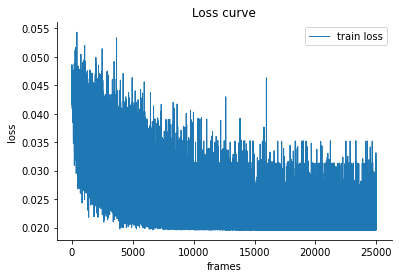

In [35]:
draw_train_los()

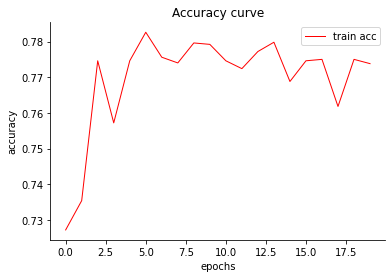

In [28]:
draw_train_acc()